<a href="https://colab.research.google.com/github/Ayazdani1997/stock-feature-prediction-final-pro/blob/master/Phase1_OCHLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install tensorflow
!pip install tensorflow-gpu

In [2]:
pip install --upgrade tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in ./venv/lib/python3.6/site-packages (2.2.0)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives
from tensorflow.keras import optimizers


import pandas
import matplotlib.pyplot as plt
# from google.colab import drive
from os.path import join
import numpy

ROOT = '/content/drive'

In [3]:
# drive.mount(ROOT)
# HOME = join(ROOT,'My Drive')
# print('enter the environment directory')
# directory = input()
COLAB_DIR = '.'
data = pandas.read_csv(join(COLAB_DIR, 'data.csv'), encoding='utf-16')

In [4]:
data = data.drop(['Unnamed: 0', 'VAL', 'NUM_OF_TRANSACTIONS','CLOSE_ONE_DAY_BEFORE'], axis=1).rename(columns={'DTYYYYMMDD': 'DATE'})
data['DATE'] = pandas.to_datetime(data['DATE'],format='%Y%m%d')

In [5]:
labels = pandas.DataFrame()
labels['CLASS'] = numpy.where(data['CLOSE'] > data['CLOSE'].shift(1), 1.0, 0.0)
labels['DATE'] = data['DATE'].copy()
labels['TICKER'] = data['TICKER'].copy()
labels.head(10)

,CLASS,DATE,TICKER
0,0.0,2019-11-20,مظنه
1,0.0,2019-11-23,مظنه
2,0.0,2019-11-24,مظنه
3,0.0,2019-11-25,مظنه
4,0.0,2019-11-26,مظنه
5,0.0,2019-11-27,مظنه
6,0.0,2019-11-30,مظنه
7,0.0,2019-12-01,مظنه
8,0.0,2019-12-02,مظنه
9,0.0,2019-12-03,مظنه


Let's assert if we are using GPU.

In [6]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
physical_devices = tensorflow.config.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [15]:
import matplotlib.dates as mdates

def draw_ochlv(data_related_to_stock, from_date, to_date):
    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(10,10))
    fig.tight_layout()

    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')

    axs[0][0].xaxis.set_major_locator(years)
    axs[0][0].xaxis.set_major_formatter(years_fmt)
    axs[0][0].xaxis.set_minor_locator(months)

    mask = (data_related_to_stock['DATE'] >= from_date) & (data_related_to_stock['DATE'] <= to_date ) 
    period = data_related_to_stock.loc[mask]
    
    starting_date = str(from_date)
    ending_date = str(to_date)

    axs[0][0].plot(period['DATE'], period['CLOSE'])
    axs[0][0].set(ylabel='closing price (in tomans)')
    axs[0][0].set_title('closing price')
    
    axs[1][0].plot(period['DATE'], period['OPEN'])
    axs[1][0].set(ylabel='opening price (in tomans)')
    axs[1][0].set_title('opening price')
                     
    
    axs[0][1].plot(period['DATE'], period['VOL'])
    axs[0][1].set(ylabel='daily volume traded (in share)')
    axs[0][1].set_title('daily volume')
                     
    
    axs[1][1].plot(period['DATE'], period['HIGH'])
    axs[1][1].set(ylabel='high price (in tomans)')
    axs[1][1].set_title('high price')
                     
    axs[2][0].plot(period['DATE'], period['LOW'])
    axs[2][0].set(ylabel='low price (in tomans)')
    axs[2][0].set_title('low price')

    axs[0][0].grid(True)
    axs[0][1].grid(True)
    axs[1][0].grid(True)
    axs[1][1].grid(True)
    axs[2][0].grid(True)

    axs[0][0].format_xdata = mdates.DateFormatter('%Y-%m-%d')

    plt.show()

In [17]:
ten_stocks_with_max_trading_days = data.groupby('TICKER').agg({'DATE': ['min', 'max', 'count'], 'VOL': ['mean']}).reset_index().sort_values(('DATE', 'count'), ascending=False).head(10)
stock_with_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[0]
ten_stocks_with_max_trading_days.head(10)

TICKER       DATE                            VOL
                   min        max count          mean
1616  وپترو 2001-03-25 2020-04-13  4366  2.323352e+06
1522  وساخت 2001-03-25 2020-04-13  4356  1.464725e+06
56    آريان 2010-10-06 2020-04-13  4347  2.723661e+06
624   خودرو 2001-03-25 2020-04-13  4340  1.123416e+07
1539   وسپه 2001-03-27 2020-04-13  4323  2.620691e+06
753   زنجان 2011-01-05 2020-04-13  4318  9.637195e+05
567   خبهمن 2001-04-07 2020-04-13  4315  6.061205e+06
1603  ونيكي 2001-04-07 2020-04-13  4302  1.712802e+06
900   شاراك 2001-03-27 2020-04-13  4298  2.342162e+06
1474  وبشهر 2001-03-25 2020-04-13  4291  2.265908e+06

## **Stateful LSTM**

In this section, we train our model on the stock with max trading days. first of all, let's visualize the train and test set of our models.

In [64]:

class MyNormalizer:
  def __init__(self):
    self.max = 0
    self.min = 0

  def fit(self, data):
    self.max = data.max()
    self.min = data.min()
  
  def transform(self, data):
    return (data - self.min) / (self.max - self.min)


def align_data(x, y, window_in_days, batch_size):
  rows_to_insert_to_x = pandas.DataFrame(numpy.zeros((window_in_days+(batch_size - len(x) % batch_size),\
                                                      len(x.columns))), columns=x.columns)
  rows_to_insert_to_y = pandas.DataFrame(numpy.zeros(\
                                                     (window_in_days+(batch_size - len(x) % batch_size), \
                                                      len(y.columns))), columns=y.columns)

  return pandas.concat([rows_to_insert_to_x, x], ignore_index=True), \
        pandas.concat([rows_to_insert_to_y, y], ignore_index=True)
  

def split_data_to_train_test(original_dataset, labels, stock, \
                             training_start, training_end, testing_start, testing_end, \
                             test_required=True, drop_date=True):
  data_related_to_stock = original_dataset[ original_dataset['TICKER'] == stock ].drop('TICKER', axis=1)
  labels_related_to_stock = labels[ labels['TICKER'] == stock ].drop('TICKER', axis=1)

 
  training_period_mask = (data_related_to_stock['DATE'] >= training_start) \
    & (data_related_to_stock['DATE'] <= training_end ) 
  training_period = data_related_to_stock.loc[training_period_mask]
  if drop_date:
        training_period = training_period.drop('DATE', axis=1)
  training_period_labels = labels_related_to_stock.loc[training_period_mask]
  if drop_date:
        training_period_labels = training_period_labels.drop('DATE', axis=1)

  testing_period = None
  testing_period_labels = None
  if test_required:
    testing_period_mask = (data_related_to_stock['DATE'] >= testing_start) \
        & (data_related_to_stock['DATE'] <= testing_end )
    testing_period = data_related_to_stock.loc[testing_period_mask]
    if drop_date:
        testing_period = testing_period.drop('DATE', axis=1)
    testing_period_labels = labels_related_to_stock.loc[testing_period_mask]
    if drop_date:
        testing_period_labels = testing_period_labels.drop('DATE', axis=1)

  return training_period, training_period_labels , testing_period, testing_period_labels


def normalize_dataframe_with_max_min(dataframe, train_max, train_min):
    normalized_df=(dataframe - train_min)/(train_max - train_min)
    return normalized_df



In [18]:
training_start = pandas.to_datetime('20080101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

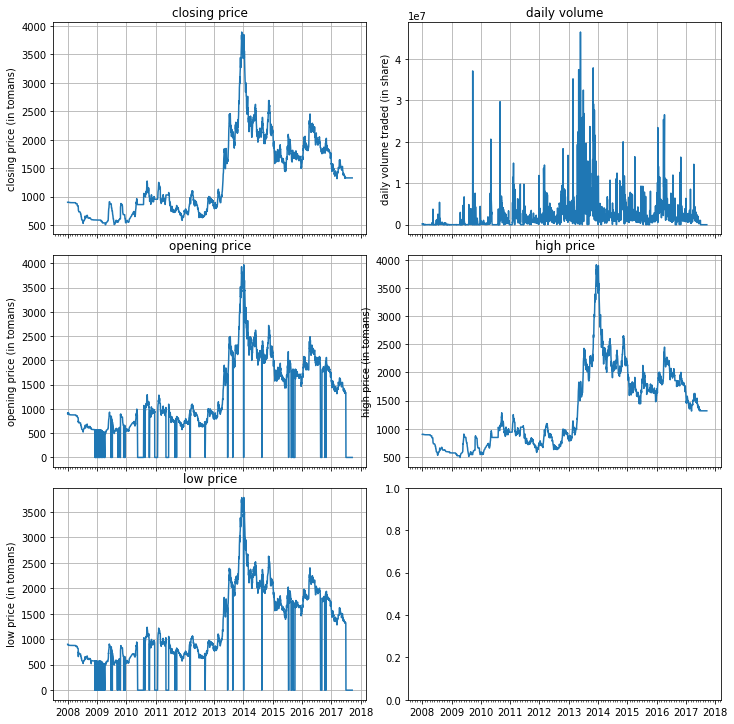

In [19]:
data_related_to_max_stock = data[ data['TICKER'] == stock_with_max_trading_days ]
draw_ochlv(data_related_to_max_stock, training_start, training_end)

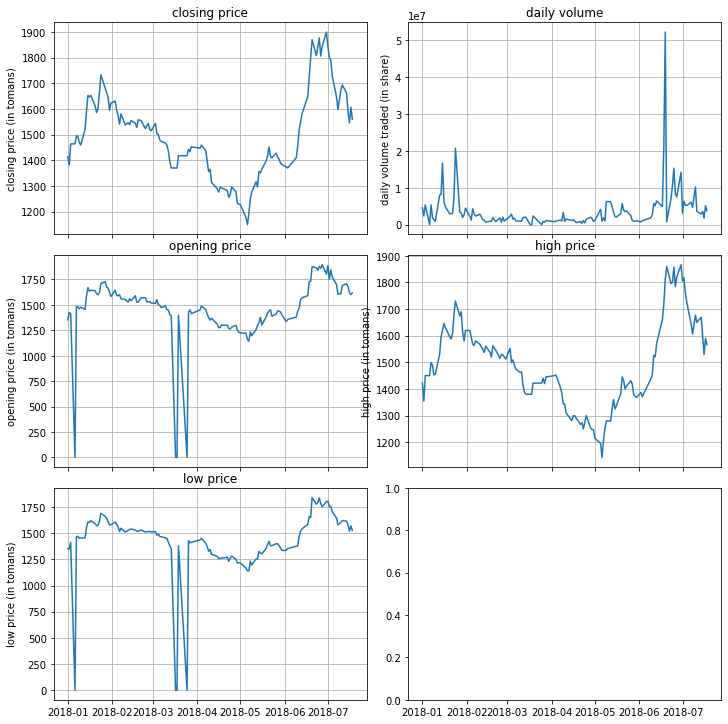

In [26]:
data_related_to_max_stock = data[ data['TICKER'] == stock_with_max_trading_days ]
draw_ochlv(data_related_to_max_stock, testing_start, testing_end)

Now, let's apply alignment and normalization on both sets and see the range of data. The batch size is 32 and window length is 10.

In [84]:
normalizer = MyNormalizer()

training_period, training_labels, testing_period, testing_labels \
    = split_data_to_train_test(data, labels, \
                               stock_with_max_trading_days, training_start, training_end \
                                , testing_start, testing_end, True, False)

training_period, _ = align_data(training_period, \
                                                       training_labels, 10, 32)

testing_period, _ = align_data(testing_period, \
                                                       testing_labels, 10, 32)
training_date = training_period['DATE']
testing_date = testing_period['DATE']

_training_period = training_period.drop('DATE', axis=1)
_testing_period = testing_period.drop('DATE', axis=1)

normalizer.fit(_training_period)
_training_period = normalizer.transform(_training_period)
_testing_period = normalizer.transform(_testing_period)
_training_period['DATE'] = training_date.reset_index(drop=True).replace(0, numpy.nan)
_testing_period['DATE'] = testing_date.reset_index(drop=True).replace(0, numpy.nan)

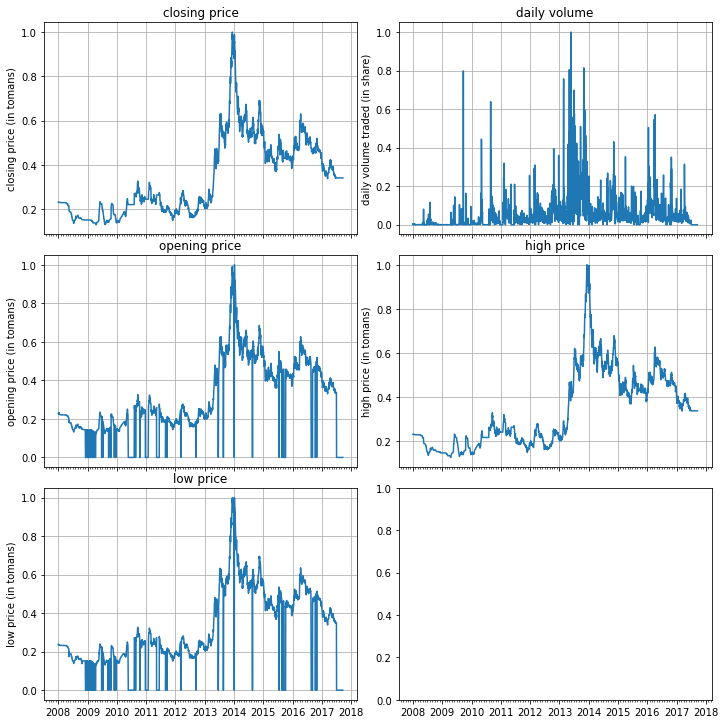

In [85]:
draw_ochlv(_training_period, training_start, training_end)

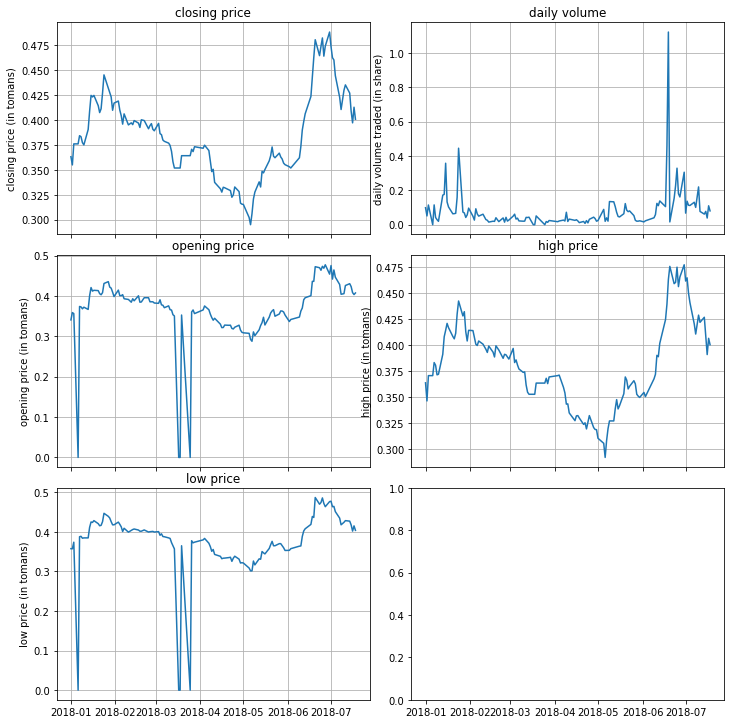

In [86]:
draw_ochlv(_testing_period, testing_start, testing_end)

Next, let's apply alignment and normalization on both sets and see the range of data. The batch size is 32 and window length is 20.

In [87]:
normalizer = MyNormalizer()

training_period, training_labels, testing_period, testing_labels \
    = split_data_to_train_test(data, labels, \
                               stock_with_max_trading_days, training_start, training_end \
                                , testing_start, testing_end, True, False)

training_period, _ = align_data(training_period, \
                                                       training_labels, 20, 32)

testing_period, _ = align_data(testing_period, \
                                                       testing_labels, 20, 32)
training_date = training_period['DATE']
testing_date = testing_period['DATE']

_training_period = training_period.drop('DATE', axis=1)
_testing_period = testing_period.drop('DATE', axis=1)

normalizer.fit(_training_period)
_training_period = normalizer.transform(_training_period)
_testing_period = normalizer.transform(_testing_period)
_training_period['DATE'] = training_date.reset_index(drop=True).replace(0, numpy.nan)
_testing_period['DATE'] = testing_date.reset_index(drop=True).replace(0, numpy.nan)

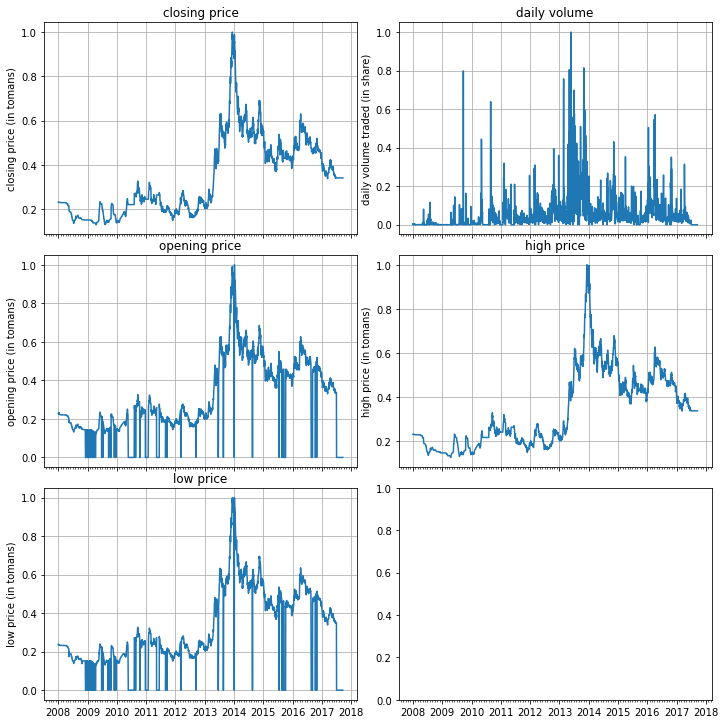

In [88]:
draw_ochlv(_training_period, training_start, training_end)

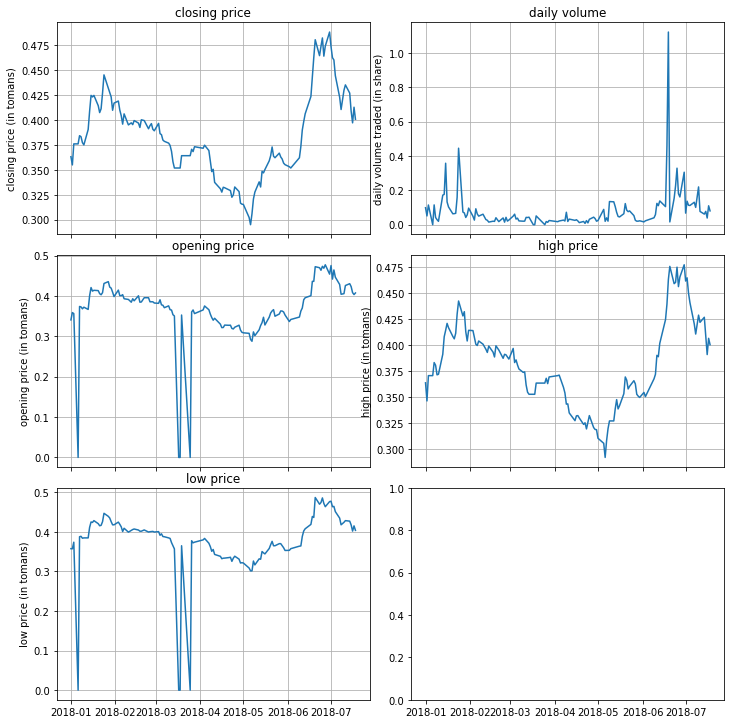

In [89]:
draw_ochlv(_testing_period, testing_start, testing_end)

Next, let's apply alignment and normalization on both sets and see the range of data. The batch size is 32 and window length is 30.

In [90]:
normalizer = MyNormalizer()

training_period, training_labels, testing_period, testing_labels \
    = split_data_to_train_test(data, labels, \
                               stock_with_max_trading_days, training_start, training_end \
                                , testing_start, testing_end, True, False)

training_period, _ = align_data(training_period, \
                                                       training_labels, 30, 32)

testing_period, _ = align_data(testing_period, \
                                                       testing_labels, 30, 32)
training_date = training_period['DATE']
testing_date = testing_period['DATE']

_training_period = training_period.drop('DATE', axis=1)
_testing_period = testing_period.drop('DATE', axis=1)

normalizer.fit(_training_period)
_training_period = normalizer.transform(_training_period)
_testing_period = normalizer.transform(_testing_period)
_training_period['DATE'] = training_date.reset_index(drop=True).replace(0, numpy.nan)
_testing_period['DATE'] = testing_date.reset_index(drop=True).replace(0, numpy.nan)

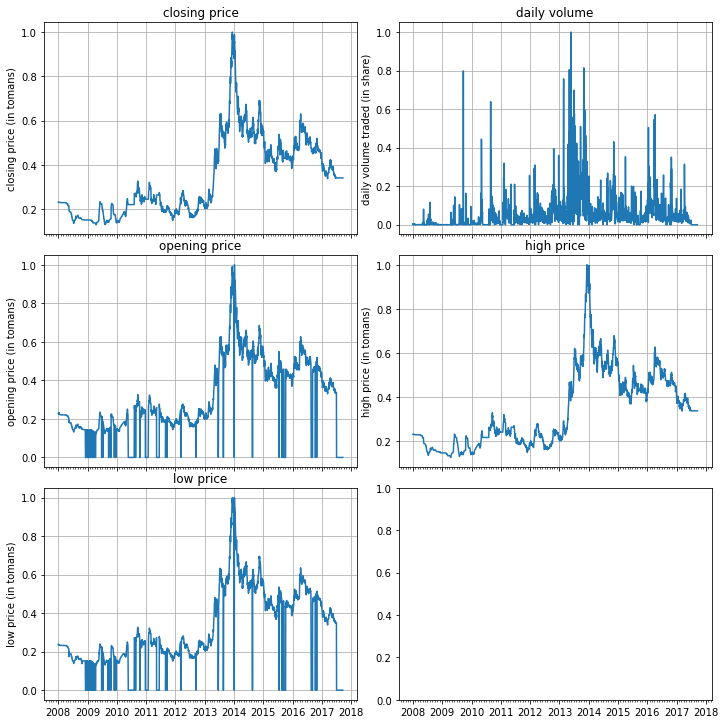

In [91]:
draw_ochlv(_training_period, training_start, training_end)

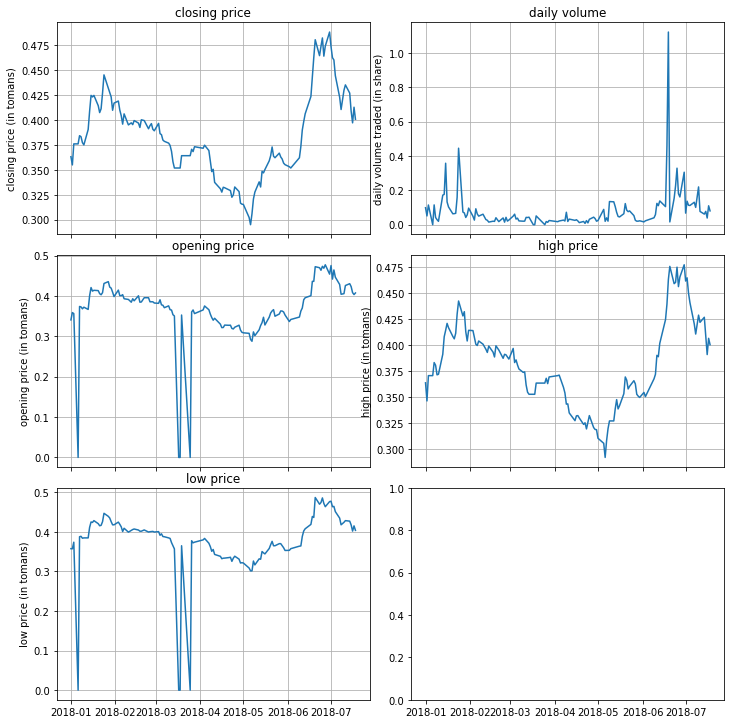

In [92]:
draw_ochlv(_testing_period, testing_start, testing_end)

So, the normalization is really suitable for this dataset.

**Now it is time to start training our model**

We use adam optimizer throughout this experiment.

In [65]:
from numpy.random import uniform

def generate_datasets_for_model(original_dataset, labels, stock, training_start, training_end, \
                                testing_start, testing_end, window_in_days=10, batch_size=32, test_required=True):
  normalizer = MyNormalizer()
  training_data = []
  training_labels = []
  testing_data = []
  testing_labels = []

  training_period, training_period_labels, testing_period, testing_period_labels \
    = split_data_to_train_test(original_dataset, labels, stock, training_start, training_end \
                                , testing_start, testing_end, test_required, True)


  training_period, training_period_labels = align_data(training_period, \
                                                       training_period_labels, window_in_days, batch_size)

  if test_required:
    testing_period, testing_period_labels = align_data(testing_period, \
                                                       testing_period_labels, window_in_days, batch_size)                                                                                               

  normalizer.fit(training_period)
  training_period = normalizer.transform(training_period)

  for j in range(window_in_days, len(training_period)):
    training_data.append(numpy.array(training_period[ j - window_in_days : j ].copy()))
    training_labels.append(numpy.array(training_period_labels.iloc[j]))

  training_data = numpy.array(training_data)
  training_labels = numpy.array(training_labels)

  if test_required:
    testing_period = normalizer.transform(testing_period)
    for j in range(window_in_days, len(testing_period)):
      testing_data.append(numpy.array(testing_period[ j - window_in_days : j ].copy()))
      testing_labels.append(numpy.array(testing_period_labels.iloc[j]))

  testing_data = numpy.array(testing_data)
  testing_labels = numpy.array(testing_labels)

  train_generator = DataGenerator(training_data, training_labels, batch_size=batch_size)
  test_generator = DataGenerator(testing_data, testing_labels, batch_size=batch_size)

  return train_generator, test_generator



In [27]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels, batch_size=32):
        'Initialization'
        self.data = data
        self.dim = data.shape
        self.batch_size = batch_size
        self.labels = labels
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(numpy.floor(self.dim[0] / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        x = self.data[index * self.batch_size: (index + 1) * self.batch_size]

        y = self.labels[index * self.batch_size: (index + 1) * self.batch_size]
        
        return x, y

    def on_epoch_end(self):
        pass

In [28]:

def build_model(input_shape, optimizer='adam', layers=None, loss='binary_crossentropy', metrics=[BinaryAccuracy(name='accuracy')]):
  if layers is None:
    model = Sequential()
    model.add(LSTM(64, input_shape=(input_shape[1], input_shape[2])))
    model.add(Dense(32))
    model.add(Dropout(0.1))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dense(4))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

  else:
    model = Sequential(layers)
  
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)


  return model


In [29]:
from tensorflow.keras.callbacks import ProgbarLogger
from tensorflow.keras.callbacks import Callback
from datetime import datetime

class MyLogger(Callback):
    def __init__(self, verbose, count_mode='samples'):
        # Ignore the `verbose` argument specified in `fit()` and pass `count_mode` upstream
        self.verbose = verbose
        self.metrics = ['loss', 'accuracy']
        self.epoch_start = 0
        self.epoch_finish = 0

    def on_train_begin(self, logs=None):
        pass

    def on_epoch_begin(self, epoch, logs=None):
        self.params['metrics'] = self.metrics
        self.epochs = self.params['epochs']
        if self.verbose:
            print('----------->> Epoch %d/%d' % (epoch + 1, self.epochs), end='   ')
        self.epoch_start = datetime.now()

    def on_batch_begin(self, batch, logs=None):
        pass

    def on_batch_end(self, batch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_finish = datetime.now()
        duration = (self.epoch_finish - self.epoch_start).total_seconds()
        print('%.3f seconds' % (duration), end=' , ')
        self.log_values = []
        logs = logs or {}
        for k in self.params['metrics']:
            if k in logs:
                self.log_values.append((k, logs[k]))
        if self.verbose:
            for metric, value in self.log_values:
              print('%s : %.3f' % ( metric, value), end='    ')
        print()
    
    def on_train_end(self, logs=None):
        pass


In [30]:
# results is in form of [loss, acc, true positives, false positives, true negatives, false negatives]
def calc_pos_neg_rate(results):
  new_results = {}
  new_results['loss'] = results[0] # loss
  new_results['acc'] = results[1] # accuracy
  new_results['true_positive_rate'] = (results[2]) / (results[2] + results[5]) # true positive rate
  new_results['false_positive_rate'] = (results[3]) / (results[3] + results[4]) # false positive rate
  new_results['positive_precision'] = (results[2]) / (results[2] + results[3]) # positive precision
  new_results['negative_precision'] = (results[4]) / (results[4] + results[5]) # negative precision
  return new_results

In [113]:
def tabular_test_train_results(train_generator, test_generator, train_results, test_results, batch_size=32):
    rows = ['train', 'test']
    columns = [metric for metric in test_results]
    columns.append('set_size')
    table_data = [ [str(train_results[metric]) for metric in train_results],\
            [str(test_results[metric]) for metric in test_results]]
    table_data[0].append(len(train_generator) * batch_size)
    table_data[1].append(len(test_generator) * batch_size)
    table = plt.table(cellText=table_data,
                      rowLabels=rows,
                      colLabels=columns,
                      cellLoc='center',
                      loc='center',
                      rowLoc='center',
                      )
    plt.axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(2, 8)
    plt.show()

In [32]:
def fit(model, epochs, train_generator):
  train_losses = []

  train_accs = []

  for i in range(epochs):
      print('epoch %d' % (i + 1))
      history = model.fit(x=train_generator,
                        epochs=1,
                        verbose=0,
                        callbacks=[MyLogger(1)]
                        )
      train_accs.append(history.history['accuracy'])
      train_losses.append(history.history['loss'])
      model.reset_states() 
  return train_accs, train_losses

Now, we want to train the model using different window sizes to see the effect on the performance of the model. Throughout the document, we also report true positive rate, false positive rate, positive precision and negative precision.

Let's start with window size of 10.

In [97]:
epochs = 5000

In [98]:
optimizer = optimizers.Adam(learning_rate=0.001)

In [99]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, \
                                                              training_start, training_end, testing_start, \
                                                              testing_end)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
first_model = build_model(None, optimizer, layers, metrics=metrics)
first_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (32, 64)                  17920     
_________________________________________________________________
dense_40 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_10 (Dropout)         (32, 32)                  0         
_________________________________________________________________
dense_41 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_10 (Batc (32, 16)                  64        
_________________________________________________________________
dense_42 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_43 (Dense)             (32, 1)                 

In [100]:
train_accs, train_losses = fit(first_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.738 seconds , loss : 0.705    accuracy : 0.528    
epoch 2
----------->> Epoch 1/1   0.265 seconds , loss : 0.675    accuracy : 0.576    
epoch 3
----------->> Epoch 1/1   0.229 seconds , loss : 0.664    accuracy : 0.604    
epoch 4
----------->> Epoch 1/1   0.234 seconds , loss : 0.659    accuracy : 0.604    
epoch 5
----------->> Epoch 1/1   0.233 seconds , loss : 0.656    accuracy : 0.619    
epoch 6
----------->> Epoch 1/1   0.257 seconds , loss : 0.655    accuracy : 0.618    
epoch 7
----------->> Epoch 1/1   0.239 seconds , loss : 0.649    accuracy : 0.635    
epoch 8
----------->> Epoch 1/1   0.296 seconds , loss : 0.649    accuracy : 0.607    
epoch 9
----------->> Epoch 1/1   0.308 seconds , loss : 0.650    accuracy : 0.619    
epoch 10
----------->> Epoch 1/1   0.244 seconds , loss : 0.647    accuracy : 0.617    
epoch 11
----------->> Epoch 1/1   0.248 seconds , loss : 0.648    accuracy : 0.619    
epoch 12
----------->> Epoch 1/1   0.244 

----------->> Epoch 1/1   0.305 seconds , loss : 0.559    accuracy : 0.729    
epoch 95
----------->> Epoch 1/1   0.298 seconds , loss : 0.549    accuracy : 0.742    
epoch 96
----------->> Epoch 1/1   0.350 seconds , loss : 0.556    accuracy : 0.737    
epoch 97
----------->> Epoch 1/1   0.262 seconds , loss : 0.550    accuracy : 0.731    
epoch 98
----------->> Epoch 1/1   0.307 seconds , loss : 0.545    accuracy : 0.750    
epoch 99
----------->> Epoch 1/1   0.261 seconds , loss : 0.549    accuracy : 0.739    
epoch 100
----------->> Epoch 1/1   0.281 seconds , loss : 0.550    accuracy : 0.737    
epoch 101
----------->> Epoch 1/1   0.256 seconds , loss : 0.548    accuracy : 0.741    
epoch 102
----------->> Epoch 1/1   0.298 seconds , loss : 0.546    accuracy : 0.747    
epoch 103
----------->> Epoch 1/1   0.265 seconds , loss : 0.542    accuracy : 0.745    
epoch 104
----------->> Epoch 1/1   0.254 seconds , loss : 0.550    accuracy : 0.735    
epoch 105
----------->> Epoch 1/1   

----------->> Epoch 1/1   0.253 seconds , loss : 0.522    accuracy : 0.761    
epoch 187
----------->> Epoch 1/1   0.360 seconds , loss : 0.519    accuracy : 0.761    
epoch 188
----------->> Epoch 1/1   0.295 seconds , loss : 0.517    accuracy : 0.762    
epoch 189
----------->> Epoch 1/1   0.258 seconds , loss : 0.515    accuracy : 0.751    
epoch 190
----------->> Epoch 1/1   0.268 seconds , loss : 0.524    accuracy : 0.756    
epoch 191
----------->> Epoch 1/1   0.266 seconds , loss : 0.517    accuracy : 0.763    
epoch 192
----------->> Epoch 1/1   0.271 seconds , loss : 0.511    accuracy : 0.763    
epoch 193
----------->> Epoch 1/1   0.273 seconds , loss : 0.518    accuracy : 0.762    
epoch 194
----------->> Epoch 1/1   0.264 seconds , loss : 0.518    accuracy : 0.762    
epoch 195
----------->> Epoch 1/1   0.289 seconds , loss : 0.511    accuracy : 0.762    
epoch 196
----------->> Epoch 1/1   0.255 seconds , loss : 0.515    accuracy : 0.757    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.280 seconds , loss : 0.488    accuracy : 0.777    
epoch 279
----------->> Epoch 1/1   0.289 seconds , loss : 0.489    accuracy : 0.777    
epoch 280
----------->> Epoch 1/1   0.264 seconds , loss : 0.492    accuracy : 0.775    
epoch 281
----------->> Epoch 1/1   0.262 seconds , loss : 0.494    accuracy : 0.775    
epoch 282
----------->> Epoch 1/1   0.257 seconds , loss : 0.486    accuracy : 0.781    
epoch 283
----------->> Epoch 1/1   0.287 seconds , loss : 0.498    accuracy : 0.776    
epoch 284
----------->> Epoch 1/1   0.257 seconds , loss : 0.491    accuracy : 0.770    
epoch 285
----------->> Epoch 1/1   0.263 seconds , loss : 0.492    accuracy : 0.780    
epoch 286
----------->> Epoch 1/1   0.260 seconds , loss : 0.492    accuracy : 0.776    
epoch 287
----------->> Epoch 1/1   0.266 seconds , loss : 0.500    accuracy : 0.772    
epoch 288
----------->> Epoch 1/1   0.257 seconds , loss : 0.491    accuracy : 0.771    
epoch 289
----------->> Epoch 1

----------->> Epoch 1/1   0.241 seconds , loss : 0.460    accuracy : 0.791    
epoch 371
----------->> Epoch 1/1   0.292 seconds , loss : 0.458    accuracy : 0.797    
epoch 372
----------->> Epoch 1/1   0.251 seconds , loss : 0.457    accuracy : 0.796    
epoch 373
----------->> Epoch 1/1   0.300 seconds , loss : 0.458    accuracy : 0.786    
epoch 374
----------->> Epoch 1/1   0.246 seconds , loss : 0.457    accuracy : 0.796    
epoch 375
----------->> Epoch 1/1   0.243 seconds , loss : 0.458    accuracy : 0.785    
epoch 376
----------->> Epoch 1/1   0.240 seconds , loss : 0.463    accuracy : 0.792    
epoch 377
----------->> Epoch 1/1   0.285 seconds , loss : 0.459    accuracy : 0.785    
epoch 378
----------->> Epoch 1/1   0.284 seconds , loss : 0.459    accuracy : 0.797    
epoch 379
----------->> Epoch 1/1   0.270 seconds , loss : 0.466    accuracy : 0.782    
epoch 380
----------->> Epoch 1/1   0.287 seconds , loss : 0.454    accuracy : 0.799    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.272 seconds , loss : 0.431    accuracy : 0.815    
epoch 463
----------->> Epoch 1/1   0.265 seconds , loss : 0.417    accuracy : 0.819    
epoch 464
----------->> Epoch 1/1   0.264 seconds , loss : 0.420    accuracy : 0.821    
epoch 465
----------->> Epoch 1/1   0.260 seconds , loss : 0.421    accuracy : 0.818    
epoch 466
----------->> Epoch 1/1   0.262 seconds , loss : 0.417    accuracy : 0.809    
epoch 467
----------->> Epoch 1/1   0.257 seconds , loss : 0.430    accuracy : 0.813    
epoch 468
----------->> Epoch 1/1   0.267 seconds , loss : 0.419    accuracy : 0.817    
epoch 469
----------->> Epoch 1/1   0.259 seconds , loss : 0.419    accuracy : 0.821    
epoch 470
----------->> Epoch 1/1   0.263 seconds , loss : 0.426    accuracy : 0.824    
epoch 471
----------->> Epoch 1/1   0.261 seconds , loss : 0.418    accuracy : 0.821    
epoch 472
----------->> Epoch 1/1   0.263 seconds , loss : 0.420    accuracy : 0.815    
epoch 473
----------->> Epoch 1

----------->> Epoch 1/1   0.296 seconds , loss : 0.373    accuracy : 0.848    
epoch 555
----------->> Epoch 1/1   0.274 seconds , loss : 0.384    accuracy : 0.842    
epoch 556
----------->> Epoch 1/1   0.270 seconds , loss : 0.386    accuracy : 0.842    
epoch 557
----------->> Epoch 1/1   0.256 seconds , loss : 0.378    accuracy : 0.838    
epoch 558
----------->> Epoch 1/1   0.287 seconds , loss : 0.380    accuracy : 0.841    
epoch 559
----------->> Epoch 1/1   0.292 seconds , loss : 0.373    accuracy : 0.841    
epoch 560
----------->> Epoch 1/1   0.285 seconds , loss : 0.389    accuracy : 0.842    
epoch 561
----------->> Epoch 1/1   0.297 seconds , loss : 0.391    accuracy : 0.836    
epoch 562
----------->> Epoch 1/1   0.307 seconds , loss : 0.384    accuracy : 0.834    
epoch 563
----------->> Epoch 1/1   0.328 seconds , loss : 0.383    accuracy : 0.839    
epoch 564
----------->> Epoch 1/1   0.269 seconds , loss : 0.378    accuracy : 0.842    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.258 seconds , loss : 0.356    accuracy : 0.854    
epoch 647
----------->> Epoch 1/1   0.265 seconds , loss : 0.363    accuracy : 0.848    
epoch 648
----------->> Epoch 1/1   0.263 seconds , loss : 0.348    accuracy : 0.863    
epoch 649
----------->> Epoch 1/1   0.272 seconds , loss : 0.338    accuracy : 0.858    
epoch 650
----------->> Epoch 1/1   0.268 seconds , loss : 0.336    accuracy : 0.865    
epoch 651
----------->> Epoch 1/1   0.268 seconds , loss : 0.349    accuracy : 0.854    
epoch 652
----------->> Epoch 1/1   0.274 seconds , loss : 0.335    accuracy : 0.868    
epoch 653
----------->> Epoch 1/1   0.276 seconds , loss : 0.345    accuracy : 0.863    
epoch 654
----------->> Epoch 1/1   0.267 seconds , loss : 0.342    accuracy : 0.857    
epoch 655
----------->> Epoch 1/1   0.266 seconds , loss : 0.344    accuracy : 0.858    
epoch 656
----------->> Epoch 1/1   0.260 seconds , loss : 0.326    accuracy : 0.859    
epoch 657
----------->> Epoch 1

----------->> Epoch 1/1   0.291 seconds , loss : 0.302    accuracy : 0.872    
epoch 739
----------->> Epoch 1/1   0.249 seconds , loss : 0.312    accuracy : 0.878    
epoch 740
----------->> Epoch 1/1   0.238 seconds , loss : 0.320    accuracy : 0.872    
epoch 741
----------->> Epoch 1/1   0.237 seconds , loss : 0.322    accuracy : 0.881    
epoch 742
----------->> Epoch 1/1   0.239 seconds , loss : 0.309    accuracy : 0.876    
epoch 743
----------->> Epoch 1/1   0.237 seconds , loss : 0.302    accuracy : 0.877    
epoch 744
----------->> Epoch 1/1   0.237 seconds , loss : 0.310    accuracy : 0.874    
epoch 745
----------->> Epoch 1/1   0.236 seconds , loss : 0.295    accuracy : 0.881    
epoch 746
----------->> Epoch 1/1   0.238 seconds , loss : 0.302    accuracy : 0.876    
epoch 747
----------->> Epoch 1/1   0.238 seconds , loss : 0.309    accuracy : 0.873    
epoch 748
----------->> Epoch 1/1   0.235 seconds , loss : 0.303    accuracy : 0.884    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.241 seconds , loss : 0.271    accuracy : 0.897    
epoch 831
----------->> Epoch 1/1   0.247 seconds , loss : 0.277    accuracy : 0.889    
epoch 832
----------->> Epoch 1/1   0.262 seconds , loss : 0.282    accuracy : 0.896    
epoch 833
----------->> Epoch 1/1   0.244 seconds , loss : 0.274    accuracy : 0.897    
epoch 834
----------->> Epoch 1/1   0.237 seconds , loss : 0.276    accuracy : 0.891    
epoch 835
----------->> Epoch 1/1   0.238 seconds , loss : 0.264    accuracy : 0.896    
epoch 836
----------->> Epoch 1/1   0.239 seconds , loss : 0.270    accuracy : 0.888    
epoch 837
----------->> Epoch 1/1   0.236 seconds , loss : 0.281    accuracy : 0.892    
epoch 838
----------->> Epoch 1/1   0.239 seconds , loss : 0.287    accuracy : 0.890    
epoch 839
----------->> Epoch 1/1   0.237 seconds , loss : 0.273    accuracy : 0.894    
epoch 840
----------->> Epoch 1/1   0.236 seconds , loss : 0.272    accuracy : 0.902    
epoch 841
----------->> Epoch 1

----------->> Epoch 1/1   0.309 seconds , loss : 0.258    accuracy : 0.902    
epoch 923
----------->> Epoch 1/1   0.295 seconds , loss : 0.241    accuracy : 0.911    
epoch 924
----------->> Epoch 1/1   0.277 seconds , loss : 0.235    accuracy : 0.908    
epoch 925
----------->> Epoch 1/1   0.251 seconds , loss : 0.240    accuracy : 0.910    
epoch 926
----------->> Epoch 1/1   0.257 seconds , loss : 0.238    accuracy : 0.909    
epoch 927
----------->> Epoch 1/1   0.273 seconds , loss : 0.235    accuracy : 0.909    
epoch 928
----------->> Epoch 1/1   0.275 seconds , loss : 0.244    accuracy : 0.904    
epoch 929
----------->> Epoch 1/1   0.293 seconds , loss : 0.243    accuracy : 0.909    
epoch 930
----------->> Epoch 1/1   0.258 seconds , loss : 0.256    accuracy : 0.904    
epoch 931
----------->> Epoch 1/1   0.280 seconds , loss : 0.236    accuracy : 0.909    
epoch 932
----------->> Epoch 1/1   0.281 seconds , loss : 0.232    accuracy : 0.916    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.264 seconds , loss : 0.217    accuracy : 0.920    
epoch 1015
----------->> Epoch 1/1   0.262 seconds , loss : 0.230    accuracy : 0.910    
epoch 1016
----------->> Epoch 1/1   0.265 seconds , loss : 0.227    accuracy : 0.913    
epoch 1017
----------->> Epoch 1/1   0.269 seconds , loss : 0.221    accuracy : 0.924    
epoch 1018
----------->> Epoch 1/1   0.258 seconds , loss : 0.205    accuracy : 0.927    
epoch 1019
----------->> Epoch 1/1   0.266 seconds , loss : 0.220    accuracy : 0.920    
epoch 1020
----------->> Epoch 1/1   0.265 seconds , loss : 0.198    accuracy : 0.926    
epoch 1021
----------->> Epoch 1/1   0.272 seconds , loss : 0.222    accuracy : 0.920    
epoch 1022
----------->> Epoch 1/1   0.263 seconds , loss : 0.213    accuracy : 0.925    
epoch 1023
----------->> Epoch 1/1   0.270 seconds , loss : 0.215    accuracy : 0.922    
epoch 1024
----------->> Epoch 1/1   0.264 seconds , loss : 0.208    accuracy : 0.921    
epoch 1025
----------

----------->> Epoch 1/1   0.252 seconds , loss : 0.227    accuracy : 0.917    
epoch 1106
----------->> Epoch 1/1   0.297 seconds , loss : 0.195    accuracy : 0.933    
epoch 1107
----------->> Epoch 1/1   0.255 seconds , loss : 0.187    accuracy : 0.932    
epoch 1108
----------->> Epoch 1/1   0.256 seconds , loss : 0.182    accuracy : 0.935    
epoch 1109
----------->> Epoch 1/1   0.249 seconds , loss : 0.198    accuracy : 0.932    
epoch 1110
----------->> Epoch 1/1   0.253 seconds , loss : 0.222    accuracy : 0.917    
epoch 1111
----------->> Epoch 1/1   0.280 seconds , loss : 0.217    accuracy : 0.929    
epoch 1112
----------->> Epoch 1/1   0.279 seconds , loss : 0.188    accuracy : 0.935    
epoch 1113
----------->> Epoch 1/1   0.287 seconds , loss : 0.182    accuracy : 0.937    
epoch 1114
----------->> Epoch 1/1   0.289 seconds , loss : 0.205    accuracy : 0.922    
epoch 1115
----------->> Epoch 1/1   0.290 seconds , loss : 0.210    accuracy : 0.921    
epoch 1116
----------

----------->> Epoch 1/1   0.265 seconds , loss : 0.218    accuracy : 0.922    
epoch 1197
----------->> Epoch 1/1   0.268 seconds , loss : 0.178    accuracy : 0.937    
epoch 1198
----------->> Epoch 1/1   0.265 seconds , loss : 0.176    accuracy : 0.939    
epoch 1199
----------->> Epoch 1/1   0.271 seconds , loss : 0.174    accuracy : 0.938    
epoch 1200
----------->> Epoch 1/1   0.268 seconds , loss : 0.166    accuracy : 0.943    
epoch 1201
----------->> Epoch 1/1   0.264 seconds , loss : 0.166    accuracy : 0.942    
epoch 1202
----------->> Epoch 1/1   0.271 seconds , loss : 0.176    accuracy : 0.941    
epoch 1203
----------->> Epoch 1/1   0.276 seconds , loss : 0.166    accuracy : 0.943    
epoch 1204
----------->> Epoch 1/1   0.280 seconds , loss : 0.176    accuracy : 0.940    
epoch 1205
----------->> Epoch 1/1   0.268 seconds , loss : 0.166    accuracy : 0.941    
epoch 1206
----------->> Epoch 1/1   0.261 seconds , loss : 0.192    accuracy : 0.931    
epoch 1207
----------

----------->> Epoch 1/1   0.282 seconds , loss : 0.172    accuracy : 0.945    
epoch 1288
----------->> Epoch 1/1   0.309 seconds , loss : 0.164    accuracy : 0.943    
epoch 1289
----------->> Epoch 1/1   0.301 seconds , loss : 0.158    accuracy : 0.942    
epoch 1290
----------->> Epoch 1/1   0.268 seconds , loss : 0.156    accuracy : 0.946    
epoch 1291
----------->> Epoch 1/1   0.274 seconds , loss : 0.150    accuracy : 0.945    
epoch 1292
----------->> Epoch 1/1   0.292 seconds , loss : 0.153    accuracy : 0.948    
epoch 1293
----------->> Epoch 1/1   0.282 seconds , loss : 0.146    accuracy : 0.951    
epoch 1294
----------->> Epoch 1/1   0.288 seconds , loss : 0.152    accuracy : 0.949    
epoch 1295
----------->> Epoch 1/1   0.284 seconds , loss : 0.156    accuracy : 0.946    
epoch 1296
----------->> Epoch 1/1   0.290 seconds , loss : 0.154    accuracy : 0.949    
epoch 1297
----------->> Epoch 1/1   0.308 seconds , loss : 0.150    accuracy : 0.949    
epoch 1298
----------

----------->> Epoch 1/1   0.243 seconds , loss : 0.150    accuracy : 0.946    
epoch 1379
----------->> Epoch 1/1   0.266 seconds , loss : 0.128    accuracy : 0.961    
epoch 1380
----------->> Epoch 1/1   0.245 seconds , loss : 0.138    accuracy : 0.952    
epoch 1381
----------->> Epoch 1/1   0.293 seconds , loss : 0.145    accuracy : 0.946    
epoch 1382
----------->> Epoch 1/1   0.252 seconds , loss : 0.147    accuracy : 0.954    
epoch 1383
----------->> Epoch 1/1   0.274 seconds , loss : 0.153    accuracy : 0.952    
epoch 1384
----------->> Epoch 1/1   0.282 seconds , loss : 0.143    accuracy : 0.956    
epoch 1385
----------->> Epoch 1/1   0.242 seconds , loss : 0.147    accuracy : 0.951    
epoch 1386
----------->> Epoch 1/1   0.259 seconds , loss : 0.134    accuracy : 0.955    
epoch 1387
----------->> Epoch 1/1   0.247 seconds , loss : 0.136    accuracy : 0.949    
epoch 1388
----------->> Epoch 1/1   0.251 seconds , loss : 0.140    accuracy : 0.952    
epoch 1389
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.119    accuracy : 0.959    
epoch 1470
----------->> Epoch 1/1   0.254 seconds , loss : 0.127    accuracy : 0.959    
epoch 1471
----------->> Epoch 1/1   0.256 seconds , loss : 0.133    accuracy : 0.958    
epoch 1472
----------->> Epoch 1/1   0.262 seconds , loss : 0.130    accuracy : 0.955    
epoch 1473
----------->> Epoch 1/1   0.266 seconds , loss : 0.122    accuracy : 0.961    
epoch 1474
----------->> Epoch 1/1   0.266 seconds , loss : 0.115    accuracy : 0.962    
epoch 1475
----------->> Epoch 1/1   0.264 seconds , loss : 0.150    accuracy : 0.954    
epoch 1476
----------->> Epoch 1/1   0.262 seconds , loss : 0.137    accuracy : 0.954    
epoch 1477
----------->> Epoch 1/1   0.260 seconds , loss : 0.129    accuracy : 0.956    
epoch 1478
----------->> Epoch 1/1   0.278 seconds , loss : 0.129    accuracy : 0.963    
epoch 1479
----------->> Epoch 1/1   0.263 seconds , loss : 0.122    accuracy : 0.962    
epoch 1480
----------

----------->> Epoch 1/1   0.254 seconds , loss : 0.102    accuracy : 0.971    
epoch 1561
----------->> Epoch 1/1   0.268 seconds , loss : 0.113    accuracy : 0.967    
epoch 1562
----------->> Epoch 1/1   0.268 seconds , loss : 0.131    accuracy : 0.955    
epoch 1563
----------->> Epoch 1/1   0.256 seconds , loss : 0.127    accuracy : 0.957    
epoch 1564
----------->> Epoch 1/1   0.276 seconds , loss : 0.128    accuracy : 0.953    
epoch 1565
----------->> Epoch 1/1   0.262 seconds , loss : 0.117    accuracy : 0.961    
epoch 1566
----------->> Epoch 1/1   0.265 seconds , loss : 0.126    accuracy : 0.959    
epoch 1567
----------->> Epoch 1/1   0.264 seconds , loss : 0.131    accuracy : 0.955    
epoch 1568
----------->> Epoch 1/1   0.263 seconds , loss : 0.122    accuracy : 0.960    
epoch 1569
----------->> Epoch 1/1   0.257 seconds , loss : 0.112    accuracy : 0.964    
epoch 1570
----------->> Epoch 1/1   0.266 seconds , loss : 0.109    accuracy : 0.964    
epoch 1571
----------

----------->> Epoch 1/1   0.262 seconds , loss : 0.122    accuracy : 0.955    
epoch 1652
----------->> Epoch 1/1   0.249 seconds , loss : 0.109    accuracy : 0.966    
epoch 1653
----------->> Epoch 1/1   0.250 seconds , loss : 0.113    accuracy : 0.961    
epoch 1654
----------->> Epoch 1/1   0.248 seconds , loss : 0.108    accuracy : 0.965    
epoch 1655
----------->> Epoch 1/1   0.251 seconds , loss : 0.108    accuracy : 0.963    
epoch 1656
----------->> Epoch 1/1   0.302 seconds , loss : 0.111    accuracy : 0.961    
epoch 1657
----------->> Epoch 1/1   0.310 seconds , loss : 0.116    accuracy : 0.962    
epoch 1658
----------->> Epoch 1/1   0.261 seconds , loss : 0.114    accuracy : 0.963    
epoch 1659
----------->> Epoch 1/1   0.258 seconds , loss : 0.096    accuracy : 0.970    
epoch 1660
----------->> Epoch 1/1   0.249 seconds , loss : 0.109    accuracy : 0.967    
epoch 1661
----------->> Epoch 1/1   0.249 seconds , loss : 0.096    accuracy : 0.970    
epoch 1662
----------

----------->> Epoch 1/1   0.304 seconds , loss : 0.093    accuracy : 0.970    
epoch 1743
----------->> Epoch 1/1   0.245 seconds , loss : 0.102    accuracy : 0.968    
epoch 1744
----------->> Epoch 1/1   0.239 seconds , loss : 0.104    accuracy : 0.969    
epoch 1745
----------->> Epoch 1/1   0.242 seconds , loss : 0.119    accuracy : 0.958    
epoch 1746
----------->> Epoch 1/1   0.303 seconds , loss : 0.116    accuracy : 0.960    
epoch 1747
----------->> Epoch 1/1   0.286 seconds , loss : 0.095    accuracy : 0.972    
epoch 1748
----------->> Epoch 1/1   0.265 seconds , loss : 0.118    accuracy : 0.967    
epoch 1749
----------->> Epoch 1/1   0.240 seconds , loss : 0.110    accuracy : 0.963    
epoch 1750
----------->> Epoch 1/1   0.250 seconds , loss : 0.088    accuracy : 0.972    
epoch 1751
----------->> Epoch 1/1   0.302 seconds , loss : 0.096    accuracy : 0.970    
epoch 1752
----------->> Epoch 1/1   0.245 seconds , loss : 0.081    accuracy : 0.975    
epoch 1753
----------

----------->> Epoch 1/1   0.291 seconds , loss : 0.096    accuracy : 0.973    
epoch 1834
----------->> Epoch 1/1   0.253 seconds , loss : 0.100    accuracy : 0.967    
epoch 1835
----------->> Epoch 1/1   0.276 seconds , loss : 0.091    accuracy : 0.969    
epoch 1836
----------->> Epoch 1/1   0.271 seconds , loss : 0.100    accuracy : 0.967    
epoch 1837
----------->> Epoch 1/1   0.262 seconds , loss : 0.102    accuracy : 0.965    
epoch 1838
----------->> Epoch 1/1   0.260 seconds , loss : 0.092    accuracy : 0.970    
epoch 1839
----------->> Epoch 1/1   0.260 seconds , loss : 0.114    accuracy : 0.970    
epoch 1840
----------->> Epoch 1/1   0.264 seconds , loss : 0.103    accuracy : 0.971    
epoch 1841
----------->> Epoch 1/1   0.273 seconds , loss : 0.082    accuracy : 0.976    
epoch 1842
----------->> Epoch 1/1   0.257 seconds , loss : 0.092    accuracy : 0.975    
epoch 1843
----------->> Epoch 1/1   0.252 seconds , loss : 0.106    accuracy : 0.961    
epoch 1844
----------

----------->> Epoch 1/1   0.263 seconds , loss : 0.072    accuracy : 0.982    
epoch 1925
----------->> Epoch 1/1   0.271 seconds , loss : 0.076    accuracy : 0.976    
epoch 1926
----------->> Epoch 1/1   0.245 seconds , loss : 0.080    accuracy : 0.977    
epoch 1927
----------->> Epoch 1/1   0.248 seconds , loss : 0.084    accuracy : 0.973    
epoch 1928
----------->> Epoch 1/1   0.237 seconds , loss : 0.073    accuracy : 0.975    
epoch 1929
----------->> Epoch 1/1   0.243 seconds , loss : 0.096    accuracy : 0.967    
epoch 1930
----------->> Epoch 1/1   0.242 seconds , loss : 0.113    accuracy : 0.962    
epoch 1931
----------->> Epoch 1/1   0.268 seconds , loss : 0.089    accuracy : 0.976    
epoch 1932
----------->> Epoch 1/1   0.255 seconds , loss : 0.090    accuracy : 0.971    
epoch 1933
----------->> Epoch 1/1   0.252 seconds , loss : 0.102    accuracy : 0.969    
epoch 1934
----------->> Epoch 1/1   0.296 seconds , loss : 0.115    accuracy : 0.963    
epoch 1935
----------

----------->> Epoch 1/1   0.245 seconds , loss : 0.098    accuracy : 0.968    
epoch 2016
----------->> Epoch 1/1   0.251 seconds , loss : 0.103    accuracy : 0.967    
epoch 2017
----------->> Epoch 1/1   0.250 seconds , loss : 0.114    accuracy : 0.961    
epoch 2018
----------->> Epoch 1/1   0.240 seconds , loss : 0.094    accuracy : 0.970    
epoch 2019
----------->> Epoch 1/1   0.228 seconds , loss : 0.079    accuracy : 0.973    
epoch 2020
----------->> Epoch 1/1   0.310 seconds , loss : 0.083    accuracy : 0.973    
epoch 2021
----------->> Epoch 1/1   0.277 seconds , loss : 0.073    accuracy : 0.976    
epoch 2022
----------->> Epoch 1/1   0.235 seconds , loss : 0.094    accuracy : 0.970    
epoch 2023
----------->> Epoch 1/1   0.240 seconds , loss : 0.091    accuracy : 0.970    
epoch 2024
----------->> Epoch 1/1   0.226 seconds , loss : 0.080    accuracy : 0.972    
epoch 2025
----------->> Epoch 1/1   0.253 seconds , loss : 0.078    accuracy : 0.976    
epoch 2026
----------

----------->> Epoch 1/1   0.243 seconds , loss : 0.067    accuracy : 0.978    
epoch 2107
----------->> Epoch 1/1   0.256 seconds , loss : 0.096    accuracy : 0.970    
epoch 2108
----------->> Epoch 1/1   0.253 seconds , loss : 0.083    accuracy : 0.972    
epoch 2109
----------->> Epoch 1/1   0.247 seconds , loss : 0.080    accuracy : 0.971    
epoch 2110
----------->> Epoch 1/1   0.266 seconds , loss : 0.083    accuracy : 0.973    
epoch 2111
----------->> Epoch 1/1   0.319 seconds , loss : 0.084    accuracy : 0.972    
epoch 2112
----------->> Epoch 1/1   0.274 seconds , loss : 0.075    accuracy : 0.979    
epoch 2113
----------->> Epoch 1/1   0.301 seconds , loss : 0.085    accuracy : 0.978    
epoch 2114
----------->> Epoch 1/1   0.297 seconds , loss : 0.082    accuracy : 0.974    
epoch 2115
----------->> Epoch 1/1   0.290 seconds , loss : 0.085    accuracy : 0.972    
epoch 2116
----------->> Epoch 1/1   0.251 seconds , loss : 0.102    accuracy : 0.967    
epoch 2117
----------

----------->> Epoch 1/1   0.266 seconds , loss : 0.073    accuracy : 0.982    
epoch 2198
----------->> Epoch 1/1   0.326 seconds , loss : 0.066    accuracy : 0.980    
epoch 2199
----------->> Epoch 1/1   0.289 seconds , loss : 0.063    accuracy : 0.980    
epoch 2200
----------->> Epoch 1/1   0.317 seconds , loss : 0.074    accuracy : 0.973    
epoch 2201
----------->> Epoch 1/1   0.346 seconds , loss : 0.066    accuracy : 0.981    
epoch 2202
----------->> Epoch 1/1   0.343 seconds , loss : 0.067    accuracy : 0.980    
epoch 2203
----------->> Epoch 1/1   0.342 seconds , loss : 0.072    accuracy : 0.979    
epoch 2204
----------->> Epoch 1/1   0.267 seconds , loss : 0.058    accuracy : 0.980    
epoch 2205
----------->> Epoch 1/1   0.264 seconds , loss : 0.064    accuracy : 0.979    
epoch 2206
----------->> Epoch 1/1   0.264 seconds , loss : 0.086    accuracy : 0.976    
epoch 2207
----------->> Epoch 1/1   0.259 seconds , loss : 0.067    accuracy : 0.976    
epoch 2208
----------

----------->> Epoch 1/1   0.278 seconds , loss : 0.079    accuracy : 0.975    
epoch 2289
----------->> Epoch 1/1   0.290 seconds , loss : 0.064    accuracy : 0.979    
epoch 2290
----------->> Epoch 1/1   0.308 seconds , loss : 0.061    accuracy : 0.982    
epoch 2291
----------->> Epoch 1/1   0.279 seconds , loss : 0.059    accuracy : 0.983    
epoch 2292
----------->> Epoch 1/1   0.245 seconds , loss : 0.071    accuracy : 0.976    
epoch 2293
----------->> Epoch 1/1   0.238 seconds , loss : 0.073    accuracy : 0.978    
epoch 2294
----------->> Epoch 1/1   0.240 seconds , loss : 0.063    accuracy : 0.980    
epoch 2295
----------->> Epoch 1/1   0.239 seconds , loss : 0.061    accuracy : 0.983    
epoch 2296
----------->> Epoch 1/1   0.235 seconds , loss : 0.077    accuracy : 0.979    
epoch 2297
----------->> Epoch 1/1   0.259 seconds , loss : 0.069    accuracy : 0.980    
epoch 2298
----------->> Epoch 1/1   0.235 seconds , loss : 0.063    accuracy : 0.979    
epoch 2299
----------

----------->> Epoch 1/1   0.232 seconds , loss : 0.062    accuracy : 0.983    
epoch 2380
----------->> Epoch 1/1   0.231 seconds , loss : 0.063    accuracy : 0.979    
epoch 2381
----------->> Epoch 1/1   0.235 seconds , loss : 0.064    accuracy : 0.980    
epoch 2382
----------->> Epoch 1/1   0.232 seconds , loss : 0.061    accuracy : 0.982    
epoch 2383
----------->> Epoch 1/1   0.230 seconds , loss : 0.069    accuracy : 0.979    
epoch 2384
----------->> Epoch 1/1   0.233 seconds , loss : 0.051    accuracy : 0.985    
epoch 2385
----------->> Epoch 1/1   0.234 seconds , loss : 0.064    accuracy : 0.981    
epoch 2386
----------->> Epoch 1/1   0.234 seconds , loss : 0.060    accuracy : 0.982    
epoch 2387
----------->> Epoch 1/1   0.231 seconds , loss : 0.076    accuracy : 0.979    
epoch 2388
----------->> Epoch 1/1   0.236 seconds , loss : 0.051    accuracy : 0.982    
epoch 2389
----------->> Epoch 1/1   0.239 seconds , loss : 0.062    accuracy : 0.981    
epoch 2390
----------

----------->> Epoch 1/1   0.273 seconds , loss : 0.064    accuracy : 0.984    
epoch 2471
----------->> Epoch 1/1   0.265 seconds , loss : 0.060    accuracy : 0.982    
epoch 2472
----------->> Epoch 1/1   0.266 seconds , loss : 0.064    accuracy : 0.981    
epoch 2473
----------->> Epoch 1/1   0.258 seconds , loss : 0.055    accuracy : 0.983    
epoch 2474
----------->> Epoch 1/1   0.257 seconds , loss : 0.076    accuracy : 0.981    
epoch 2475
----------->> Epoch 1/1   0.270 seconds , loss : 0.054    accuracy : 0.986    
epoch 2476
----------->> Epoch 1/1   0.280 seconds , loss : 0.055    accuracy : 0.986    
epoch 2477
----------->> Epoch 1/1   0.272 seconds , loss : 0.050    accuracy : 0.983    
epoch 2478
----------->> Epoch 1/1   0.260 seconds , loss : 0.049    accuracy : 0.984    
epoch 2479
----------->> Epoch 1/1   0.286 seconds , loss : 0.050    accuracy : 0.985    
epoch 2480
----------->> Epoch 1/1   0.275 seconds , loss : 0.062    accuracy : 0.979    
epoch 2481
----------

----------->> Epoch 1/1   0.268 seconds , loss : 0.047    accuracy : 0.983    
epoch 2562
----------->> Epoch 1/1   0.270 seconds , loss : 0.039    accuracy : 0.989    
epoch 2563
----------->> Epoch 1/1   0.264 seconds , loss : 0.047    accuracy : 0.989    
epoch 2564
----------->> Epoch 1/1   0.257 seconds , loss : 0.089    accuracy : 0.974    
epoch 2565
----------->> Epoch 1/1   0.265 seconds , loss : 0.081    accuracy : 0.982    
epoch 2566
----------->> Epoch 1/1   0.268 seconds , loss : 0.056    accuracy : 0.984    
epoch 2567
----------->> Epoch 1/1   0.256 seconds , loss : 0.060    accuracy : 0.980    
epoch 2568
----------->> Epoch 1/1   0.265 seconds , loss : 0.058    accuracy : 0.985    
epoch 2569
----------->> Epoch 1/1   0.266 seconds , loss : 0.060    accuracy : 0.983    
epoch 2570
----------->> Epoch 1/1   0.301 seconds , loss : 0.078    accuracy : 0.976    
epoch 2571
----------->> Epoch 1/1   0.271 seconds , loss : 0.076    accuracy : 0.973    
epoch 2572
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.060    accuracy : 0.981    
epoch 2653
----------->> Epoch 1/1   0.277 seconds , loss : 0.075    accuracy : 0.979    
epoch 2654
----------->> Epoch 1/1   0.285 seconds , loss : 0.067    accuracy : 0.976    
epoch 2655
----------->> Epoch 1/1   0.271 seconds , loss : 0.048    accuracy : 0.985    
epoch 2656
----------->> Epoch 1/1   0.273 seconds , loss : 0.048    accuracy : 0.985    
epoch 2657
----------->> Epoch 1/1   0.363 seconds , loss : 0.064    accuracy : 0.984    
epoch 2658
----------->> Epoch 1/1   0.274 seconds , loss : 0.049    accuracy : 0.983    
epoch 2659
----------->> Epoch 1/1   0.353 seconds , loss : 0.063    accuracy : 0.983    
epoch 2660
----------->> Epoch 1/1   0.301 seconds , loss : 0.066    accuracy : 0.979    
epoch 2661
----------->> Epoch 1/1   0.287 seconds , loss : 0.091    accuracy : 0.973    
epoch 2662
----------->> Epoch 1/1   0.282 seconds , loss : 0.057    accuracy : 0.983    
epoch 2663
----------

----------->> Epoch 1/1   0.265 seconds , loss : 0.061    accuracy : 0.978    
epoch 2744
----------->> Epoch 1/1   0.285 seconds , loss : 0.049    accuracy : 0.986    
epoch 2745
----------->> Epoch 1/1   0.277 seconds , loss : 0.052    accuracy : 0.984    
epoch 2746
----------->> Epoch 1/1   0.263 seconds , loss : 0.044    accuracy : 0.989    
epoch 2747
----------->> Epoch 1/1   0.277 seconds , loss : 0.043    accuracy : 0.988    
epoch 2748
----------->> Epoch 1/1   0.264 seconds , loss : 0.041    accuracy : 0.988    
epoch 2749
----------->> Epoch 1/1   0.275 seconds , loss : 0.063    accuracy : 0.977    
epoch 2750
----------->> Epoch 1/1   0.268 seconds , loss : 0.127    accuracy : 0.966    
epoch 2751
----------->> Epoch 1/1   0.308 seconds , loss : 0.055    accuracy : 0.984    
epoch 2752
----------->> Epoch 1/1   0.277 seconds , loss : 0.051    accuracy : 0.984    
epoch 2753
----------->> Epoch 1/1   0.313 seconds , loss : 0.044    accuracy : 0.986    
epoch 2754
----------

----------->> Epoch 1/1   0.350 seconds , loss : 0.046    accuracy : 0.985    
epoch 2835
----------->> Epoch 1/1   0.385 seconds , loss : 0.031    accuracy : 0.990    
epoch 2836
----------->> Epoch 1/1   0.338 seconds , loss : 0.032    accuracy : 0.993    
epoch 2837
----------->> Epoch 1/1   0.307 seconds , loss : 0.045    accuracy : 0.987    
epoch 2838
----------->> Epoch 1/1   0.291 seconds , loss : 0.037    accuracy : 0.989    
epoch 2839
----------->> Epoch 1/1   0.297 seconds , loss : 0.067    accuracy : 0.982    
epoch 2840
----------->> Epoch 1/1   0.293 seconds , loss : 0.035    accuracy : 0.991    
epoch 2841
----------->> Epoch 1/1   0.290 seconds , loss : 0.041    accuracy : 0.986    
epoch 2842
----------->> Epoch 1/1   0.289 seconds , loss : 0.047    accuracy : 0.987    
epoch 2843
----------->> Epoch 1/1   0.287 seconds , loss : 0.057    accuracy : 0.979    
epoch 2844
----------->> Epoch 1/1   0.294 seconds , loss : 0.062    accuracy : 0.983    
epoch 2845
----------

----------->> Epoch 1/1   0.277 seconds , loss : 0.045    accuracy : 0.986    
epoch 2926
----------->> Epoch 1/1   0.288 seconds , loss : 0.034    accuracy : 0.990    
epoch 2927
----------->> Epoch 1/1   0.269 seconds , loss : 0.036    accuracy : 0.987    
epoch 2928
----------->> Epoch 1/1   0.288 seconds , loss : 0.067    accuracy : 0.982    
epoch 2929
----------->> Epoch 1/1   0.292 seconds , loss : 0.051    accuracy : 0.986    
epoch 2930
----------->> Epoch 1/1   0.285 seconds , loss : 0.063    accuracy : 0.981    
epoch 2931
----------->> Epoch 1/1   0.288 seconds , loss : 0.034    accuracy : 0.989    
epoch 2932
----------->> Epoch 1/1   0.298 seconds , loss : 0.042    accuracy : 0.988    
epoch 2933
----------->> Epoch 1/1   0.307 seconds , loss : 0.036    accuracy : 0.990    
epoch 2934
----------->> Epoch 1/1   0.321 seconds , loss : 0.060    accuracy : 0.987    
epoch 2935
----------->> Epoch 1/1   0.277 seconds , loss : 0.049    accuracy : 0.988    
epoch 2936
----------

----------->> Epoch 1/1   0.268 seconds , loss : 0.058    accuracy : 0.987    
epoch 3017
----------->> Epoch 1/1   0.275 seconds , loss : 0.042    accuracy : 0.988    
epoch 3018
----------->> Epoch 1/1   0.286 seconds , loss : 0.030    accuracy : 0.991    
epoch 3019
----------->> Epoch 1/1   0.283 seconds , loss : 0.039    accuracy : 0.986    
epoch 3020
----------->> Epoch 1/1   0.262 seconds , loss : 0.051    accuracy : 0.987    
epoch 3021
----------->> Epoch 1/1   0.286 seconds , loss : 0.038    accuracy : 0.988    
epoch 3022
----------->> Epoch 1/1   0.268 seconds , loss : 0.030    accuracy : 0.991    
epoch 3023
----------->> Epoch 1/1   0.280 seconds , loss : 0.035    accuracy : 0.986    
epoch 3024
----------->> Epoch 1/1   0.275 seconds , loss : 0.073    accuracy : 0.978    
epoch 3025
----------->> Epoch 1/1   0.279 seconds , loss : 0.092    accuracy : 0.973    
epoch 3026
----------->> Epoch 1/1   0.247 seconds , loss : 0.039    accuracy : 0.988    
epoch 3027
----------

----------->> Epoch 1/1   0.321 seconds , loss : 0.046    accuracy : 0.981    
epoch 3108
----------->> Epoch 1/1   0.275 seconds , loss : 0.041    accuracy : 0.988    
epoch 3109
----------->> Epoch 1/1   0.280 seconds , loss : 0.061    accuracy : 0.980    
epoch 3110
----------->> Epoch 1/1   0.294 seconds , loss : 0.067    accuracy : 0.980    
epoch 3111
----------->> Epoch 1/1   0.276 seconds , loss : 0.057    accuracy : 0.980    
epoch 3112
----------->> Epoch 1/1   0.249 seconds , loss : 0.063    accuracy : 0.979    
epoch 3113
----------->> Epoch 1/1   0.284 seconds , loss : 0.047    accuracy : 0.985    
epoch 3114
----------->> Epoch 1/1   0.259 seconds , loss : 0.032    accuracy : 0.989    
epoch 3115
----------->> Epoch 1/1   0.282 seconds , loss : 0.040    accuracy : 0.984    
epoch 3116
----------->> Epoch 1/1   0.293 seconds , loss : 0.055    accuracy : 0.986    
epoch 3117
----------->> Epoch 1/1   0.264 seconds , loss : 0.059    accuracy : 0.983    
epoch 3118
----------

----------->> Epoch 1/1   0.247 seconds , loss : 0.037    accuracy : 0.988    
epoch 3199
----------->> Epoch 1/1   0.284 seconds , loss : 0.056    accuracy : 0.983    
epoch 3200
----------->> Epoch 1/1   0.239 seconds , loss : 0.060    accuracy : 0.984    
epoch 3201
----------->> Epoch 1/1   0.282 seconds , loss : 0.047    accuracy : 0.988    
epoch 3202
----------->> Epoch 1/1   0.273 seconds , loss : 0.038    accuracy : 0.990    
epoch 3203
----------->> Epoch 1/1   0.250 seconds , loss : 0.044    accuracy : 0.985    
epoch 3204
----------->> Epoch 1/1   0.293 seconds , loss : 0.039    accuracy : 0.986    
epoch 3205
----------->> Epoch 1/1   0.280 seconds , loss : 0.036    accuracy : 0.988    
epoch 3206
----------->> Epoch 1/1   0.266 seconds , loss : 0.042    accuracy : 0.987    
epoch 3207
----------->> Epoch 1/1   0.267 seconds , loss : 0.039    accuracy : 0.988    
epoch 3208
----------->> Epoch 1/1   0.265 seconds , loss : 0.030    accuracy : 0.992    
epoch 3209
----------

----------->> Epoch 1/1   0.292 seconds , loss : 0.022    accuracy : 0.993    
epoch 3290
----------->> Epoch 1/1   0.267 seconds , loss : 0.029    accuracy : 0.992    
epoch 3291
----------->> Epoch 1/1   0.271 seconds , loss : 0.111    accuracy : 0.972    
epoch 3292
----------->> Epoch 1/1   0.272 seconds , loss : 0.054    accuracy : 0.981    
epoch 3293
----------->> Epoch 1/1   0.260 seconds , loss : 0.034    accuracy : 0.991    
epoch 3294
----------->> Epoch 1/1   0.264 seconds , loss : 0.037    accuracy : 0.991    
epoch 3295
----------->> Epoch 1/1   0.258 seconds , loss : 0.031    accuracy : 0.991    
epoch 3296
----------->> Epoch 1/1   0.274 seconds , loss : 0.035    accuracy : 0.988    
epoch 3297
----------->> Epoch 1/1   0.267 seconds , loss : 0.026    accuracy : 0.992    
epoch 3298
----------->> Epoch 1/1   0.258 seconds , loss : 0.029    accuracy : 0.992    
epoch 3299
----------->> Epoch 1/1   0.267 seconds , loss : 0.037    accuracy : 0.988    
epoch 3300
----------

----------->> Epoch 1/1   0.326 seconds , loss : 0.051    accuracy : 0.987    
epoch 3381
----------->> Epoch 1/1   0.306 seconds , loss : 0.052    accuracy : 0.983    
epoch 3382
----------->> Epoch 1/1   0.270 seconds , loss : 0.042    accuracy : 0.986    
epoch 3383
----------->> Epoch 1/1   0.325 seconds , loss : 0.048    accuracy : 0.986    
epoch 3384
----------->> Epoch 1/1   0.271 seconds , loss : 0.049    accuracy : 0.981    
epoch 3385
----------->> Epoch 1/1   0.348 seconds , loss : 0.038    accuracy : 0.984    
epoch 3386
----------->> Epoch 1/1   0.362 seconds , loss : 0.030    accuracy : 0.990    
epoch 3387
----------->> Epoch 1/1   0.343 seconds , loss : 0.026    accuracy : 0.992    
epoch 3388
----------->> Epoch 1/1   0.303 seconds , loss : 0.027    accuracy : 0.992    
epoch 3389
----------->> Epoch 1/1   0.295 seconds , loss : 0.025    accuracy : 0.991    
epoch 3390
----------->> Epoch 1/1   0.315 seconds , loss : 0.035    accuracy : 0.991    
epoch 3391
----------

----------->> Epoch 1/1   0.278 seconds , loss : 0.045    accuracy : 0.986    
epoch 3472
----------->> Epoch 1/1   0.282 seconds , loss : 0.048    accuracy : 0.985    
epoch 3473
----------->> Epoch 1/1   0.276 seconds , loss : 0.037    accuracy : 0.991    
epoch 3474
----------->> Epoch 1/1   0.281 seconds , loss : 0.060    accuracy : 0.980    
epoch 3475
----------->> Epoch 1/1   0.281 seconds , loss : 0.039    accuracy : 0.987    
epoch 3476
----------->> Epoch 1/1   0.263 seconds , loss : 0.036    accuracy : 0.990    
epoch 3477
----------->> Epoch 1/1   0.265 seconds , loss : 0.026    accuracy : 0.991    
epoch 3478
----------->> Epoch 1/1   0.257 seconds , loss : 0.026    accuracy : 0.992    
epoch 3479
----------->> Epoch 1/1   0.262 seconds , loss : 0.022    accuracy : 0.994    
epoch 3480
----------->> Epoch 1/1   0.263 seconds , loss : 0.025    accuracy : 0.993    
epoch 3481
----------->> Epoch 1/1   0.265 seconds , loss : 0.023    accuracy : 0.991    
epoch 3482
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.029    accuracy : 0.992    
epoch 3563
----------->> Epoch 1/1   0.262 seconds , loss : 0.028    accuracy : 0.991    
epoch 3564
----------->> Epoch 1/1   0.268 seconds , loss : 0.020    accuracy : 0.994    
epoch 3565
----------->> Epoch 1/1   0.265 seconds , loss : 0.019    accuracy : 0.994    
epoch 3566
----------->> Epoch 1/1   0.275 seconds , loss : 0.018    accuracy : 0.996    
epoch 3567
----------->> Epoch 1/1   0.306 seconds , loss : 0.028    accuracy : 0.990    
epoch 3568
----------->> Epoch 1/1   0.272 seconds , loss : 0.027    accuracy : 0.993    
epoch 3569
----------->> Epoch 1/1   0.261 seconds , loss : 0.021    accuracy : 0.994    
epoch 3570
----------->> Epoch 1/1   0.257 seconds , loss : 0.036    accuracy : 0.988    
epoch 3571
----------->> Epoch 1/1   0.284 seconds , loss : 0.060    accuracy : 0.987    
epoch 3572
----------->> Epoch 1/1   0.298 seconds , loss : 0.043    accuracy : 0.985    
epoch 3573
----------

----------->> Epoch 1/1   0.266 seconds , loss : 0.023    accuracy : 0.994    
epoch 3654
----------->> Epoch 1/1   0.266 seconds , loss : 0.025    accuracy : 0.992    
epoch 3655
----------->> Epoch 1/1   0.257 seconds , loss : 0.020    accuracy : 0.994    
epoch 3656
----------->> Epoch 1/1   0.269 seconds , loss : 0.024    accuracy : 0.991    
epoch 3657
----------->> Epoch 1/1   0.256 seconds , loss : 0.034    accuracy : 0.987    
epoch 3658
----------->> Epoch 1/1   0.264 seconds , loss : 0.031    accuracy : 0.989    
epoch 3659
----------->> Epoch 1/1   0.257 seconds , loss : 0.040    accuracy : 0.987    
epoch 3660
----------->> Epoch 1/1   0.266 seconds , loss : 0.039    accuracy : 0.988    
epoch 3661
----------->> Epoch 1/1   0.262 seconds , loss : 0.035    accuracy : 0.990    
epoch 3662
----------->> Epoch 1/1   0.265 seconds , loss : 0.038    accuracy : 0.985    
epoch 3663
----------->> Epoch 1/1   0.264 seconds , loss : 0.025    accuracy : 0.994    
epoch 3664
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.020    accuracy : 0.993    
epoch 3745
----------->> Epoch 1/1   0.269 seconds , loss : 0.021    accuracy : 0.994    
epoch 3746
----------->> Epoch 1/1   0.258 seconds , loss : 0.029    accuracy : 0.989    
epoch 3747
----------->> Epoch 1/1   0.268 seconds , loss : 0.026    accuracy : 0.988    
epoch 3748
----------->> Epoch 1/1   0.270 seconds , loss : 0.031    accuracy : 0.989    
epoch 3749
----------->> Epoch 1/1   0.267 seconds , loss : 0.029    accuracy : 0.991    
epoch 3750
----------->> Epoch 1/1   0.258 seconds , loss : 0.027    accuracy : 0.991    
epoch 3751
----------->> Epoch 1/1   0.266 seconds , loss : 0.019    accuracy : 0.995    
epoch 3752
----------->> Epoch 1/1   0.264 seconds , loss : 0.032    accuracy : 0.990    
epoch 3753
----------->> Epoch 1/1   0.266 seconds , loss : 0.030    accuracy : 0.990    
epoch 3754
----------->> Epoch 1/1   0.264 seconds , loss : 0.031    accuracy : 0.989    
epoch 3755
----------

----------->> Epoch 1/1   0.262 seconds , loss : 0.040    accuracy : 0.988    
epoch 3836
----------->> Epoch 1/1   0.262 seconds , loss : 0.031    accuracy : 0.989    
epoch 3837
----------->> Epoch 1/1   0.264 seconds , loss : 0.038    accuracy : 0.987    
epoch 3838
----------->> Epoch 1/1   0.263 seconds , loss : 0.023    accuracy : 0.994    
epoch 3839
----------->> Epoch 1/1   0.269 seconds , loss : 0.024    accuracy : 0.991    
epoch 3840
----------->> Epoch 1/1   0.261 seconds , loss : 0.029    accuracy : 0.991    
epoch 3841
----------->> Epoch 1/1   0.260 seconds , loss : 0.029    accuracy : 0.991    
epoch 3842
----------->> Epoch 1/1   0.263 seconds , loss : 0.033    accuracy : 0.990    
epoch 3843
----------->> Epoch 1/1   0.260 seconds , loss : 0.051    accuracy : 0.987    
epoch 3844
----------->> Epoch 1/1   0.262 seconds , loss : 0.032    accuracy : 0.991    
epoch 3845
----------->> Epoch 1/1   0.260 seconds , loss : 0.034    accuracy : 0.990    
epoch 3846
----------

----------->> Epoch 1/1   0.259 seconds , loss : 0.017    accuracy : 0.993    
epoch 3927
----------->> Epoch 1/1   0.266 seconds , loss : 0.017    accuracy : 0.995    
epoch 3928
----------->> Epoch 1/1   0.268 seconds , loss : 0.035    accuracy : 0.991    
epoch 3929
----------->> Epoch 1/1   0.261 seconds , loss : 0.023    accuracy : 0.994    
epoch 3930
----------->> Epoch 1/1   0.260 seconds , loss : 0.025    accuracy : 0.991    
epoch 3931
----------->> Epoch 1/1   0.272 seconds , loss : 0.045    accuracy : 0.987    
epoch 3932
----------->> Epoch 1/1   0.276 seconds , loss : 0.030    accuracy : 0.993    
epoch 3933
----------->> Epoch 1/1   0.274 seconds , loss : 0.021    accuracy : 0.992    
epoch 3934
----------->> Epoch 1/1   0.266 seconds , loss : 0.020    accuracy : 0.994    
epoch 3935
----------->> Epoch 1/1   0.259 seconds , loss : 0.015    accuracy : 0.994    
epoch 3936
----------->> Epoch 1/1   0.266 seconds , loss : 0.018    accuracy : 0.993    
epoch 3937
----------

----------->> Epoch 1/1   0.261 seconds , loss : 0.019    accuracy : 0.992    
epoch 4018
----------->> Epoch 1/1   0.264 seconds , loss : 0.019    accuracy : 0.993    
epoch 4019
----------->> Epoch 1/1   0.263 seconds , loss : 0.019    accuracy : 0.994    
epoch 4020
----------->> Epoch 1/1   0.266 seconds , loss : 0.020    accuracy : 0.994    
epoch 4021
----------->> Epoch 1/1   0.262 seconds , loss : 0.023    accuracy : 0.992    
epoch 4022
----------->> Epoch 1/1   0.304 seconds , loss : 0.023    accuracy : 0.994    
epoch 4023
----------->> Epoch 1/1   0.272 seconds , loss : 0.022    accuracy : 0.993    
epoch 4024
----------->> Epoch 1/1   0.297 seconds , loss : 0.022    accuracy : 0.994    
epoch 4025
----------->> Epoch 1/1   0.278 seconds , loss : 0.030    accuracy : 0.992    
epoch 4026
----------->> Epoch 1/1   0.274 seconds , loss : 0.028    accuracy : 0.992    
epoch 4027
----------->> Epoch 1/1   0.267 seconds , loss : 0.028    accuracy : 0.992    
epoch 4028
----------

----------->> Epoch 1/1   0.265 seconds , loss : 0.031    accuracy : 0.992    
epoch 4109
----------->> Epoch 1/1   0.252 seconds , loss : 0.031    accuracy : 0.993    
epoch 4110
----------->> Epoch 1/1   0.265 seconds , loss : 0.024    accuracy : 0.991    
epoch 4111
----------->> Epoch 1/1   0.265 seconds , loss : 0.039    accuracy : 0.986    
epoch 4112
----------->> Epoch 1/1   0.271 seconds , loss : 0.031    accuracy : 0.992    
epoch 4113
----------->> Epoch 1/1   0.256 seconds , loss : 0.024    accuracy : 0.994    
epoch 4114
----------->> Epoch 1/1   0.267 seconds , loss : 0.027    accuracy : 0.993    
epoch 4115
----------->> Epoch 1/1   0.261 seconds , loss : 0.031    accuracy : 0.990    
epoch 4116
----------->> Epoch 1/1   0.263 seconds , loss : 0.026    accuracy : 0.992    
epoch 4117
----------->> Epoch 1/1   0.257 seconds , loss : 0.019    accuracy : 0.994    
epoch 4118
----------->> Epoch 1/1   0.277 seconds , loss : 0.028    accuracy : 0.991    
epoch 4119
----------

----------->> Epoch 1/1   0.273 seconds , loss : 0.025    accuracy : 0.991    
epoch 4200
----------->> Epoch 1/1   0.299 seconds , loss : 0.034    accuracy : 0.990    
epoch 4201
----------->> Epoch 1/1   0.268 seconds , loss : 0.059    accuracy : 0.984    
epoch 4202
----------->> Epoch 1/1   0.262 seconds , loss : 0.044    accuracy : 0.986    
epoch 4203
----------->> Epoch 1/1   0.262 seconds , loss : 0.017    accuracy : 0.995    
epoch 4204
----------->> Epoch 1/1   0.266 seconds , loss : 0.015    accuracy : 0.996    
epoch 4205
----------->> Epoch 1/1   0.266 seconds , loss : 0.022    accuracy : 0.992    
epoch 4206
----------->> Epoch 1/1   0.263 seconds , loss : 0.018    accuracy : 0.995    
epoch 4207
----------->> Epoch 1/1   0.259 seconds , loss : 0.013    accuracy : 0.997    
epoch 4208
----------->> Epoch 1/1   0.261 seconds , loss : 0.019    accuracy : 0.994    
epoch 4209
----------->> Epoch 1/1   0.275 seconds , loss : 0.016    accuracy : 0.994    
epoch 4210
----------

----------->> Epoch 1/1   0.298 seconds , loss : 0.020    accuracy : 0.993    
epoch 4291
----------->> Epoch 1/1   0.270 seconds , loss : 0.027    accuracy : 0.989    
epoch 4292
----------->> Epoch 1/1   0.266 seconds , loss : 0.022    accuracy : 0.993    
epoch 4293
----------->> Epoch 1/1   0.272 seconds , loss : 0.015    accuracy : 0.996    
epoch 4294
----------->> Epoch 1/1   0.272 seconds , loss : 0.017    accuracy : 0.996    
epoch 4295
----------->> Epoch 1/1   0.273 seconds , loss : 0.015    accuracy : 0.996    
epoch 4296
----------->> Epoch 1/1   0.265 seconds , loss : 0.017    accuracy : 0.995    
epoch 4297
----------->> Epoch 1/1   0.267 seconds , loss : 0.033    accuracy : 0.991    
epoch 4298
----------->> Epoch 1/1   0.261 seconds , loss : 0.048    accuracy : 0.983    
epoch 4299
----------->> Epoch 1/1   0.267 seconds , loss : 0.097    accuracy : 0.979    
epoch 4300
----------->> Epoch 1/1   0.264 seconds , loss : 0.022    accuracy : 0.993    
epoch 4301
----------

----------->> Epoch 1/1   0.260 seconds , loss : 0.014    accuracy : 0.996    
epoch 4382
----------->> Epoch 1/1   0.266 seconds , loss : 0.023    accuracy : 0.992    
epoch 4383
----------->> Epoch 1/1   0.265 seconds , loss : 0.017    accuracy : 0.994    
epoch 4384
----------->> Epoch 1/1   0.260 seconds , loss : 0.023    accuracy : 0.991    
epoch 4385
----------->> Epoch 1/1   0.265 seconds , loss : 0.025    accuracy : 0.993    
epoch 4386
----------->> Epoch 1/1   0.261 seconds , loss : 0.014    accuracy : 0.996    
epoch 4387
----------->> Epoch 1/1   0.262 seconds , loss : 0.016    accuracy : 0.995    
epoch 4388
----------->> Epoch 1/1   0.264 seconds , loss : 0.014    accuracy : 0.996    
epoch 4389
----------->> Epoch 1/1   0.264 seconds , loss : 0.014    accuracy : 0.996    
epoch 4390
----------->> Epoch 1/1   0.260 seconds , loss : 0.014    accuracy : 0.996    
epoch 4391
----------->> Epoch 1/1   0.269 seconds , loss : 0.034    accuracy : 0.992    
epoch 4392
----------

----------->> Epoch 1/1   0.250 seconds , loss : 0.014    accuracy : 0.995    
epoch 4473
----------->> Epoch 1/1   0.256 seconds , loss : 0.014    accuracy : 0.996    
epoch 4474
----------->> Epoch 1/1   0.244 seconds , loss : 0.017    accuracy : 0.997    
epoch 4475
----------->> Epoch 1/1   0.241 seconds , loss : 0.023    accuracy : 0.993    
epoch 4476
----------->> Epoch 1/1   0.246 seconds , loss : 0.019    accuracy : 0.992    
epoch 4477
----------->> Epoch 1/1   0.263 seconds , loss : 0.036    accuracy : 0.990    
epoch 4478
----------->> Epoch 1/1   0.273 seconds , loss : 0.033    accuracy : 0.990    
epoch 4479
----------->> Epoch 1/1   0.248 seconds , loss : 0.017    accuracy : 0.995    
epoch 4480
----------->> Epoch 1/1   0.240 seconds , loss : 0.022    accuracy : 0.993    
epoch 4481
----------->> Epoch 1/1   0.293 seconds , loss : 0.024    accuracy : 0.992    
epoch 4482
----------->> Epoch 1/1   0.293 seconds , loss : 0.030    accuracy : 0.993    
epoch 4483
----------

----------->> Epoch 1/1   0.264 seconds , loss : 0.029    accuracy : 0.991    
epoch 4564
----------->> Epoch 1/1   0.265 seconds , loss : 0.013    accuracy : 0.997    
epoch 4565
----------->> Epoch 1/1   0.267 seconds , loss : 0.011    accuracy : 0.997    
epoch 4566
----------->> Epoch 1/1   0.264 seconds , loss : 0.019    accuracy : 0.995    
epoch 4567
----------->> Epoch 1/1   0.274 seconds , loss : 0.017    accuracy : 0.996    
epoch 4568
----------->> Epoch 1/1   0.271 seconds , loss : 0.015    accuracy : 0.996    
epoch 4569
----------->> Epoch 1/1   0.268 seconds , loss : 0.028    accuracy : 0.994    
epoch 4570
----------->> Epoch 1/1   0.273 seconds , loss : 0.021    accuracy : 0.994    
epoch 4571
----------->> Epoch 1/1   0.271 seconds , loss : 0.016    accuracy : 0.995    
epoch 4572
----------->> Epoch 1/1   0.265 seconds , loss : 0.015    accuracy : 0.996    
epoch 4573
----------->> Epoch 1/1   0.263 seconds , loss : 0.015    accuracy : 0.995    
epoch 4574
----------

----------->> Epoch 1/1   0.260 seconds , loss : 0.012    accuracy : 0.997    
epoch 4655
----------->> Epoch 1/1   0.266 seconds , loss : 0.014    accuracy : 0.997    
epoch 4656
----------->> Epoch 1/1   0.261 seconds , loss : 0.012    accuracy : 0.996    
epoch 4657
----------->> Epoch 1/1   0.265 seconds , loss : 0.013    accuracy : 0.995    
epoch 4658
----------->> Epoch 1/1   0.263 seconds , loss : 0.015    accuracy : 0.996    
epoch 4659
----------->> Epoch 1/1   0.261 seconds , loss : 0.012    accuracy : 0.997    
epoch 4660
----------->> Epoch 1/1   0.264 seconds , loss : 0.028    accuracy : 0.991    
epoch 4661
----------->> Epoch 1/1   0.267 seconds , loss : 0.066    accuracy : 0.985    
epoch 4662
----------->> Epoch 1/1   0.276 seconds , loss : 0.030    accuracy : 0.991    
epoch 4663
----------->> Epoch 1/1   0.282 seconds , loss : 0.014    accuracy : 0.996    
epoch 4664
----------->> Epoch 1/1   0.307 seconds , loss : 0.021    accuracy : 0.994    
epoch 4665
----------

----------->> Epoch 1/1   0.278 seconds , loss : 0.012    accuracy : 0.997    
epoch 4746
----------->> Epoch 1/1   0.289 seconds , loss : 0.020    accuracy : 0.994    
epoch 4747
----------->> Epoch 1/1   0.277 seconds , loss : 0.055    accuracy : 0.984    
epoch 4748
----------->> Epoch 1/1   0.272 seconds , loss : 0.027    accuracy : 0.992    
epoch 4749
----------->> Epoch 1/1   0.269 seconds , loss : 0.026    accuracy : 0.992    
epoch 4750
----------->> Epoch 1/1   0.261 seconds , loss : 0.024    accuracy : 0.992    
epoch 4751
----------->> Epoch 1/1   0.268 seconds , loss : 0.023    accuracy : 0.993    
epoch 4752
----------->> Epoch 1/1   0.274 seconds , loss : 0.017    accuracy : 0.995    
epoch 4753
----------->> Epoch 1/1   0.272 seconds , loss : 0.030    accuracy : 0.991    
epoch 4754
----------->> Epoch 1/1   0.254 seconds , loss : 0.026    accuracy : 0.991    
epoch 4755
----------->> Epoch 1/1   0.270 seconds , loss : 0.019    accuracy : 0.993    
epoch 4756
----------

----------->> Epoch 1/1   0.316 seconds , loss : 0.035    accuracy : 0.989    
epoch 4837
----------->> Epoch 1/1   0.268 seconds , loss : 0.027    accuracy : 0.990    
epoch 4838
----------->> Epoch 1/1   0.285 seconds , loss : 0.020    accuracy : 0.993    
epoch 4839
----------->> Epoch 1/1   0.251 seconds , loss : 0.023    accuracy : 0.993    
epoch 4840
----------->> Epoch 1/1   0.274 seconds , loss : 0.014    accuracy : 0.996    
epoch 4841
----------->> Epoch 1/1   0.261 seconds , loss : 0.012    accuracy : 0.996    
epoch 4842
----------->> Epoch 1/1   0.242 seconds , loss : 0.016    accuracy : 0.995    
epoch 4843
----------->> Epoch 1/1   0.242 seconds , loss : 0.031    accuracy : 0.992    
epoch 4844
----------->> Epoch 1/1   0.241 seconds , loss : 0.030    accuracy : 0.991    
epoch 4845
----------->> Epoch 1/1   0.248 seconds , loss : 0.029    accuracy : 0.991    
epoch 4846
----------->> Epoch 1/1   0.274 seconds , loss : 0.019    accuracy : 0.995    
epoch 4847
----------

----------->> Epoch 1/1   0.264 seconds , loss : 0.014    accuracy : 0.997    
epoch 4928
----------->> Epoch 1/1   0.277 seconds , loss : 0.017    accuracy : 0.995    
epoch 4929
----------->> Epoch 1/1   0.276 seconds , loss : 0.015    accuracy : 0.996    
epoch 4930
----------->> Epoch 1/1   0.275 seconds , loss : 0.016    accuracy : 0.995    
epoch 4931
----------->> Epoch 1/1   0.281 seconds , loss : 0.022    accuracy : 0.995    
epoch 4932
----------->> Epoch 1/1   0.259 seconds , loss : 0.023    accuracy : 0.994    
epoch 4933
----------->> Epoch 1/1   0.245 seconds , loss : 0.019    accuracy : 0.994    
epoch 4934
----------->> Epoch 1/1   0.244 seconds , loss : 0.010    accuracy : 0.997    
epoch 4935
----------->> Epoch 1/1   0.249 seconds , loss : 0.014    accuracy : 0.995    
epoch 4936
----------->> Epoch 1/1   0.247 seconds , loss : 0.015    accuracy : 0.994    
epoch 4937
----------->> Epoch 1/1   0.255 seconds , loss : 0.016    accuracy : 0.995    
epoch 4938
----------

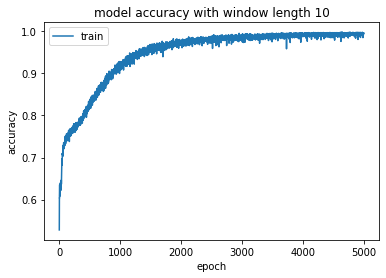

In [101]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

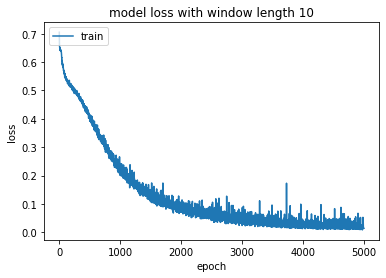

In [102]:
plt.plot(train_losses)
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [119]:
first_model.reset_states()
test_results = calc_pos_neg_rate(first_model.evaluate(x=test_generator, verbose=0))

In [120]:
first_model.reset_states()
train_results = calc_pos_neg_rate(first_model.evaluate(x=train_generator, verbose=0))

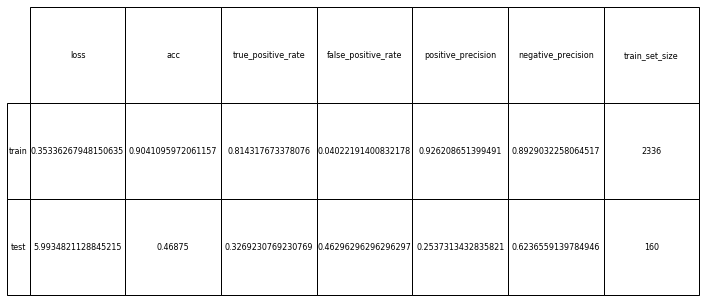

In [110]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Let's save this model for further use.

In [106]:
first_model.save(join(COLAB_DIR,'model_stateful.h5'))

Now, let's try window size of 20

In [125]:
train_generator, test_generator = generate_datasets_for_model(data, labels, \
                                                              stock_with_max_trading_days, \
                                                              training_start, training_end, \
                                                              testing_start, testing_end, window_in_days=20)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
second_model = build_model(None, optimizer, layers, metrics=metrics)
second_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (32, 64)                  17920     
_________________________________________________________________
dense_52 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_13 (Dropout)         (32, 32)                  0         
_________________________________________________________________
dense_53 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_13 (Batc (32, 16)                  64        
_________________________________________________________________
dense_54 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_55 (Dense)             (32, 1)                 

In [126]:
train_accs, train_losses = fit(second_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   2.048 seconds , loss : 0.697    accuracy : 0.577    
epoch 2
----------->> Epoch 1/1   0.612 seconds , loss : 0.660    accuracy : 0.615    
epoch 3
----------->> Epoch 1/1   0.555 seconds , loss : 0.661    accuracy : 0.602    
epoch 4
----------->> Epoch 1/1   0.446 seconds , loss : 0.655    accuracy : 0.610    
epoch 5
----------->> Epoch 1/1   0.495 seconds , loss : 0.655    accuracy : 0.609    
epoch 6
----------->> Epoch 1/1   0.338 seconds , loss : 0.648    accuracy : 0.616    
epoch 7
----------->> Epoch 1/1   0.340 seconds , loss : 0.646    accuracy : 0.625    
epoch 8
----------->> Epoch 1/1   0.383 seconds , loss : 0.644    accuracy : 0.637    
epoch 9
----------->> Epoch 1/1   0.400 seconds , loss : 0.645    accuracy : 0.627    
epoch 10
----------->> Epoch 1/1   0.552 seconds , loss : 0.645    accuracy : 0.626    
epoch 11
----------->> Epoch 1/1   0.608 seconds , loss : 0.644    accuracy : 0.633    
epoch 12
----------->> Epoch 1/1   0.491 

----------->> Epoch 1/1   0.384 seconds , loss : 0.542    accuracy : 0.738    
epoch 95
----------->> Epoch 1/1   0.314 seconds , loss : 0.538    accuracy : 0.742    
epoch 96
----------->> Epoch 1/1   0.268 seconds , loss : 0.536    accuracy : 0.744    
epoch 97
----------->> Epoch 1/1   0.417 seconds , loss : 0.540    accuracy : 0.745    
epoch 98
----------->> Epoch 1/1   0.400 seconds , loss : 0.537    accuracy : 0.745    
epoch 99
----------->> Epoch 1/1   0.401 seconds , loss : 0.533    accuracy : 0.742    
epoch 100
----------->> Epoch 1/1   0.479 seconds , loss : 0.529    accuracy : 0.752    
epoch 101
----------->> Epoch 1/1   0.527 seconds , loss : 0.526    accuracy : 0.756    
epoch 102
----------->> Epoch 1/1   0.469 seconds , loss : 0.530    accuracy : 0.752    
epoch 103
----------->> Epoch 1/1   0.369 seconds , loss : 0.534    accuracy : 0.748    
epoch 104
----------->> Epoch 1/1   0.583 seconds , loss : 0.531    accuracy : 0.741    
epoch 105
----------->> Epoch 1/1   

----------->> Epoch 1/1   0.236 seconds , loss : 0.491    accuracy : 0.773    
epoch 187
----------->> Epoch 1/1   0.277 seconds , loss : 0.490    accuracy : 0.775    
epoch 188
----------->> Epoch 1/1   0.247 seconds , loss : 0.486    accuracy : 0.783    
epoch 189
----------->> Epoch 1/1   0.441 seconds , loss : 0.490    accuracy : 0.777    
epoch 190
----------->> Epoch 1/1   0.268 seconds , loss : 0.494    accuracy : 0.771    
epoch 191
----------->> Epoch 1/1   0.500 seconds , loss : 0.480    accuracy : 0.775    
epoch 192
----------->> Epoch 1/1   0.327 seconds , loss : 0.488    accuracy : 0.774    
epoch 193
----------->> Epoch 1/1   0.376 seconds , loss : 0.486    accuracy : 0.780    
epoch 194
----------->> Epoch 1/1   0.425 seconds , loss : 0.484    accuracy : 0.777    
epoch 195
----------->> Epoch 1/1   0.304 seconds , loss : 0.483    accuracy : 0.781    
epoch 196
----------->> Epoch 1/1   0.287 seconds , loss : 0.495    accuracy : 0.770    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.396 seconds , loss : 0.443    accuracy : 0.805    
epoch 279
----------->> Epoch 1/1   0.244 seconds , loss : 0.431    accuracy : 0.814    
epoch 280
----------->> Epoch 1/1   0.318 seconds , loss : 0.453    accuracy : 0.790    
epoch 281
----------->> Epoch 1/1   0.366 seconds , loss : 0.443    accuracy : 0.812    
epoch 282
----------->> Epoch 1/1   0.297 seconds , loss : 0.440    accuracy : 0.803    
epoch 283
----------->> Epoch 1/1   0.400 seconds , loss : 0.438    accuracy : 0.808    
epoch 284
----------->> Epoch 1/1   0.324 seconds , loss : 0.437    accuracy : 0.807    
epoch 285
----------->> Epoch 1/1   0.315 seconds , loss : 0.436    accuracy : 0.808    
epoch 286
----------->> Epoch 1/1   0.589 seconds , loss : 0.434    accuracy : 0.812    
epoch 287
----------->> Epoch 1/1   0.230 seconds , loss : 0.435    accuracy : 0.807    
epoch 288
----------->> Epoch 1/1   0.380 seconds , loss : 0.432    accuracy : 0.804    
epoch 289
----------->> Epoch 1

----------->> Epoch 1/1   0.324 seconds , loss : 0.385    accuracy : 0.826    
epoch 371
----------->> Epoch 1/1   0.321 seconds , loss : 0.381    accuracy : 0.837    
epoch 372
----------->> Epoch 1/1   0.604 seconds , loss : 0.364    accuracy : 0.848    
epoch 373
----------->> Epoch 1/1   0.533 seconds , loss : 0.377    accuracy : 0.848    
epoch 374
----------->> Epoch 1/1   0.326 seconds , loss : 0.381    accuracy : 0.834    
epoch 375
----------->> Epoch 1/1   0.323 seconds , loss : 0.386    accuracy : 0.838    
epoch 376
----------->> Epoch 1/1   0.224 seconds , loss : 0.371    accuracy : 0.845    
epoch 377
----------->> Epoch 1/1   0.241 seconds , loss : 0.372    accuracy : 0.842    
epoch 378
----------->> Epoch 1/1   0.461 seconds , loss : 0.361    accuracy : 0.850    
epoch 379
----------->> Epoch 1/1   0.269 seconds , loss : 0.376    accuracy : 0.850    
epoch 380
----------->> Epoch 1/1   0.234 seconds , loss : 0.365    accuracy : 0.850    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.273 seconds , loss : 0.335    accuracy : 0.864    
epoch 463
----------->> Epoch 1/1   0.293 seconds , loss : 0.324    accuracy : 0.869    
epoch 464
----------->> Epoch 1/1   0.367 seconds , loss : 0.330    accuracy : 0.874    
epoch 465
----------->> Epoch 1/1   0.448 seconds , loss : 0.330    accuracy : 0.867    
epoch 466
----------->> Epoch 1/1   0.306 seconds , loss : 0.322    accuracy : 0.876    
epoch 467
----------->> Epoch 1/1   0.334 seconds , loss : 0.318    accuracy : 0.875    
epoch 468
----------->> Epoch 1/1   0.251 seconds , loss : 0.324    accuracy : 0.869    
epoch 469
----------->> Epoch 1/1   0.237 seconds , loss : 0.326    accuracy : 0.872    
epoch 470
----------->> Epoch 1/1   0.568 seconds , loss : 0.318    accuracy : 0.872    
epoch 471
----------->> Epoch 1/1   0.238 seconds , loss : 0.333    accuracy : 0.862    
epoch 472
----------->> Epoch 1/1   0.240 seconds , loss : 0.305    accuracy : 0.881    
epoch 473
----------->> Epoch 1

----------->> Epoch 1/1   0.449 seconds , loss : 0.262    accuracy : 0.898    
epoch 555
----------->> Epoch 1/1   0.450 seconds , loss : 0.265    accuracy : 0.896    
epoch 556
----------->> Epoch 1/1   0.339 seconds , loss : 0.267    accuracy : 0.893    
epoch 557
----------->> Epoch 1/1   0.325 seconds , loss : 0.260    accuracy : 0.900    
epoch 558
----------->> Epoch 1/1   0.283 seconds , loss : 0.254    accuracy : 0.897    
epoch 559
----------->> Epoch 1/1   0.388 seconds , loss : 0.257    accuracy : 0.898    
epoch 560
----------->> Epoch 1/1   0.293 seconds , loss : 0.264    accuracy : 0.901    
epoch 561
----------->> Epoch 1/1   0.356 seconds , loss : 0.269    accuracy : 0.896    
epoch 562
----------->> Epoch 1/1   0.523 seconds , loss : 0.257    accuracy : 0.899    
epoch 563
----------->> Epoch 1/1   0.273 seconds , loss : 0.272    accuracy : 0.890    
epoch 564
----------->> Epoch 1/1   0.422 seconds , loss : 0.266    accuracy : 0.898    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.273 seconds , loss : 0.218    accuracy : 0.917    
epoch 647
----------->> Epoch 1/1   0.385 seconds , loss : 0.205    accuracy : 0.925    
epoch 648
----------->> Epoch 1/1   0.574 seconds , loss : 0.224    accuracy : 0.914    
epoch 649
----------->> Epoch 1/1   0.482 seconds , loss : 0.225    accuracy : 0.920    
epoch 650
----------->> Epoch 1/1   0.367 seconds , loss : 0.205    accuracy : 0.921    
epoch 651
----------->> Epoch 1/1   0.310 seconds , loss : 0.206    accuracy : 0.925    
epoch 652
----------->> Epoch 1/1   0.278 seconds , loss : 0.221    accuracy : 0.910    
epoch 653
----------->> Epoch 1/1   0.450 seconds , loss : 0.207    accuracy : 0.926    
epoch 654
----------->> Epoch 1/1   0.383 seconds , loss : 0.216    accuracy : 0.913    
epoch 655
----------->> Epoch 1/1   0.494 seconds , loss : 0.218    accuracy : 0.911    
epoch 656
----------->> Epoch 1/1   0.301 seconds , loss : 0.265    accuracy : 0.905    
epoch 657
----------->> Epoch 1

----------->> Epoch 1/1   0.369 seconds , loss : 0.186    accuracy : 0.932    
epoch 739
----------->> Epoch 1/1   0.367 seconds , loss : 0.186    accuracy : 0.931    
epoch 740
----------->> Epoch 1/1   0.312 seconds , loss : 0.187    accuracy : 0.934    
epoch 741
----------->> Epoch 1/1   0.461 seconds , loss : 0.211    accuracy : 0.920    
epoch 742
----------->> Epoch 1/1   0.454 seconds , loss : 0.200    accuracy : 0.929    
epoch 743
----------->> Epoch 1/1   0.354 seconds , loss : 0.173    accuracy : 0.942    
epoch 744
----------->> Epoch 1/1   0.251 seconds , loss : 0.181    accuracy : 0.939    
epoch 745
----------->> Epoch 1/1   0.365 seconds , loss : 0.176    accuracy : 0.932    
epoch 746
----------->> Epoch 1/1   0.388 seconds , loss : 0.181    accuracy : 0.933    
epoch 747
----------->> Epoch 1/1   0.242 seconds , loss : 0.180    accuracy : 0.937    
epoch 748
----------->> Epoch 1/1   0.239 seconds , loss : 0.180    accuracy : 0.933    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.229 seconds , loss : 0.204    accuracy : 0.923    
epoch 831
----------->> Epoch 1/1   0.414 seconds , loss : 0.180    accuracy : 0.938    
epoch 832
----------->> Epoch 1/1   0.353 seconds , loss : 0.166    accuracy : 0.942    
epoch 833
----------->> Epoch 1/1   0.236 seconds , loss : 0.158    accuracy : 0.949    
epoch 834
----------->> Epoch 1/1   0.227 seconds , loss : 0.149    accuracy : 0.953    
epoch 835
----------->> Epoch 1/1   0.398 seconds , loss : 0.152    accuracy : 0.940    
epoch 836
----------->> Epoch 1/1   0.237 seconds , loss : 0.161    accuracy : 0.943    
epoch 837
----------->> Epoch 1/1   0.482 seconds , loss : 0.163    accuracy : 0.944    
epoch 838
----------->> Epoch 1/1   0.444 seconds , loss : 0.150    accuracy : 0.952    
epoch 839
----------->> Epoch 1/1   0.347 seconds , loss : 0.167    accuracy : 0.944    
epoch 840
----------->> Epoch 1/1   0.240 seconds , loss : 0.151    accuracy : 0.943    
epoch 841
----------->> Epoch 1

----------->> Epoch 1/1   0.693 seconds , loss : 0.137    accuracy : 0.953    
epoch 923
----------->> Epoch 1/1   0.472 seconds , loss : 0.134    accuracy : 0.957    
epoch 924
----------->> Epoch 1/1   0.385 seconds , loss : 0.157    accuracy : 0.949    
epoch 925
----------->> Epoch 1/1   0.341 seconds , loss : 0.147    accuracy : 0.949    
epoch 926
----------->> Epoch 1/1   0.423 seconds , loss : 0.145    accuracy : 0.952    
epoch 927
----------->> Epoch 1/1   0.362 seconds , loss : 0.130    accuracy : 0.958    
epoch 928
----------->> Epoch 1/1   0.403 seconds , loss : 0.127    accuracy : 0.955    
epoch 929
----------->> Epoch 1/1   0.531 seconds , loss : 0.136    accuracy : 0.950    
epoch 930
----------->> Epoch 1/1   0.327 seconds , loss : 0.151    accuracy : 0.952    
epoch 931
----------->> Epoch 1/1   0.409 seconds , loss : 0.123    accuracy : 0.958    
epoch 932
----------->> Epoch 1/1   0.433 seconds , loss : 0.143    accuracy : 0.954    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.469 seconds , loss : 0.101    accuracy : 0.961    
epoch 1015
----------->> Epoch 1/1   0.485 seconds , loss : 0.121    accuracy : 0.960    
epoch 1016
----------->> Epoch 1/1   0.480 seconds , loss : 0.110    accuracy : 0.964    
epoch 1017
----------->> Epoch 1/1   0.473 seconds , loss : 0.114    accuracy : 0.965    
epoch 1018
----------->> Epoch 1/1   0.471 seconds , loss : 0.129    accuracy : 0.954    
epoch 1019
----------->> Epoch 1/1   0.432 seconds , loss : 0.127    accuracy : 0.956    
epoch 1020
----------->> Epoch 1/1   0.478 seconds , loss : 0.107    accuracy : 0.961    
epoch 1021
----------->> Epoch 1/1   0.623 seconds , loss : 0.182    accuracy : 0.947    
epoch 1022
----------->> Epoch 1/1   0.491 seconds , loss : 0.165    accuracy : 0.947    
epoch 1023
----------->> Epoch 1/1   0.527 seconds , loss : 0.110    accuracy : 0.964    
epoch 1024
----------->> Epoch 1/1   0.498 seconds , loss : 0.105    accuracy : 0.970    
epoch 1025
----------

----------->> Epoch 1/1   0.557 seconds , loss : 0.100    accuracy : 0.969    
epoch 1106
----------->> Epoch 1/1   0.398 seconds , loss : 0.109    accuracy : 0.964    
epoch 1107
----------->> Epoch 1/1   0.271 seconds , loss : 0.094    accuracy : 0.970    
epoch 1108
----------->> Epoch 1/1   0.398 seconds , loss : 0.083    accuracy : 0.976    
epoch 1109
----------->> Epoch 1/1   0.379 seconds , loss : 0.081    accuracy : 0.972    
epoch 1110
----------->> Epoch 1/1   0.421 seconds , loss : 0.091    accuracy : 0.973    
epoch 1111
----------->> Epoch 1/1   0.593 seconds , loss : 0.102    accuracy : 0.962    
epoch 1112
----------->> Epoch 1/1   0.490 seconds , loss : 0.103    accuracy : 0.968    
epoch 1113
----------->> Epoch 1/1   0.372 seconds , loss : 0.135    accuracy : 0.955    
epoch 1114
----------->> Epoch 1/1   0.474 seconds , loss : 0.093    accuracy : 0.972    
epoch 1115
----------->> Epoch 1/1   0.424 seconds , loss : 0.088    accuracy : 0.972    
epoch 1116
----------

----------->> Epoch 1/1   0.454 seconds , loss : 0.072    accuracy : 0.982    
epoch 1197
----------->> Epoch 1/1   0.324 seconds , loss : 0.093    accuracy : 0.969    
epoch 1198
----------->> Epoch 1/1   0.467 seconds , loss : 0.133    accuracy : 0.959    
epoch 1199
----------->> Epoch 1/1   0.387 seconds , loss : 0.139    accuracy : 0.960    
epoch 1200
----------->> Epoch 1/1   0.544 seconds , loss : 0.106    accuracy : 0.966    
epoch 1201
----------->> Epoch 1/1   0.369 seconds , loss : 0.066    accuracy : 0.981    
epoch 1202
----------->> Epoch 1/1   0.335 seconds , loss : 0.083    accuracy : 0.970    
epoch 1203
----------->> Epoch 1/1   0.633 seconds , loss : 0.094    accuracy : 0.973    
epoch 1204
----------->> Epoch 1/1   0.603 seconds , loss : 0.107    accuracy : 0.965    
epoch 1205
----------->> Epoch 1/1   0.516 seconds , loss : 0.111    accuracy : 0.961    
epoch 1206
----------->> Epoch 1/1   0.329 seconds , loss : 0.119    accuracy : 0.960    
epoch 1207
----------

----------->> Epoch 1/1   0.406 seconds , loss : 0.080    accuracy : 0.978    
epoch 1288
----------->> Epoch 1/1   0.347 seconds , loss : 0.075    accuracy : 0.975    
epoch 1289
----------->> Epoch 1/1   0.392 seconds , loss : 0.071    accuracy : 0.975    
epoch 1290
----------->> Epoch 1/1   0.584 seconds , loss : 0.078    accuracy : 0.974    
epoch 1291
----------->> Epoch 1/1   0.544 seconds , loss : 0.079    accuracy : 0.975    
epoch 1292
----------->> Epoch 1/1   0.517 seconds , loss : 0.065    accuracy : 0.979    
epoch 1293
----------->> Epoch 1/1   0.276 seconds , loss : 0.078    accuracy : 0.978    
epoch 1294
----------->> Epoch 1/1   0.451 seconds , loss : 0.082    accuracy : 0.972    
epoch 1295
----------->> Epoch 1/1   0.284 seconds , loss : 0.098    accuracy : 0.971    
epoch 1296
----------->> Epoch 1/1   0.303 seconds , loss : 0.105    accuracy : 0.967    
epoch 1297
----------->> Epoch 1/1   0.607 seconds , loss : 0.110    accuracy : 0.963    
epoch 1298
----------

----------->> Epoch 1/1   0.684 seconds , loss : 0.096    accuracy : 0.969    
epoch 1379
----------->> Epoch 1/1   0.394 seconds , loss : 0.064    accuracy : 0.979    
epoch 1380
----------->> Epoch 1/1   0.529 seconds , loss : 0.063    accuracy : 0.979    
epoch 1381
----------->> Epoch 1/1   0.551 seconds , loss : 0.081    accuracy : 0.974    
epoch 1382
----------->> Epoch 1/1   0.588 seconds , loss : 0.076    accuracy : 0.976    
epoch 1383
----------->> Epoch 1/1   0.504 seconds , loss : 0.064    accuracy : 0.977    
epoch 1384
----------->> Epoch 1/1   0.567 seconds , loss : 0.057    accuracy : 0.982    
epoch 1385
----------->> Epoch 1/1   0.562 seconds , loss : 0.069    accuracy : 0.979    
epoch 1386
----------->> Epoch 1/1   0.559 seconds , loss : 0.077    accuracy : 0.977    
epoch 1387
----------->> Epoch 1/1   0.408 seconds , loss : 0.089    accuracy : 0.975    
epoch 1388
----------->> Epoch 1/1   0.548 seconds , loss : 0.086    accuracy : 0.974    
epoch 1389
----------

----------->> Epoch 1/1   0.628 seconds , loss : 0.095    accuracy : 0.967    
epoch 1470
----------->> Epoch 1/1   0.861 seconds , loss : 0.052    accuracy : 0.984    
epoch 1471
----------->> Epoch 1/1   0.652 seconds , loss : 0.036    accuracy : 0.989    
epoch 1472
----------->> Epoch 1/1   0.754 seconds , loss : 0.061    accuracy : 0.984    
epoch 1473
----------->> Epoch 1/1   0.598 seconds , loss : 0.058    accuracy : 0.982    
epoch 1474
----------->> Epoch 1/1   0.735 seconds , loss : 0.064    accuracy : 0.980    
epoch 1475
----------->> Epoch 1/1   0.814 seconds , loss : 0.054    accuracy : 0.985    
epoch 1476
----------->> Epoch 1/1   0.808 seconds , loss : 0.081    accuracy : 0.976    
epoch 1477
----------->> Epoch 1/1   0.906 seconds , loss : 0.086    accuracy : 0.976    
epoch 1478
----------->> Epoch 1/1   0.873 seconds , loss : 0.065    accuracy : 0.982    
epoch 1479
----------->> Epoch 1/1   0.620 seconds , loss : 0.041    accuracy : 0.990    
epoch 1480
----------

----------->> Epoch 1/1   0.411 seconds , loss : 0.051    accuracy : 0.984    
epoch 1561
----------->> Epoch 1/1   0.359 seconds , loss : 0.046    accuracy : 0.988    
epoch 1562
----------->> Epoch 1/1   0.398 seconds , loss : 0.044    accuracy : 0.987    
epoch 1563
----------->> Epoch 1/1   0.413 seconds , loss : 0.052    accuracy : 0.984    
epoch 1564
----------->> Epoch 1/1   0.607 seconds , loss : 0.036    accuracy : 0.986    
epoch 1565
----------->> Epoch 1/1   0.481 seconds , loss : 0.038    accuracy : 0.989    
epoch 1566
----------->> Epoch 1/1   0.379 seconds , loss : 0.040    accuracy : 0.988    
epoch 1567
----------->> Epoch 1/1   0.390 seconds , loss : 0.037    accuracy : 0.989    
epoch 1568
----------->> Epoch 1/1   0.356 seconds , loss : 0.032    accuracy : 0.988    
epoch 1569
----------->> Epoch 1/1   0.393 seconds , loss : 0.031    accuracy : 0.991    
epoch 1570
----------->> Epoch 1/1   0.395 seconds , loss : 0.048    accuracy : 0.982    
epoch 1571
----------

----------->> Epoch 1/1   0.366 seconds , loss : 0.017    accuracy : 0.995    
epoch 1652
----------->> Epoch 1/1   0.292 seconds , loss : 0.023    accuracy : 0.994    
epoch 1653
----------->> Epoch 1/1   0.388 seconds , loss : 0.028    accuracy : 0.993    
epoch 1654
----------->> Epoch 1/1   0.446 seconds , loss : 0.036    accuracy : 0.988    
epoch 1655
----------->> Epoch 1/1   0.400 seconds , loss : 0.043    accuracy : 0.987    
epoch 1656
----------->> Epoch 1/1   0.381 seconds , loss : 0.162    accuracy : 0.964    
epoch 1657
----------->> Epoch 1/1   0.415 seconds , loss : 0.108    accuracy : 0.967    
epoch 1658
----------->> Epoch 1/1   0.280 seconds , loss : 0.043    accuracy : 0.985    
epoch 1659
----------->> Epoch 1/1   0.523 seconds , loss : 0.041    accuracy : 0.986    
epoch 1660
----------->> Epoch 1/1   0.310 seconds , loss : 0.030    accuracy : 0.992    
epoch 1661
----------->> Epoch 1/1   0.351 seconds , loss : 0.037    accuracy : 0.989    
epoch 1662
----------

----------->> Epoch 1/1   0.631 seconds , loss : 0.039    accuracy : 0.989    
epoch 1743
----------->> Epoch 1/1   0.460 seconds , loss : 0.044    accuracy : 0.988    
epoch 1744
----------->> Epoch 1/1   0.562 seconds , loss : 0.036    accuracy : 0.988    
epoch 1745
----------->> Epoch 1/1   0.356 seconds , loss : 0.082    accuracy : 0.979    
epoch 1746
----------->> Epoch 1/1   0.340 seconds , loss : 0.052    accuracy : 0.982    
epoch 1747
----------->> Epoch 1/1   0.516 seconds , loss : 0.034    accuracy : 0.988    
epoch 1748
----------->> Epoch 1/1   0.475 seconds , loss : 0.039    accuracy : 0.985    
epoch 1749
----------->> Epoch 1/1   0.387 seconds , loss : 0.049    accuracy : 0.982    
epoch 1750
----------->> Epoch 1/1   0.675 seconds , loss : 0.047    accuracy : 0.984    
epoch 1751
----------->> Epoch 1/1   0.632 seconds , loss : 0.167    accuracy : 0.964    
epoch 1752
----------->> Epoch 1/1   0.499 seconds , loss : 0.052    accuracy : 0.982    
epoch 1753
----------

----------->> Epoch 1/1   0.330 seconds , loss : 0.021    accuracy : 0.994    
epoch 1834
----------->> Epoch 1/1   0.513 seconds , loss : 0.017    accuracy : 0.995    
epoch 1835
----------->> Epoch 1/1   0.706 seconds , loss : 0.021    accuracy : 0.992    
epoch 1836
----------->> Epoch 1/1   0.708 seconds , loss : 0.143    accuracy : 0.969    
epoch 1837
----------->> Epoch 1/1   0.692 seconds , loss : 0.088    accuracy : 0.976    
epoch 1838
----------->> Epoch 1/1   0.762 seconds , loss : 0.031    accuracy : 0.990    
epoch 1839
----------->> Epoch 1/1   0.617 seconds , loss : 0.022    accuracy : 0.994    
epoch 1840
----------->> Epoch 1/1   0.434 seconds , loss : 0.040    accuracy : 0.988    
epoch 1841
----------->> Epoch 1/1   0.476 seconds , loss : 0.025    accuracy : 0.994    
epoch 1842
----------->> Epoch 1/1   0.626 seconds , loss : 0.019    accuracy : 0.994    
epoch 1843
----------->> Epoch 1/1   0.413 seconds , loss : 0.015    accuracy : 0.996    
epoch 1844
----------

----------->> Epoch 1/1   0.313 seconds , loss : 0.012    accuracy : 0.997    
epoch 1925
----------->> Epoch 1/1   0.541 seconds , loss : 0.019    accuracy : 0.995    
epoch 1926
----------->> Epoch 1/1   0.609 seconds , loss : 0.034    accuracy : 0.989    
epoch 1927
----------->> Epoch 1/1   0.507 seconds , loss : 0.084    accuracy : 0.976    
epoch 1928
----------->> Epoch 1/1   0.671 seconds , loss : 0.032    accuracy : 0.988    
epoch 1929
----------->> Epoch 1/1   0.778 seconds , loss : 0.023    accuracy : 0.994    
epoch 1930
----------->> Epoch 1/1   0.573 seconds , loss : 0.020    accuracy : 0.993    
epoch 1931
----------->> Epoch 1/1   0.519 seconds , loss : 0.018    accuracy : 0.993    
epoch 1932
----------->> Epoch 1/1   0.527 seconds , loss : 0.017    accuracy : 0.994    
epoch 1933
----------->> Epoch 1/1   0.581 seconds , loss : 0.042    accuracy : 0.988    
epoch 1934
----------->> Epoch 1/1   0.481 seconds , loss : 0.052    accuracy : 0.982    
epoch 1935
----------

----------->> Epoch 1/1   0.333 seconds , loss : 0.059    accuracy : 0.985    
epoch 2016
----------->> Epoch 1/1   0.456 seconds , loss : 0.054    accuracy : 0.985    
epoch 2017
----------->> Epoch 1/1   0.419 seconds , loss : 0.045    accuracy : 0.988    
epoch 2018
----------->> Epoch 1/1   0.277 seconds , loss : 0.028    accuracy : 0.991    
epoch 2019
----------->> Epoch 1/1   0.449 seconds , loss : 0.024    accuracy : 0.994    
epoch 2020
----------->> Epoch 1/1   0.405 seconds , loss : 0.013    accuracy : 0.997    
epoch 2021
----------->> Epoch 1/1   0.541 seconds , loss : 0.012    accuracy : 0.998    
epoch 2022
----------->> Epoch 1/1   0.378 seconds , loss : 0.015    accuracy : 0.997    
epoch 2023
----------->> Epoch 1/1   0.484 seconds , loss : 0.010    accuracy : 0.997    
epoch 2024
----------->> Epoch 1/1   0.280 seconds , loss : 0.011    accuracy : 0.998    
epoch 2025
----------->> Epoch 1/1   0.443 seconds , loss : 0.011    accuracy : 0.997    
epoch 2026
----------

----------->> Epoch 1/1   0.555 seconds , loss : 0.018    accuracy : 0.994    
epoch 2107
----------->> Epoch 1/1   0.302 seconds , loss : 0.020    accuracy : 0.994    
epoch 2108
----------->> Epoch 1/1   0.528 seconds , loss : 0.064    accuracy : 0.981    
epoch 2109
----------->> Epoch 1/1   0.534 seconds , loss : 0.100    accuracy : 0.969    
epoch 2110
----------->> Epoch 1/1   0.355 seconds , loss : 0.113    accuracy : 0.968    
epoch 2111
----------->> Epoch 1/1   0.329 seconds , loss : 0.070    accuracy : 0.975    
epoch 2112
----------->> Epoch 1/1   0.275 seconds , loss : 0.036    accuracy : 0.988    
epoch 2113
----------->> Epoch 1/1   0.446 seconds , loss : 0.033    accuracy : 0.988    
epoch 2114
----------->> Epoch 1/1   0.369 seconds , loss : 0.019    accuracy : 0.994    
epoch 2115
----------->> Epoch 1/1   0.416 seconds , loss : 0.012    accuracy : 0.998    
epoch 2116
----------->> Epoch 1/1   0.346 seconds , loss : 0.014    accuracy : 0.997    
epoch 2117
----------

----------->> Epoch 1/1   0.640 seconds , loss : 0.017    accuracy : 0.995    
epoch 2198
----------->> Epoch 1/1   0.677 seconds , loss : 0.014    accuracy : 0.996    
epoch 2199
----------->> Epoch 1/1   0.568 seconds , loss : 0.018    accuracy : 0.995    
epoch 2200
----------->> Epoch 1/1   0.731 seconds , loss : 0.041    accuracy : 0.990    
epoch 2201
----------->> Epoch 1/1   0.690 seconds , loss : 0.037    accuracy : 0.988    
epoch 2202
----------->> Epoch 1/1   0.480 seconds , loss : 0.084    accuracy : 0.980    
epoch 2203
----------->> Epoch 1/1   0.398 seconds , loss : 0.047    accuracy : 0.988    
epoch 2204
----------->> Epoch 1/1   0.530 seconds , loss : 0.021    accuracy : 0.994    
epoch 2205
----------->> Epoch 1/1   0.422 seconds , loss : 0.013    accuracy : 0.997    
epoch 2206
----------->> Epoch 1/1   0.534 seconds , loss : 0.011    accuracy : 0.997    
epoch 2207
----------->> Epoch 1/1   0.744 seconds , loss : 0.012    accuracy : 0.996    
epoch 2208
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.009    accuracy : 0.999    
epoch 2289
----------->> Epoch 1/1   0.300 seconds , loss : 0.011    accuracy : 0.997    
epoch 2290
----------->> Epoch 1/1   0.306 seconds , loss : 0.012    accuracy : 0.996    
epoch 2291
----------->> Epoch 1/1   0.269 seconds , loss : 0.069    accuracy : 0.985    
epoch 2292
----------->> Epoch 1/1   0.530 seconds , loss : 0.086    accuracy : 0.976    
epoch 2293
----------->> Epoch 1/1   0.594 seconds , loss : 0.044    accuracy : 0.988    
epoch 2294
----------->> Epoch 1/1   0.327 seconds , loss : 0.022    accuracy : 0.993    
epoch 2295
----------->> Epoch 1/1   0.549 seconds , loss : 0.015    accuracy : 0.997    
epoch 2296
----------->> Epoch 1/1   0.586 seconds , loss : 0.012    accuracy : 0.997    
epoch 2297
----------->> Epoch 1/1   0.441 seconds , loss : 0.010    accuracy : 0.997    
epoch 2298
----------->> Epoch 1/1   0.339 seconds , loss : 0.011    accuracy : 0.996    
epoch 2299
----------

----------->> Epoch 1/1   0.507 seconds , loss : 0.029    accuracy : 0.992    
epoch 2380
----------->> Epoch 1/1   0.276 seconds , loss : 0.020    accuracy : 0.996    
epoch 2381
----------->> Epoch 1/1   0.486 seconds , loss : 0.012    accuracy : 0.997    
epoch 2382
----------->> Epoch 1/1   0.399 seconds , loss : 0.009    accuracy : 0.998    
epoch 2383
----------->> Epoch 1/1   0.417 seconds , loss : 0.010    accuracy : 0.998    
epoch 2384
----------->> Epoch 1/1   0.426 seconds , loss : 0.011    accuracy : 0.998    
epoch 2385
----------->> Epoch 1/1   0.417 seconds , loss : 0.008    accuracy : 0.997    
epoch 2386
----------->> Epoch 1/1   0.491 seconds , loss : 0.009    accuracy : 0.998    
epoch 2387
----------->> Epoch 1/1   0.665 seconds , loss : 0.007    accuracy : 0.998    
epoch 2388
----------->> Epoch 1/1   0.319 seconds , loss : 0.008    accuracy : 0.997    
epoch 2389
----------->> Epoch 1/1   0.470 seconds , loss : 0.010    accuracy : 0.997    
epoch 2390
----------

----------->> Epoch 1/1   0.356 seconds , loss : 0.008    accuracy : 0.998    
epoch 2471
----------->> Epoch 1/1   0.570 seconds , loss : 0.008    accuracy : 0.997    
epoch 2472
----------->> Epoch 1/1   0.392 seconds , loss : 0.009    accuracy : 0.997    
epoch 2473
----------->> Epoch 1/1   0.718 seconds , loss : 0.011    accuracy : 0.997    
epoch 2474
----------->> Epoch 1/1   1.011 seconds , loss : 0.009    accuracy : 0.998    
epoch 2475
----------->> Epoch 1/1   1.116 seconds , loss : 0.009    accuracy : 0.998    
epoch 2476
----------->> Epoch 1/1   1.030 seconds , loss : 0.009    accuracy : 0.999    
epoch 2477
----------->> Epoch 1/1   0.448 seconds , loss : 0.009    accuracy : 0.998    
epoch 2478
----------->> Epoch 1/1   0.371 seconds , loss : 0.009    accuracy : 0.997    
epoch 2479
----------->> Epoch 1/1   0.298 seconds , loss : 0.010    accuracy : 0.997    
epoch 2480
----------->> Epoch 1/1   0.563 seconds , loss : 0.013    accuracy : 0.996    
epoch 2481
----------

----------->> Epoch 1/1   0.719 seconds , loss : 0.010    accuracy : 0.998    
epoch 2562
----------->> Epoch 1/1   0.331 seconds , loss : 0.012    accuracy : 0.996    
epoch 2563
----------->> Epoch 1/1   0.494 seconds , loss : 0.013    accuracy : 0.995    
epoch 2564
----------->> Epoch 1/1   0.406 seconds , loss : 0.010    accuracy : 0.997    
epoch 2565
----------->> Epoch 1/1   0.653 seconds , loss : 0.021    accuracy : 0.994    
epoch 2566
----------->> Epoch 1/1   0.672 seconds , loss : 0.039    accuracy : 0.990    
epoch 2567
----------->> Epoch 1/1   0.361 seconds , loss : 0.020    accuracy : 0.992    
epoch 2568
----------->> Epoch 1/1   0.539 seconds , loss : 0.013    accuracy : 0.998    
epoch 2569
----------->> Epoch 1/1   0.620 seconds , loss : 0.018    accuracy : 0.996    
epoch 2570
----------->> Epoch 1/1   0.508 seconds , loss : 0.015    accuracy : 0.995    
epoch 2571
----------->> Epoch 1/1   0.360 seconds , loss : 0.013    accuracy : 0.996    
epoch 2572
----------

----------->> Epoch 1/1   0.992 seconds , loss : 0.021    accuracy : 0.994    
epoch 2653
----------->> Epoch 1/1   0.767 seconds , loss : 0.016    accuracy : 0.996    
epoch 2654
----------->> Epoch 1/1   0.770 seconds , loss : 0.010    accuracy : 0.997    
epoch 2655
----------->> Epoch 1/1   0.852 seconds , loss : 0.011    accuracy : 0.997    
epoch 2656
----------->> Epoch 1/1   0.843 seconds , loss : 0.009    accuracy : 0.997    
epoch 2657
----------->> Epoch 1/1   0.632 seconds , loss : 0.009    accuracy : 0.997    
epoch 2658
----------->> Epoch 1/1   0.640 seconds , loss : 0.009    accuracy : 0.997    
epoch 2659
----------->> Epoch 1/1   0.540 seconds , loss : 0.008    accuracy : 0.997    
epoch 2660
----------->> Epoch 1/1   0.322 seconds , loss : 0.007    accuracy : 0.998    
epoch 2661
----------->> Epoch 1/1   0.380 seconds , loss : 0.007    accuracy : 0.998    
epoch 2662
----------->> Epoch 1/1   0.596 seconds , loss : 0.007    accuracy : 0.997    
epoch 2663
----------

----------->> Epoch 1/1   0.451 seconds , loss : 0.011    accuracy : 0.995    
epoch 2744
----------->> Epoch 1/1   0.485 seconds , loss : 0.010    accuracy : 0.997    
epoch 2745
----------->> Epoch 1/1   0.454 seconds , loss : 0.010    accuracy : 0.997    
epoch 2746
----------->> Epoch 1/1   0.408 seconds , loss : 0.009    accuracy : 0.998    
epoch 2747
----------->> Epoch 1/1   0.397 seconds , loss : 0.009    accuracy : 0.997    
epoch 2748
----------->> Epoch 1/1   0.308 seconds , loss : 0.007    accuracy : 0.998    
epoch 2749
----------->> Epoch 1/1   0.390 seconds , loss : 0.008    accuracy : 0.997    
epoch 2750
----------->> Epoch 1/1   0.322 seconds , loss : 0.008    accuracy : 0.998    
epoch 2751
----------->> Epoch 1/1   0.326 seconds , loss : 0.009    accuracy : 0.997    
epoch 2752
----------->> Epoch 1/1   0.574 seconds , loss : 0.011    accuracy : 0.997    
epoch 2753
----------->> Epoch 1/1   0.315 seconds , loss : 0.016    accuracy : 0.995    
epoch 2754
----------

----------->> Epoch 1/1   0.287 seconds , loss : 0.008    accuracy : 0.998    
epoch 2835
----------->> Epoch 1/1   0.278 seconds , loss : 0.006    accuracy : 0.999    
epoch 2836
----------->> Epoch 1/1   0.245 seconds , loss : 0.007    accuracy : 0.998    
epoch 2837
----------->> Epoch 1/1   0.312 seconds , loss : 0.007    accuracy : 0.999    
epoch 2838
----------->> Epoch 1/1   0.274 seconds , loss : 0.007    accuracy : 0.998    
epoch 2839
----------->> Epoch 1/1   0.278 seconds , loss : 0.010    accuracy : 0.997    
epoch 2840
----------->> Epoch 1/1   0.244 seconds , loss : 0.008    accuracy : 0.998    
epoch 2841
----------->> Epoch 1/1   0.284 seconds , loss : 0.007    accuracy : 0.997    
epoch 2842
----------->> Epoch 1/1   0.239 seconds , loss : 0.009    accuracy : 0.998    
epoch 2843
----------->> Epoch 1/1   0.251 seconds , loss : 0.038    accuracy : 0.991    
epoch 2844
----------->> Epoch 1/1   0.242 seconds , loss : 0.173    accuracy : 0.963    
epoch 2845
----------

----------->> Epoch 1/1   0.266 seconds , loss : 0.009    accuracy : 0.998    
epoch 2926
----------->> Epoch 1/1   0.248 seconds , loss : 0.008    accuracy : 0.997    
epoch 2927
----------->> Epoch 1/1   0.251 seconds , loss : 0.007    accuracy : 0.997    
epoch 2928
----------->> Epoch 1/1   0.243 seconds , loss : 0.006    accuracy : 0.998    
epoch 2929
----------->> Epoch 1/1   0.258 seconds , loss : 0.008    accuracy : 0.999    
epoch 2930
----------->> Epoch 1/1   0.294 seconds , loss : 0.007    accuracy : 0.997    
epoch 2931
----------->> Epoch 1/1   0.248 seconds , loss : 0.006    accuracy : 0.997    
epoch 2932
----------->> Epoch 1/1   0.241 seconds , loss : 0.006    accuracy : 0.998    
epoch 2933
----------->> Epoch 1/1   0.240 seconds , loss : 0.007    accuracy : 0.997    
epoch 2934
----------->> Epoch 1/1   0.246 seconds , loss : 0.029    accuracy : 0.993    
epoch 2935
----------->> Epoch 1/1   0.258 seconds , loss : 0.064    accuracy : 0.985    
epoch 2936
----------

----------->> Epoch 1/1   0.289 seconds , loss : 0.008    accuracy : 0.998    
epoch 3017
----------->> Epoch 1/1   0.272 seconds , loss : 0.008    accuracy : 0.997    
epoch 3018
----------->> Epoch 1/1   0.297 seconds , loss : 0.007    accuracy : 0.998    
epoch 3019
----------->> Epoch 1/1   0.281 seconds , loss : 0.009    accuracy : 0.998    
epoch 3020
----------->> Epoch 1/1   0.300 seconds , loss : 0.010    accuracy : 0.996    
epoch 3021
----------->> Epoch 1/1   0.354 seconds , loss : 0.009    accuracy : 0.998    
epoch 3022
----------->> Epoch 1/1   0.333 seconds , loss : 0.007    accuracy : 0.997    
epoch 3023
----------->> Epoch 1/1   0.275 seconds , loss : 0.008    accuracy : 0.998    
epoch 3024
----------->> Epoch 1/1   0.265 seconds , loss : 0.008    accuracy : 0.998    
epoch 3025
----------->> Epoch 1/1   0.253 seconds , loss : 0.008    accuracy : 0.997    
epoch 3026
----------->> Epoch 1/1   0.271 seconds , loss : 0.008    accuracy : 0.997    
epoch 3027
----------

----------->> Epoch 1/1   0.250 seconds , loss : 0.113    accuracy : 0.972    
epoch 3108
----------->> Epoch 1/1   0.302 seconds , loss : 0.047    accuracy : 0.984    
epoch 3109
----------->> Epoch 1/1   0.325 seconds , loss : 0.031    accuracy : 0.991    
epoch 3110
----------->> Epoch 1/1   0.270 seconds , loss : 0.018    accuracy : 0.995    
epoch 3111
----------->> Epoch 1/1   0.325 seconds , loss : 0.010    accuracy : 0.996    
epoch 3112
----------->> Epoch 1/1   0.245 seconds , loss : 0.014    accuracy : 0.997    
epoch 3113
----------->> Epoch 1/1   0.296 seconds , loss : 0.011    accuracy : 0.997    
epoch 3114
----------->> Epoch 1/1   0.242 seconds , loss : 0.009    accuracy : 0.997    
epoch 3115
----------->> Epoch 1/1   0.248 seconds , loss : 0.009    accuracy : 0.997    
epoch 3116
----------->> Epoch 1/1   0.285 seconds , loss : 0.008    accuracy : 0.997    
epoch 3117
----------->> Epoch 1/1   0.259 seconds , loss : 0.024    accuracy : 0.994    
epoch 3118
----------

----------->> Epoch 1/1   0.252 seconds , loss : 0.012    accuracy : 0.997    
epoch 3199
----------->> Epoch 1/1   0.250 seconds , loss : 0.009    accuracy : 0.997    
epoch 3200
----------->> Epoch 1/1   0.254 seconds , loss : 0.008    accuracy : 0.998    
epoch 3201
----------->> Epoch 1/1   0.253 seconds , loss : 0.008    accuracy : 0.998    
epoch 3202
----------->> Epoch 1/1   0.256 seconds , loss : 0.007    accuracy : 0.998    
epoch 3203
----------->> Epoch 1/1   0.252 seconds , loss : 0.008    accuracy : 0.998    
epoch 3204
----------->> Epoch 1/1   0.300 seconds , loss : 0.007    accuracy : 0.998    
epoch 3205
----------->> Epoch 1/1   0.308 seconds , loss : 0.009    accuracy : 0.998    
epoch 3206
----------->> Epoch 1/1   0.288 seconds , loss : 0.007    accuracy : 0.998    
epoch 3207
----------->> Epoch 1/1   0.301 seconds , loss : 0.008    accuracy : 0.997    
epoch 3208
----------->> Epoch 1/1   0.296 seconds , loss : 0.007    accuracy : 0.998    
epoch 3209
----------

----------->> Epoch 1/1   0.253 seconds , loss : 0.009    accuracy : 0.997    
epoch 3290
----------->> Epoch 1/1   0.249 seconds , loss : 0.010    accuracy : 0.997    
epoch 3291
----------->> Epoch 1/1   0.254 seconds , loss : 0.006    accuracy : 0.997    
epoch 3292
----------->> Epoch 1/1   0.252 seconds , loss : 0.007    accuracy : 0.997    
epoch 3293
----------->> Epoch 1/1   0.257 seconds , loss : 0.008    accuracy : 0.998    
epoch 3294
----------->> Epoch 1/1   0.252 seconds , loss : 0.008    accuracy : 0.997    
epoch 3295
----------->> Epoch 1/1   0.249 seconds , loss : 0.009    accuracy : 0.997    
epoch 3296
----------->> Epoch 1/1   0.259 seconds , loss : 0.012    accuracy : 0.997    
epoch 3297
----------->> Epoch 1/1   0.251 seconds , loss : 0.021    accuracy : 0.991    
epoch 3298
----------->> Epoch 1/1   0.256 seconds , loss : 0.139    accuracy : 0.970    
epoch 3299
----------->> Epoch 1/1   0.251 seconds , loss : 0.058    accuracy : 0.980    
epoch 3300
----------

----------->> Epoch 1/1   0.301 seconds , loss : 0.018    accuracy : 0.995    
epoch 3381
----------->> Epoch 1/1   0.300 seconds , loss : 0.014    accuracy : 0.995    
epoch 3382
----------->> Epoch 1/1   0.309 seconds , loss : 0.023    accuracy : 0.993    
epoch 3383
----------->> Epoch 1/1   0.307 seconds , loss : 0.058    accuracy : 0.988    
epoch 3384
----------->> Epoch 1/1   0.296 seconds , loss : 0.019    accuracy : 0.993    
epoch 3385
----------->> Epoch 1/1   0.304 seconds , loss : 0.032    accuracy : 0.990    
epoch 3386
----------->> Epoch 1/1   0.303 seconds , loss : 0.023    accuracy : 0.992    
epoch 3387
----------->> Epoch 1/1   0.293 seconds , loss : 0.016    accuracy : 0.994    
epoch 3388
----------->> Epoch 1/1   0.293 seconds , loss : 0.009    accuracy : 0.998    
epoch 3389
----------->> Epoch 1/1   0.294 seconds , loss : 0.015    accuracy : 0.995    
epoch 3390
----------->> Epoch 1/1   0.275 seconds , loss : 0.046    accuracy : 0.988    
epoch 3391
----------

----------->> Epoch 1/1   0.287 seconds , loss : 0.132    accuracy : 0.964    
epoch 3472
----------->> Epoch 1/1   0.257 seconds , loss : 0.036    accuracy : 0.989    
epoch 3473
----------->> Epoch 1/1   0.303 seconds , loss : 0.022    accuracy : 0.991    
epoch 3474
----------->> Epoch 1/1   0.305 seconds , loss : 0.011    accuracy : 0.997    
epoch 3475
----------->> Epoch 1/1   0.284 seconds , loss : 0.011    accuracy : 0.997    
epoch 3476
----------->> Epoch 1/1   0.294 seconds , loss : 0.008    accuracy : 0.998    
epoch 3477
----------->> Epoch 1/1   0.317 seconds , loss : 0.008    accuracy : 0.998    
epoch 3478
----------->> Epoch 1/1   0.339 seconds , loss : 0.007    accuracy : 0.998    
epoch 3479
----------->> Epoch 1/1   0.353 seconds , loss : 0.008    accuracy : 0.998    
epoch 3480
----------->> Epoch 1/1   0.320 seconds , loss : 0.008    accuracy : 0.997    
epoch 3481
----------->> Epoch 1/1   0.316 seconds , loss : 0.011    accuracy : 0.997    
epoch 3482
----------

----------->> Epoch 1/1   0.324 seconds , loss : 0.008    accuracy : 0.997    
epoch 3563
----------->> Epoch 1/1   0.316 seconds , loss : 0.008    accuracy : 0.998    
epoch 3564
----------->> Epoch 1/1   0.311 seconds , loss : 0.008    accuracy : 0.997    
epoch 3565
----------->> Epoch 1/1   0.317 seconds , loss : 0.008    accuracy : 0.998    
epoch 3566
----------->> Epoch 1/1   0.263 seconds , loss : 0.008    accuracy : 0.997    
epoch 3567
----------->> Epoch 1/1   0.254 seconds , loss : 0.027    accuracy : 0.993    
epoch 3568
----------->> Epoch 1/1   0.252 seconds , loss : 0.017    accuracy : 0.995    
epoch 3569
----------->> Epoch 1/1   0.252 seconds , loss : 0.019    accuracy : 0.994    
epoch 3570
----------->> Epoch 1/1   0.310 seconds , loss : 0.011    accuracy : 0.997    
epoch 3571
----------->> Epoch 1/1   0.255 seconds , loss : 0.012    accuracy : 0.996    
epoch 3572
----------->> Epoch 1/1   0.253 seconds , loss : 0.024    accuracy : 0.994    
epoch 3573
----------

----------->> Epoch 1/1   0.260 seconds , loss : 0.007    accuracy : 0.998    
epoch 3654
----------->> Epoch 1/1   0.290 seconds , loss : 0.007    accuracy : 0.998    
epoch 3655
----------->> Epoch 1/1   0.296 seconds , loss : 0.006    accuracy : 0.997    
epoch 3656
----------->> Epoch 1/1   0.296 seconds , loss : 0.015    accuracy : 0.996    
epoch 3657
----------->> Epoch 1/1   0.310 seconds , loss : 0.024    accuracy : 0.991    
epoch 3658
----------->> Epoch 1/1   0.313 seconds , loss : 0.043    accuracy : 0.990    
epoch 3659
----------->> Epoch 1/1   0.285 seconds , loss : 0.033    accuracy : 0.990    
epoch 3660
----------->> Epoch 1/1   0.304 seconds , loss : 0.014    accuracy : 0.996    
epoch 3661
----------->> Epoch 1/1   0.327 seconds , loss : 0.009    accuracy : 0.997    
epoch 3662
----------->> Epoch 1/1   0.262 seconds , loss : 0.012    accuracy : 0.996    
epoch 3663
----------->> Epoch 1/1   0.320 seconds , loss : 0.014    accuracy : 0.996    
epoch 3664
----------

----------->> Epoch 1/1   0.280 seconds , loss : 0.006    accuracy : 0.998    
epoch 3745
----------->> Epoch 1/1   0.285 seconds , loss : 0.006    accuracy : 0.998    
epoch 3746
----------->> Epoch 1/1   0.293 seconds , loss : 0.007    accuracy : 0.998    
epoch 3747
----------->> Epoch 1/1   0.282 seconds , loss : 0.006    accuracy : 0.997    
epoch 3748
----------->> Epoch 1/1   0.300 seconds , loss : 0.007    accuracy : 0.996    
epoch 3749
----------->> Epoch 1/1   0.282 seconds , loss : 0.006    accuracy : 0.998    
epoch 3750
----------->> Epoch 1/1   0.281 seconds , loss : 0.007    accuracy : 0.998    
epoch 3751
----------->> Epoch 1/1   0.288 seconds , loss : 0.007    accuracy : 0.997    
epoch 3752
----------->> Epoch 1/1   0.296 seconds , loss : 0.007    accuracy : 0.998    
epoch 3753
----------->> Epoch 1/1   0.285 seconds , loss : 0.007    accuracy : 0.998    
epoch 3754
----------->> Epoch 1/1   0.279 seconds , loss : 0.006    accuracy : 0.998    
epoch 3755
----------

----------->> Epoch 1/1   0.282 seconds , loss : 0.006    accuracy : 0.998    
epoch 3836
----------->> Epoch 1/1   0.251 seconds , loss : 0.006    accuracy : 0.998    
epoch 3837
----------->> Epoch 1/1   0.279 seconds , loss : 0.007    accuracy : 0.998    
epoch 3838
----------->> Epoch 1/1   0.244 seconds , loss : 0.007    accuracy : 0.997    
epoch 3839
----------->> Epoch 1/1   0.280 seconds , loss : 0.004    accuracy : 0.999    
epoch 3840
----------->> Epoch 1/1   0.253 seconds , loss : 0.006    accuracy : 0.998    
epoch 3841
----------->> Epoch 1/1   0.281 seconds , loss : 0.007    accuracy : 0.998    
epoch 3842
----------->> Epoch 1/1   0.248 seconds , loss : 0.007    accuracy : 0.998    
epoch 3843
----------->> Epoch 1/1   0.267 seconds , loss : 0.011    accuracy : 0.997    
epoch 3844
----------->> Epoch 1/1   0.260 seconds , loss : 0.007    accuracy : 0.998    
epoch 3845
----------->> Epoch 1/1   0.303 seconds , loss : 0.006    accuracy : 0.998    
epoch 3846
----------

----------->> Epoch 1/1   0.251 seconds , loss : 0.006    accuracy : 0.999    
epoch 3927
----------->> Epoch 1/1   0.254 seconds , loss : 0.006    accuracy : 0.998    
epoch 3928
----------->> Epoch 1/1   0.241 seconds , loss : 0.007    accuracy : 0.998    
epoch 3929
----------->> Epoch 1/1   0.242 seconds , loss : 0.006    accuracy : 0.998    
epoch 3930
----------->> Epoch 1/1   0.243 seconds , loss : 0.007    accuracy : 0.997    
epoch 3931
----------->> Epoch 1/1   0.241 seconds , loss : 0.006    accuracy : 0.998    
epoch 3932
----------->> Epoch 1/1   0.242 seconds , loss : 0.007    accuracy : 0.997    
epoch 3933
----------->> Epoch 1/1   0.244 seconds , loss : 0.006    accuracy : 0.998    
epoch 3934
----------->> Epoch 1/1   0.242 seconds , loss : 0.006    accuracy : 0.998    
epoch 3935
----------->> Epoch 1/1   0.243 seconds , loss : 0.008    accuracy : 0.998    
epoch 3936
----------->> Epoch 1/1   0.243 seconds , loss : 0.006    accuracy : 0.998    
epoch 3937
----------

----------->> Epoch 1/1   0.348 seconds , loss : 0.007    accuracy : 0.998    
epoch 4018
----------->> Epoch 1/1   0.393 seconds , loss : 0.007    accuracy : 0.998    
epoch 4019
----------->> Epoch 1/1   0.358 seconds , loss : 0.020    accuracy : 0.993    
epoch 4020
----------->> Epoch 1/1   0.361 seconds , loss : 0.024    accuracy : 0.992    
epoch 4021
----------->> Epoch 1/1   0.403 seconds , loss : 0.053    accuracy : 0.981    
epoch 4022
----------->> Epoch 1/1   0.365 seconds , loss : 0.037    accuracy : 0.988    
epoch 4023
----------->> Epoch 1/1   0.310 seconds , loss : 0.017    accuracy : 0.996    
epoch 4024
----------->> Epoch 1/1   0.285 seconds , loss : 0.025    accuracy : 0.993    
epoch 4025
----------->> Epoch 1/1   0.301 seconds , loss : 0.026    accuracy : 0.994    
epoch 4026
----------->> Epoch 1/1   0.284 seconds , loss : 0.026    accuracy : 0.994    
epoch 4027
----------->> Epoch 1/1   0.313 seconds , loss : 0.013    accuracy : 0.995    
epoch 4028
----------

----------->> Epoch 1/1   0.308 seconds , loss : 0.009    accuracy : 0.997    
epoch 4109
----------->> Epoch 1/1   0.277 seconds , loss : 0.007    accuracy : 0.998    
epoch 4110
----------->> Epoch 1/1   0.283 seconds , loss : 0.007    accuracy : 0.998    
epoch 4111
----------->> Epoch 1/1   0.259 seconds , loss : 0.006    accuracy : 0.998    
epoch 4112
----------->> Epoch 1/1   0.284 seconds , loss : 0.005    accuracy : 0.999    
epoch 4113
----------->> Epoch 1/1   0.248 seconds , loss : 0.006    accuracy : 0.997    
epoch 4114
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.998    
epoch 4115
----------->> Epoch 1/1   0.294 seconds , loss : 0.009    accuracy : 0.998    
epoch 4116
----------->> Epoch 1/1   0.259 seconds , loss : 0.007    accuracy : 0.998    
epoch 4117
----------->> Epoch 1/1   0.308 seconds , loss : 0.004    accuracy : 0.999    
epoch 4118
----------->> Epoch 1/1   0.234 seconds , loss : 0.005    accuracy : 0.998    
epoch 4119
----------

----------->> Epoch 1/1   0.285 seconds , loss : 0.008    accuracy : 0.997    
epoch 4200
----------->> Epoch 1/1   0.286 seconds , loss : 0.007    accuracy : 0.997    
epoch 4201
----------->> Epoch 1/1   0.304 seconds , loss : 0.015    accuracy : 0.996    
epoch 4202
----------->> Epoch 1/1   0.330 seconds , loss : 0.062    accuracy : 0.983    
epoch 4203
----------->> Epoch 1/1   0.277 seconds , loss : 0.033    accuracy : 0.991    
epoch 4204
----------->> Epoch 1/1   0.302 seconds , loss : 0.012    accuracy : 0.997    
epoch 4205
----------->> Epoch 1/1   0.278 seconds , loss : 0.008    accuracy : 0.998    
epoch 4206
----------->> Epoch 1/1   0.289 seconds , loss : 0.007    accuracy : 0.998    
epoch 4207
----------->> Epoch 1/1   0.245 seconds , loss : 0.007    accuracy : 0.998    
epoch 4208
----------->> Epoch 1/1   0.252 seconds , loss : 0.006    accuracy : 0.998    
epoch 4209
----------->> Epoch 1/1   0.285 seconds , loss : 0.007    accuracy : 0.997    
epoch 4210
----------

----------->> Epoch 1/1   0.266 seconds , loss : 0.014    accuracy : 0.996    
epoch 4291
----------->> Epoch 1/1   0.249 seconds , loss : 0.015    accuracy : 0.995    
epoch 4292
----------->> Epoch 1/1   0.301 seconds , loss : 0.010    accuracy : 0.998    
epoch 4293
----------->> Epoch 1/1   0.286 seconds , loss : 0.009    accuracy : 0.998    
epoch 4294
----------->> Epoch 1/1   0.295 seconds , loss : 0.008    accuracy : 0.997    
epoch 4295
----------->> Epoch 1/1   0.247 seconds , loss : 0.007    accuracy : 0.998    
epoch 4296
----------->> Epoch 1/1   0.293 seconds , loss : 0.007    accuracy : 0.998    
epoch 4297
----------->> Epoch 1/1   0.288 seconds , loss : 0.007    accuracy : 0.998    
epoch 4298
----------->> Epoch 1/1   0.256 seconds , loss : 0.008    accuracy : 0.998    
epoch 4299
----------->> Epoch 1/1   0.255 seconds , loss : 0.006    accuracy : 0.997    
epoch 4300
----------->> Epoch 1/1   0.297 seconds , loss : 0.007    accuracy : 0.998    
epoch 4301
----------

----------->> Epoch 1/1   0.244 seconds , loss : 0.020    accuracy : 0.993    
epoch 4382
----------->> Epoch 1/1   0.246 seconds , loss : 0.017    accuracy : 0.994    
epoch 4383
----------->> Epoch 1/1   0.249 seconds , loss : 0.015    accuracy : 0.997    
epoch 4384
----------->> Epoch 1/1   0.273 seconds , loss : 0.008    accuracy : 0.997    
epoch 4385
----------->> Epoch 1/1   0.249 seconds , loss : 0.010    accuracy : 0.998    
epoch 4386
----------->> Epoch 1/1   0.287 seconds , loss : 0.020    accuracy : 0.994    
epoch 4387
----------->> Epoch 1/1   0.288 seconds , loss : 0.010    accuracy : 0.997    
epoch 4388
----------->> Epoch 1/1   0.286 seconds , loss : 0.011    accuracy : 0.996    
epoch 4389
----------->> Epoch 1/1   0.285 seconds , loss : 0.065    accuracy : 0.985    
epoch 4390
----------->> Epoch 1/1   0.278 seconds , loss : 0.019    accuracy : 0.995    
epoch 4391
----------->> Epoch 1/1   0.254 seconds , loss : 0.009    accuracy : 0.997    
epoch 4392
----------

----------->> Epoch 1/1   0.303 seconds , loss : 0.005    accuracy : 0.998    
epoch 4473
----------->> Epoch 1/1   0.300 seconds , loss : 0.007    accuracy : 0.998    
epoch 4474
----------->> Epoch 1/1   0.289 seconds , loss : 0.007    accuracy : 0.998    
epoch 4475
----------->> Epoch 1/1   0.281 seconds , loss : 0.007    accuracy : 0.998    
epoch 4476
----------->> Epoch 1/1   0.257 seconds , loss : 0.006    accuracy : 0.998    
epoch 4477
----------->> Epoch 1/1   0.256 seconds , loss : 0.006    accuracy : 0.998    
epoch 4478
----------->> Epoch 1/1   0.263 seconds , loss : 0.006    accuracy : 0.997    
epoch 4479
----------->> Epoch 1/1   0.250 seconds , loss : 0.008    accuracy : 0.997    
epoch 4480
----------->> Epoch 1/1   0.251 seconds , loss : 0.040    accuracy : 0.989    
epoch 4481
----------->> Epoch 1/1   0.285 seconds , loss : 0.046    accuracy : 0.987    
epoch 4482
----------->> Epoch 1/1   0.286 seconds , loss : 0.040    accuracy : 0.986    
epoch 4483
----------

----------->> Epoch 1/1   0.306 seconds , loss : 0.015    accuracy : 0.996    
epoch 4564
----------->> Epoch 1/1   0.256 seconds , loss : 0.011    accuracy : 0.997    
epoch 4565
----------->> Epoch 1/1   0.243 seconds , loss : 0.009    accuracy : 0.997    
epoch 4566
----------->> Epoch 1/1   0.253 seconds , loss : 0.008    accuracy : 0.997    
epoch 4567
----------->> Epoch 1/1   0.335 seconds , loss : 0.007    accuracy : 0.998    
epoch 4568
----------->> Epoch 1/1   0.328 seconds , loss : 0.006    accuracy : 0.998    
epoch 4569
----------->> Epoch 1/1   0.266 seconds , loss : 0.006    accuracy : 0.997    
epoch 4570
----------->> Epoch 1/1   0.247 seconds , loss : 0.005    accuracy : 0.998    
epoch 4571
----------->> Epoch 1/1   0.252 seconds , loss : 0.007    accuracy : 0.997    
epoch 4572
----------->> Epoch 1/1   0.245 seconds , loss : 0.006    accuracy : 0.999    
epoch 4573
----------->> Epoch 1/1   0.248 seconds , loss : 0.008    accuracy : 0.998    
epoch 4574
----------

----------->> Epoch 1/1   0.243 seconds , loss : 0.007    accuracy : 0.998    
epoch 4655
----------->> Epoch 1/1   0.247 seconds , loss : 0.006    accuracy : 0.997    
epoch 4656
----------->> Epoch 1/1   0.246 seconds , loss : 0.008    accuracy : 0.997    
epoch 4657
----------->> Epoch 1/1   0.246 seconds , loss : 0.007    accuracy : 0.998    
epoch 4658
----------->> Epoch 1/1   0.247 seconds , loss : 0.007    accuracy : 0.997    
epoch 4659
----------->> Epoch 1/1   0.247 seconds , loss : 0.013    accuracy : 0.997    
epoch 4660
----------->> Epoch 1/1   0.241 seconds , loss : 0.152    accuracy : 0.973    
epoch 4661
----------->> Epoch 1/1   0.247 seconds , loss : 0.045    accuracy : 0.986    
epoch 4662
----------->> Epoch 1/1   0.247 seconds , loss : 0.019    accuracy : 0.995    
epoch 4663
----------->> Epoch 1/1   0.242 seconds , loss : 0.015    accuracy : 0.995    
epoch 4664
----------->> Epoch 1/1   0.244 seconds , loss : 0.011    accuracy : 0.997    
epoch 4665
----------

----------->> Epoch 1/1   0.244 seconds , loss : 0.008    accuracy : 0.998    
epoch 4746
----------->> Epoch 1/1   0.246 seconds , loss : 0.006    accuracy : 0.998    
epoch 4747
----------->> Epoch 1/1   0.247 seconds , loss : 0.006    accuracy : 0.997    
epoch 4748
----------->> Epoch 1/1   0.243 seconds , loss : 0.007    accuracy : 0.998    
epoch 4749
----------->> Epoch 1/1   0.245 seconds , loss : 0.006    accuracy : 0.997    
epoch 4750
----------->> Epoch 1/1   0.243 seconds , loss : 0.009    accuracy : 0.997    
epoch 4751
----------->> Epoch 1/1   0.247 seconds , loss : 0.008    accuracy : 0.997    
epoch 4752
----------->> Epoch 1/1   0.245 seconds , loss : 0.006    accuracy : 0.998    
epoch 4753
----------->> Epoch 1/1   0.245 seconds , loss : 0.009    accuracy : 0.997    
epoch 4754
----------->> Epoch 1/1   0.245 seconds , loss : 0.005    accuracy : 0.998    
epoch 4755
----------->> Epoch 1/1   0.245 seconds , loss : 0.008    accuracy : 0.997    
epoch 4756
----------

----------->> Epoch 1/1   0.240 seconds , loss : 0.026    accuracy : 0.992    
epoch 4837
----------->> Epoch 1/1   0.243 seconds , loss : 0.035    accuracy : 0.990    
epoch 4838
----------->> Epoch 1/1   0.243 seconds , loss : 0.009    accuracy : 0.998    
epoch 4839
----------->> Epoch 1/1   0.245 seconds , loss : 0.007    accuracy : 0.997    
epoch 4840
----------->> Epoch 1/1   0.240 seconds , loss : 0.009    accuracy : 0.997    
epoch 4841
----------->> Epoch 1/1   0.244 seconds , loss : 0.006    accuracy : 0.998    
epoch 4842
----------->> Epoch 1/1   0.243 seconds , loss : 0.005    accuracy : 0.998    
epoch 4843
----------->> Epoch 1/1   0.244 seconds , loss : 0.007    accuracy : 0.998    
epoch 4844
----------->> Epoch 1/1   0.241 seconds , loss : 0.006    accuracy : 0.998    
epoch 4845
----------->> Epoch 1/1   0.243 seconds , loss : 0.006    accuracy : 0.998    
epoch 4846
----------->> Epoch 1/1   0.246 seconds , loss : 0.005    accuracy : 0.998    
epoch 4847
----------

----------->> Epoch 1/1   0.242 seconds , loss : 0.007    accuracy : 0.997    
epoch 4928
----------->> Epoch 1/1   0.243 seconds , loss : 0.007    accuracy : 0.998    
epoch 4929
----------->> Epoch 1/1   0.245 seconds , loss : 0.006    accuracy : 0.997    
epoch 4930
----------->> Epoch 1/1   0.241 seconds , loss : 0.008    accuracy : 0.997    
epoch 4931
----------->> Epoch 1/1   0.243 seconds , loss : 0.006    accuracy : 0.998    
epoch 4932
----------->> Epoch 1/1   0.241 seconds , loss : 0.014    accuracy : 0.997    
epoch 4933
----------->> Epoch 1/1   0.249 seconds , loss : 0.008    accuracy : 0.997    
epoch 4934
----------->> Epoch 1/1   0.241 seconds , loss : 0.007    accuracy : 0.997    
epoch 4935
----------->> Epoch 1/1   0.243 seconds , loss : 0.006    accuracy : 0.998    
epoch 4936
----------->> Epoch 1/1   0.242 seconds , loss : 0.007    accuracy : 0.998    
epoch 4937
----------->> Epoch 1/1   0.245 seconds , loss : 0.006    accuracy : 0.998    
epoch 4938
----------

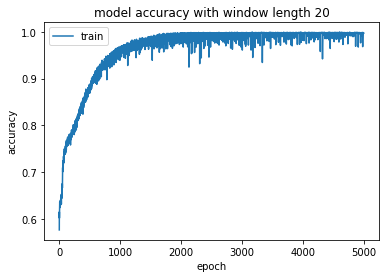

In [127]:
plt.plot(train_accs)
plt.title('model accuracy with window length 20')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

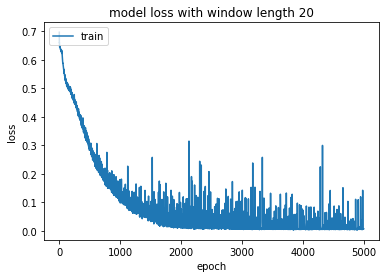

In [128]:
plt.plot(train_losses)
plt.title('model loss with window length 20')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [129]:
second_model.reset_states()
test_results = calc_pos_neg_rate(second_model.evaluate(x=test_generator, verbose=0))

In [130]:
second_model.reset_states()
train_results = calc_pos_neg_rate(second_model.evaluate(x=train_generator, verbose=0))

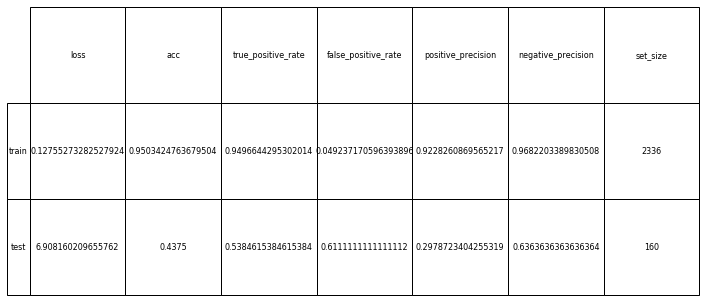

In [131]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Let's save this model for further use.

In [134]:
second_model.save(join(COLAB_DIR,'model_stateful_20.h5'))

Now, let's try window size of 30

In [135]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end, window_in_days=30)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
third_model = build_model(None, optimizer, layers, metrics=metrics)
third_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (32, 64)                  17920     
_________________________________________________________________
dense_60 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_15 (Dropout)         (32, 32)                  0         
_________________________________________________________________
dense_61 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_15 (Batc (32, 16)                  64        
_________________________________________________________________
dense_62 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_63 (Dense)             (32, 1)                 

In [136]:
train_accs, train_losses = fit(third_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   3.175 seconds , loss : 0.704    accuracy : 0.584    
epoch 2
----------->> Epoch 1/1   0.244 seconds , loss : 0.666    accuracy : 0.606    
epoch 3
----------->> Epoch 1/1   0.254 seconds , loss : 0.656    accuracy : 0.607    
epoch 4
----------->> Epoch 1/1   0.255 seconds , loss : 0.659    accuracy : 0.614    
epoch 5
----------->> Epoch 1/1   0.263 seconds , loss : 0.656    accuracy : 0.612    
epoch 6
----------->> Epoch 1/1   0.251 seconds , loss : 0.653    accuracy : 0.623    
epoch 7
----------->> Epoch 1/1   0.262 seconds , loss : 0.648    accuracy : 0.617    
epoch 8
----------->> Epoch 1/1   0.260 seconds , loss : 0.646    accuracy : 0.627    
epoch 9
----------->> Epoch 1/1   0.260 seconds , loss : 0.652    accuracy : 0.607    
epoch 10
----------->> Epoch 1/1   0.244 seconds , loss : 0.647    accuracy : 0.620    
epoch 11
----------->> Epoch 1/1   0.254 seconds , loss : 0.646    accuracy : 0.614    
epoch 12
----------->> Epoch 1/1   0.264 

----------->> Epoch 1/1   0.236 seconds , loss : 0.541    accuracy : 0.747    
epoch 95
----------->> Epoch 1/1   0.263 seconds , loss : 0.539    accuracy : 0.739    
epoch 96
----------->> Epoch 1/1   0.258 seconds , loss : 0.541    accuracy : 0.737    
epoch 97
----------->> Epoch 1/1   0.242 seconds , loss : 0.538    accuracy : 0.743    
epoch 98
----------->> Epoch 1/1   0.243 seconds , loss : 0.537    accuracy : 0.748    
epoch 99
----------->> Epoch 1/1   0.235 seconds , loss : 0.533    accuracy : 0.749    
epoch 100
----------->> Epoch 1/1   0.237 seconds , loss : 0.541    accuracy : 0.739    
epoch 101
----------->> Epoch 1/1   0.248 seconds , loss : 0.535    accuracy : 0.745    
epoch 102
----------->> Epoch 1/1   0.262 seconds , loss : 0.542    accuracy : 0.738    
epoch 103
----------->> Epoch 1/1   0.257 seconds , loss : 0.531    accuracy : 0.737    
epoch 104
----------->> Epoch 1/1   0.237 seconds , loss : 0.534    accuracy : 0.760    
epoch 105
----------->> Epoch 1/1   

----------->> Epoch 1/1   0.376 seconds , loss : 0.497    accuracy : 0.777    
epoch 187
----------->> Epoch 1/1   0.366 seconds , loss : 0.490    accuracy : 0.774    
epoch 188
----------->> Epoch 1/1   0.337 seconds , loss : 0.488    accuracy : 0.779    
epoch 189
----------->> Epoch 1/1   0.318 seconds , loss : 0.487    accuracy : 0.780    
epoch 190
----------->> Epoch 1/1   0.270 seconds , loss : 0.483    accuracy : 0.777    
epoch 191
----------->> Epoch 1/1   0.329 seconds , loss : 0.480    accuracy : 0.786    
epoch 192
----------->> Epoch 1/1   0.303 seconds , loss : 0.490    accuracy : 0.770    
epoch 193
----------->> Epoch 1/1   0.308 seconds , loss : 0.486    accuracy : 0.782    
epoch 194
----------->> Epoch 1/1   0.299 seconds , loss : 0.490    accuracy : 0.778    
epoch 195
----------->> Epoch 1/1   0.331 seconds , loss : 0.492    accuracy : 0.770    
epoch 196
----------->> Epoch 1/1   0.323 seconds , loss : 0.479    accuracy : 0.785    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.303 seconds , loss : 0.439    accuracy : 0.812    
epoch 279
----------->> Epoch 1/1   0.285 seconds , loss : 0.433    accuracy : 0.814    
epoch 280
----------->> Epoch 1/1   0.262 seconds , loss : 0.447    accuracy : 0.801    
epoch 281
----------->> Epoch 1/1   0.263 seconds , loss : 0.437    accuracy : 0.814    
epoch 282
----------->> Epoch 1/1   0.246 seconds , loss : 0.442    accuracy : 0.804    
epoch 283
----------->> Epoch 1/1   0.263 seconds , loss : 0.419    accuracy : 0.815    
epoch 284
----------->> Epoch 1/1   0.252 seconds , loss : 0.424    accuracy : 0.816    
epoch 285
----------->> Epoch 1/1   0.311 seconds , loss : 0.434    accuracy : 0.810    
epoch 286
----------->> Epoch 1/1   0.301 seconds , loss : 0.436    accuracy : 0.811    
epoch 287
----------->> Epoch 1/1   0.274 seconds , loss : 0.428    accuracy : 0.816    
epoch 288
----------->> Epoch 1/1   0.261 seconds , loss : 0.417    accuracy : 0.816    
epoch 289
----------->> Epoch 1

----------->> Epoch 1/1   0.253 seconds , loss : 0.383    accuracy : 0.841    
epoch 371
----------->> Epoch 1/1   0.260 seconds , loss : 0.355    accuracy : 0.857    
epoch 372
----------->> Epoch 1/1   0.250 seconds , loss : 0.367    accuracy : 0.843    
epoch 373
----------->> Epoch 1/1   0.250 seconds , loss : 0.370    accuracy : 0.844    
epoch 374
----------->> Epoch 1/1   0.252 seconds , loss : 0.358    accuracy : 0.848    
epoch 375
----------->> Epoch 1/1   0.256 seconds , loss : 0.361    accuracy : 0.849    
epoch 376
----------->> Epoch 1/1   0.253 seconds , loss : 0.378    accuracy : 0.843    
epoch 377
----------->> Epoch 1/1   0.255 seconds , loss : 0.391    accuracy : 0.839    
epoch 378
----------->> Epoch 1/1   0.258 seconds , loss : 0.361    accuracy : 0.860    
epoch 379
----------->> Epoch 1/1   0.254 seconds , loss : 0.370    accuracy : 0.847    
epoch 380
----------->> Epoch 1/1   0.248 seconds , loss : 0.350    accuracy : 0.858    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.259 seconds , loss : 0.285    accuracy : 0.894    
epoch 463
----------->> Epoch 1/1   0.306 seconds , loss : 0.275    accuracy : 0.891    
epoch 464
----------->> Epoch 1/1   0.267 seconds , loss : 0.287    accuracy : 0.886    
epoch 465
----------->> Epoch 1/1   0.259 seconds , loss : 0.299    accuracy : 0.880    
epoch 466
----------->> Epoch 1/1   0.255 seconds , loss : 0.312    accuracy : 0.879    
epoch 467
----------->> Epoch 1/1   0.256 seconds , loss : 0.289    accuracy : 0.883    
epoch 468
----------->> Epoch 1/1   0.256 seconds , loss : 0.280    accuracy : 0.890    
epoch 469
----------->> Epoch 1/1   0.250 seconds , loss : 0.282    accuracy : 0.890    
epoch 470
----------->> Epoch 1/1   0.254 seconds , loss : 0.277    accuracy : 0.886    
epoch 471
----------->> Epoch 1/1   0.270 seconds , loss : 0.276    accuracy : 0.890    
epoch 472
----------->> Epoch 1/1   0.315 seconds , loss : 0.284    accuracy : 0.887    
epoch 473
----------->> Epoch 1

----------->> Epoch 1/1   0.261 seconds , loss : 0.226    accuracy : 0.915    
epoch 555
----------->> Epoch 1/1   0.252 seconds , loss : 0.250    accuracy : 0.905    
epoch 556
----------->> Epoch 1/1   0.252 seconds , loss : 0.222    accuracy : 0.919    
epoch 557
----------->> Epoch 1/1   0.258 seconds , loss : 0.229    accuracy : 0.912    
epoch 558
----------->> Epoch 1/1   0.259 seconds , loss : 0.219    accuracy : 0.920    
epoch 559
----------->> Epoch 1/1   0.285 seconds , loss : 0.221    accuracy : 0.913    
epoch 560
----------->> Epoch 1/1   0.247 seconds , loss : 0.250    accuracy : 0.908    
epoch 561
----------->> Epoch 1/1   0.258 seconds , loss : 0.261    accuracy : 0.892    
epoch 562
----------->> Epoch 1/1   0.248 seconds , loss : 0.234    accuracy : 0.910    
epoch 563
----------->> Epoch 1/1   0.265 seconds , loss : 0.285    accuracy : 0.889    
epoch 564
----------->> Epoch 1/1   0.250 seconds , loss : 0.222    accuracy : 0.916    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.253 seconds , loss : 0.192    accuracy : 0.930    
epoch 647
----------->> Epoch 1/1   0.255 seconds , loss : 0.234    accuracy : 0.915    
epoch 648
----------->> Epoch 1/1   0.258 seconds , loss : 0.197    accuracy : 0.935    
epoch 649
----------->> Epoch 1/1   0.251 seconds , loss : 0.169    accuracy : 0.932    
epoch 650
----------->> Epoch 1/1   0.253 seconds , loss : 0.171    accuracy : 0.941    
epoch 651
----------->> Epoch 1/1   0.253 seconds , loss : 0.187    accuracy : 0.934    
epoch 652
----------->> Epoch 1/1   0.258 seconds , loss : 0.180    accuracy : 0.936    
epoch 653
----------->> Epoch 1/1   0.255 seconds , loss : 0.175    accuracy : 0.939    
epoch 654
----------->> Epoch 1/1   0.257 seconds , loss : 0.175    accuracy : 0.937    
epoch 655
----------->> Epoch 1/1   0.255 seconds , loss : 0.218    accuracy : 0.919    
epoch 656
----------->> Epoch 1/1   0.256 seconds , loss : 0.187    accuracy : 0.933    
epoch 657
----------->> Epoch 1

----------->> Epoch 1/1   0.255 seconds , loss : 0.143    accuracy : 0.954    
epoch 739
----------->> Epoch 1/1   0.276 seconds , loss : 0.129    accuracy : 0.958    
epoch 740
----------->> Epoch 1/1   0.256 seconds , loss : 0.123    accuracy : 0.960    
epoch 741
----------->> Epoch 1/1   0.256 seconds , loss : 0.123    accuracy : 0.959    
epoch 742
----------->> Epoch 1/1   0.256 seconds , loss : 0.130    accuracy : 0.954    
epoch 743
----------->> Epoch 1/1   0.253 seconds , loss : 0.143    accuracy : 0.955    
epoch 744
----------->> Epoch 1/1   0.258 seconds , loss : 0.227    accuracy : 0.920    
epoch 745
----------->> Epoch 1/1   0.254 seconds , loss : 0.162    accuracy : 0.940    
epoch 746
----------->> Epoch 1/1   0.256 seconds , loss : 0.139    accuracy : 0.953    
epoch 747
----------->> Epoch 1/1   0.256 seconds , loss : 0.149    accuracy : 0.949    
epoch 748
----------->> Epoch 1/1   0.256 seconds , loss : 0.187    accuracy : 0.940    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.257 seconds , loss : 0.104    accuracy : 0.968    
epoch 831
----------->> Epoch 1/1   0.255 seconds , loss : 0.120    accuracy : 0.962    
epoch 832
----------->> Epoch 1/1   0.262 seconds , loss : 0.148    accuracy : 0.952    
epoch 833
----------->> Epoch 1/1   0.258 seconds , loss : 0.130    accuracy : 0.952    
epoch 834
----------->> Epoch 1/1   0.249 seconds , loss : 0.140    accuracy : 0.952    
epoch 835
----------->> Epoch 1/1   0.254 seconds , loss : 0.133    accuracy : 0.952    
epoch 836
----------->> Epoch 1/1   0.256 seconds , loss : 0.129    accuracy : 0.963    
epoch 837
----------->> Epoch 1/1   0.261 seconds , loss : 0.206    accuracy : 0.930    
epoch 838
----------->> Epoch 1/1   0.247 seconds , loss : 0.171    accuracy : 0.943    
epoch 839
----------->> Epoch 1/1   0.254 seconds , loss : 0.127    accuracy : 0.958    
epoch 840
----------->> Epoch 1/1   0.254 seconds , loss : 0.111    accuracy : 0.962    
epoch 841
----------->> Epoch 1

----------->> Epoch 1/1   0.259 seconds , loss : 0.111    accuracy : 0.965    
epoch 923
----------->> Epoch 1/1   0.253 seconds , loss : 0.116    accuracy : 0.958    
epoch 924
----------->> Epoch 1/1   0.253 seconds , loss : 0.103    accuracy : 0.969    
epoch 925
----------->> Epoch 1/1   0.256 seconds , loss : 0.087    accuracy : 0.974    
epoch 926
----------->> Epoch 1/1   0.255 seconds , loss : 0.086    accuracy : 0.973    
epoch 927
----------->> Epoch 1/1   0.255 seconds , loss : 0.104    accuracy : 0.964    
epoch 928
----------->> Epoch 1/1   0.255 seconds , loss : 0.117    accuracy : 0.967    
epoch 929
----------->> Epoch 1/1   0.255 seconds , loss : 0.215    accuracy : 0.931    
epoch 930
----------->> Epoch 1/1   0.254 seconds , loss : 0.108    accuracy : 0.963    
epoch 931
----------->> Epoch 1/1   0.255 seconds , loss : 0.087    accuracy : 0.974    
epoch 932
----------->> Epoch 1/1   0.257 seconds , loss : 0.075    accuracy : 0.973    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.259 seconds , loss : 0.107    accuracy : 0.963    
epoch 1015
----------->> Epoch 1/1   0.254 seconds , loss : 0.102    accuracy : 0.969    
epoch 1016
----------->> Epoch 1/1   0.256 seconds , loss : 0.090    accuracy : 0.973    
epoch 1017
----------->> Epoch 1/1   0.254 seconds , loss : 0.121    accuracy : 0.963    
epoch 1018
----------->> Epoch 1/1   0.252 seconds , loss : 0.085    accuracy : 0.970    
epoch 1019
----------->> Epoch 1/1   0.255 seconds , loss : 0.088    accuracy : 0.972    
epoch 1020
----------->> Epoch 1/1   0.253 seconds , loss : 0.102    accuracy : 0.964    
epoch 1021
----------->> Epoch 1/1   0.255 seconds , loss : 0.172    accuracy : 0.949    
epoch 1022
----------->> Epoch 1/1   0.254 seconds , loss : 0.109    accuracy : 0.964    
epoch 1023
----------->> Epoch 1/1   0.253 seconds , loss : 0.077    accuracy : 0.976    
epoch 1024
----------->> Epoch 1/1   0.253 seconds , loss : 0.060    accuracy : 0.982    
epoch 1025
----------

----------->> Epoch 1/1   0.254 seconds , loss : 0.058    accuracy : 0.982    
epoch 1106
----------->> Epoch 1/1   0.256 seconds , loss : 0.047    accuracy : 0.985    
epoch 1107
----------->> Epoch 1/1   0.264 seconds , loss : 0.050    accuracy : 0.983    
epoch 1108
----------->> Epoch 1/1   0.265 seconds , loss : 0.052    accuracy : 0.985    
epoch 1109
----------->> Epoch 1/1   0.254 seconds , loss : 0.050    accuracy : 0.983    
epoch 1110
----------->> Epoch 1/1   0.257 seconds , loss : 0.046    accuracy : 0.986    
epoch 1111
----------->> Epoch 1/1   0.253 seconds , loss : 0.054    accuracy : 0.984    
epoch 1112
----------->> Epoch 1/1   0.254 seconds , loss : 0.113    accuracy : 0.967    
epoch 1113
----------->> Epoch 1/1   0.256 seconds , loss : 0.069    accuracy : 0.980    
epoch 1114
----------->> Epoch 1/1   0.254 seconds , loss : 0.047    accuracy : 0.985    
epoch 1115
----------->> Epoch 1/1   0.256 seconds , loss : 0.044    accuracy : 0.984    
epoch 1116
----------

----------->> Epoch 1/1   0.250 seconds , loss : 0.024    accuracy : 0.991    
epoch 1197
----------->> Epoch 1/1   0.264 seconds , loss : 0.031    accuracy : 0.989    
epoch 1198
----------->> Epoch 1/1   0.249 seconds , loss : 0.062    accuracy : 0.981    
epoch 1199
----------->> Epoch 1/1   0.253 seconds , loss : 0.089    accuracy : 0.973    
epoch 1200
----------->> Epoch 1/1   0.254 seconds , loss : 0.047    accuracy : 0.987    
epoch 1201
----------->> Epoch 1/1   0.255 seconds , loss : 0.054    accuracy : 0.984    
epoch 1202
----------->> Epoch 1/1   0.254 seconds , loss : 0.137    accuracy : 0.963    
epoch 1203
----------->> Epoch 1/1   0.253 seconds , loss : 0.131    accuracy : 0.961    
epoch 1204
----------->> Epoch 1/1   0.257 seconds , loss : 0.053    accuracy : 0.984    
epoch 1205
----------->> Epoch 1/1   0.254 seconds , loss : 0.043    accuracy : 0.988    
epoch 1206
----------->> Epoch 1/1   0.252 seconds , loss : 0.034    accuracy : 0.991    
epoch 1207
----------

----------->> Epoch 1/1   0.254 seconds , loss : 0.044    accuracy : 0.985    
epoch 1288
----------->> Epoch 1/1   0.257 seconds , loss : 0.029    accuracy : 0.991    
epoch 1289
----------->> Epoch 1/1   0.256 seconds , loss : 0.029    accuracy : 0.991    
epoch 1290
----------->> Epoch 1/1   0.256 seconds , loss : 0.021    accuracy : 0.993    
epoch 1291
----------->> Epoch 1/1   0.254 seconds , loss : 0.063    accuracy : 0.983    
epoch 1292
----------->> Epoch 1/1   0.256 seconds , loss : 0.126    accuracy : 0.973    
epoch 1293
----------->> Epoch 1/1   0.255 seconds , loss : 0.082    accuracy : 0.971    
epoch 1294
----------->> Epoch 1/1   0.255 seconds , loss : 0.052    accuracy : 0.986    
epoch 1295
----------->> Epoch 1/1   0.256 seconds , loss : 0.028    accuracy : 0.993    
epoch 1296
----------->> Epoch 1/1   0.257 seconds , loss : 0.020    accuracy : 0.995    
epoch 1297
----------->> Epoch 1/1   0.255 seconds , loss : 0.021    accuracy : 0.993    
epoch 1298
----------

----------->> Epoch 1/1   0.264 seconds , loss : 0.030    accuracy : 0.990    
epoch 1379
----------->> Epoch 1/1   0.257 seconds , loss : 0.029    accuracy : 0.991    
epoch 1380
----------->> Epoch 1/1   0.329 seconds , loss : 0.021    accuracy : 0.992    
epoch 1381
----------->> Epoch 1/1   0.308 seconds , loss : 0.061    accuracy : 0.984    
epoch 1382
----------->> Epoch 1/1   0.284 seconds , loss : 0.039    accuracy : 0.987    
epoch 1383
----------->> Epoch 1/1   0.288 seconds , loss : 0.033    accuracy : 0.989    
epoch 1384
----------->> Epoch 1/1   0.307 seconds , loss : 0.020    accuracy : 0.994    
epoch 1385
----------->> Epoch 1/1   0.279 seconds , loss : 0.030    accuracy : 0.992    
epoch 1386
----------->> Epoch 1/1   0.280 seconds , loss : 0.030    accuracy : 0.990    
epoch 1387
----------->> Epoch 1/1   0.280 seconds , loss : 0.052    accuracy : 0.985    
epoch 1388
----------->> Epoch 1/1   0.287 seconds , loss : 0.054    accuracy : 0.986    
epoch 1389
----------

----------->> Epoch 1/1   0.255 seconds , loss : 0.025    accuracy : 0.994    
epoch 1470
----------->> Epoch 1/1   0.243 seconds , loss : 0.012    accuracy : 0.996    
epoch 1471
----------->> Epoch 1/1   0.249 seconds , loss : 0.030    accuracy : 0.991    
epoch 1472
----------->> Epoch 1/1   0.250 seconds , loss : 0.108    accuracy : 0.973    
epoch 1473
----------->> Epoch 1/1   0.255 seconds , loss : 0.116    accuracy : 0.967    
epoch 1474
----------->> Epoch 1/1   0.253 seconds , loss : 0.072    accuracy : 0.980    
epoch 1475
----------->> Epoch 1/1   0.254 seconds , loss : 0.032    accuracy : 0.990    
epoch 1476
----------->> Epoch 1/1   0.265 seconds , loss : 0.043    accuracy : 0.987    
epoch 1477
----------->> Epoch 1/1   0.245 seconds , loss : 0.057    accuracy : 0.983    
epoch 1478
----------->> Epoch 1/1   0.251 seconds , loss : 0.026    accuracy : 0.991    
epoch 1479
----------->> Epoch 1/1   0.258 seconds , loss : 0.024    accuracy : 0.992    
epoch 1480
----------

----------->> Epoch 1/1   0.253 seconds , loss : 0.010    accuracy : 0.997    
epoch 1561
----------->> Epoch 1/1   0.253 seconds , loss : 0.012    accuracy : 0.997    
epoch 1562
----------->> Epoch 1/1   0.253 seconds , loss : 0.010    accuracy : 0.997    
epoch 1563
----------->> Epoch 1/1   0.257 seconds , loss : 0.014    accuracy : 0.996    
epoch 1564
----------->> Epoch 1/1   0.256 seconds , loss : 0.017    accuracy : 0.995    
epoch 1565
----------->> Epoch 1/1   0.261 seconds , loss : 0.015    accuracy : 0.995    
epoch 1566
----------->> Epoch 1/1   0.253 seconds , loss : 0.024    accuracy : 0.993    
epoch 1567
----------->> Epoch 1/1   0.256 seconds , loss : 0.058    accuracy : 0.984    
epoch 1568
----------->> Epoch 1/1   0.255 seconds , loss : 0.070    accuracy : 0.979    
epoch 1569
----------->> Epoch 1/1   0.249 seconds , loss : 0.077    accuracy : 0.976    
epoch 1570
----------->> Epoch 1/1   0.253 seconds , loss : 0.067    accuracy : 0.982    
epoch 1571
----------

----------->> Epoch 1/1   0.262 seconds , loss : 0.012    accuracy : 0.996    
epoch 1652
----------->> Epoch 1/1   0.249 seconds , loss : 0.012    accuracy : 0.997    
epoch 1653
----------->> Epoch 1/1   0.249 seconds , loss : 0.010    accuracy : 0.997    
epoch 1654
----------->> Epoch 1/1   0.252 seconds , loss : 0.012    accuracy : 0.997    
epoch 1655
----------->> Epoch 1/1   0.246 seconds , loss : 0.016    accuracy : 0.994    
epoch 1656
----------->> Epoch 1/1   0.253 seconds , loss : 0.019    accuracy : 0.992    
epoch 1657
----------->> Epoch 1/1   0.254 seconds , loss : 0.043    accuracy : 0.987    
epoch 1658
----------->> Epoch 1/1   0.252 seconds , loss : 0.042    accuracy : 0.985    
epoch 1659
----------->> Epoch 1/1   0.266 seconds , loss : 0.108    accuracy : 0.975    
epoch 1660
----------->> Epoch 1/1   0.248 seconds , loss : 0.107    accuracy : 0.969    
epoch 1661
----------->> Epoch 1/1   0.250 seconds , loss : 0.047    accuracy : 0.985    
epoch 1662
----------

----------->> Epoch 1/1   0.244 seconds , loss : 0.008    accuracy : 0.998    
epoch 1743
----------->> Epoch 1/1   0.249 seconds , loss : 0.009    accuracy : 0.998    
epoch 1744
----------->> Epoch 1/1   0.248 seconds , loss : 0.010    accuracy : 0.997    
epoch 1745
----------->> Epoch 1/1   0.244 seconds , loss : 0.008    accuracy : 0.998    
epoch 1746
----------->> Epoch 1/1   0.248 seconds , loss : 0.064    accuracy : 0.984    
epoch 1747
----------->> Epoch 1/1   0.239 seconds , loss : 0.108    accuracy : 0.968    
epoch 1748
----------->> Epoch 1/1   0.249 seconds , loss : 0.046    accuracy : 0.987    
epoch 1749
----------->> Epoch 1/1   0.251 seconds , loss : 0.020    accuracy : 0.994    
epoch 1750
----------->> Epoch 1/1   0.256 seconds , loss : 0.019    accuracy : 0.996    
epoch 1751
----------->> Epoch 1/1   0.246 seconds , loss : 0.016    accuracy : 0.994    
epoch 1752
----------->> Epoch 1/1   0.246 seconds , loss : 0.014    accuracy : 0.997    
epoch 1753
----------

----------->> Epoch 1/1   0.248 seconds , loss : 0.013    accuracy : 0.996    
epoch 1834
----------->> Epoch 1/1   0.259 seconds , loss : 0.109    accuracy : 0.980    
epoch 1835
----------->> Epoch 1/1   0.250 seconds , loss : 0.050    accuracy : 0.984    
epoch 1836
----------->> Epoch 1/1   0.245 seconds , loss : 0.036    accuracy : 0.991    
epoch 1837
----------->> Epoch 1/1   0.246 seconds , loss : 0.018    accuracy : 0.996    
epoch 1838
----------->> Epoch 1/1   0.250 seconds , loss : 0.018    accuracy : 0.996    
epoch 1839
----------->> Epoch 1/1   0.253 seconds , loss : 0.011    accuracy : 0.997    
epoch 1840
----------->> Epoch 1/1   0.257 seconds , loss : 0.012    accuracy : 0.994    
epoch 1841
----------->> Epoch 1/1   0.256 seconds , loss : 0.012    accuracy : 0.997    
epoch 1842
----------->> Epoch 1/1   0.252 seconds , loss : 0.010    accuracy : 0.998    
epoch 1843
----------->> Epoch 1/1   0.250 seconds , loss : 0.010    accuracy : 0.997    
epoch 1844
----------

----------->> Epoch 1/1   0.263 seconds , loss : 0.008    accuracy : 0.998    
epoch 1925
----------->> Epoch 1/1   0.259 seconds , loss : 0.007    accuracy : 0.998    
epoch 1926
----------->> Epoch 1/1   0.255 seconds , loss : 0.008    accuracy : 0.997    
epoch 1927
----------->> Epoch 1/1   0.256 seconds , loss : 0.008    accuracy : 0.999    
epoch 1928
----------->> Epoch 1/1   0.258 seconds , loss : 0.007    accuracy : 0.998    
epoch 1929
----------->> Epoch 1/1   0.267 seconds , loss : 0.006    accuracy : 0.999    
epoch 1930
----------->> Epoch 1/1   0.256 seconds , loss : 0.006    accuracy : 1.000    
epoch 1931
----------->> Epoch 1/1   0.253 seconds , loss : 0.008    accuracy : 0.998    
epoch 1932
----------->> Epoch 1/1   0.254 seconds , loss : 0.010    accuracy : 0.997    
epoch 1933
----------->> Epoch 1/1   0.256 seconds , loss : 0.009    accuracy : 0.998    
epoch 1934
----------->> Epoch 1/1   0.260 seconds , loss : 0.063    accuracy : 0.983    
epoch 1935
----------

----------->> Epoch 1/1   0.262 seconds , loss : 0.008    accuracy : 0.998    
epoch 2016
----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.998    
epoch 2017
----------->> Epoch 1/1   0.248 seconds , loss : 0.007    accuracy : 0.998    
epoch 2018
----------->> Epoch 1/1   0.253 seconds , loss : 0.007    accuracy : 0.998    
epoch 2019
----------->> Epoch 1/1   0.250 seconds , loss : 0.007    accuracy : 0.998    
epoch 2020
----------->> Epoch 1/1   0.254 seconds , loss : 0.006    accuracy : 0.999    
epoch 2021
----------->> Epoch 1/1   0.252 seconds , loss : 0.013    accuracy : 0.997    
epoch 2022
----------->> Epoch 1/1   0.255 seconds , loss : 0.027    accuracy : 0.994    
epoch 2023
----------->> Epoch 1/1   0.258 seconds , loss : 0.019    accuracy : 0.992    
epoch 2024
----------->> Epoch 1/1   0.253 seconds , loss : 0.029    accuracy : 0.992    
epoch 2025
----------->> Epoch 1/1   0.261 seconds , loss : 0.024    accuracy : 0.991    
epoch 2026
----------

----------->> Epoch 1/1   0.255 seconds , loss : 0.007    accuracy : 0.998    
epoch 2107
----------->> Epoch 1/1   0.257 seconds , loss : 0.008    accuracy : 0.998    
epoch 2108
----------->> Epoch 1/1   0.259 seconds , loss : 0.007    accuracy : 0.999    
epoch 2109
----------->> Epoch 1/1   0.259 seconds , loss : 0.008    accuracy : 0.998    
epoch 2110
----------->> Epoch 1/1   0.261 seconds , loss : 0.012    accuracy : 0.996    
epoch 2111
----------->> Epoch 1/1   0.250 seconds , loss : 0.014    accuracy : 0.997    
epoch 2112
----------->> Epoch 1/1   0.247 seconds , loss : 0.011    accuracy : 0.996    
epoch 2113
----------->> Epoch 1/1   0.252 seconds , loss : 0.007    accuracy : 0.999    
epoch 2114
----------->> Epoch 1/1   0.256 seconds , loss : 0.009    accuracy : 0.997    
epoch 2115
----------->> Epoch 1/1   0.254 seconds , loss : 0.007    accuracy : 0.997    
epoch 2116
----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.998    
epoch 2117
----------

----------->> Epoch 1/1   0.255 seconds , loss : 0.117    accuracy : 0.970    
epoch 2198
----------->> Epoch 1/1   0.258 seconds , loss : 0.068    accuracy : 0.984    
epoch 2199
----------->> Epoch 1/1   0.264 seconds , loss : 0.037    accuracy : 0.991    
epoch 2200
----------->> Epoch 1/1   0.262 seconds , loss : 0.037    accuracy : 0.991    
epoch 2201
----------->> Epoch 1/1   0.329 seconds , loss : 0.024    accuracy : 0.996    
epoch 2202
----------->> Epoch 1/1   0.249 seconds , loss : 0.012    accuracy : 0.997    
epoch 2203
----------->> Epoch 1/1   0.252 seconds , loss : 0.012    accuracy : 0.997    
epoch 2204
----------->> Epoch 1/1   0.259 seconds , loss : 0.012    accuracy : 0.997    
epoch 2205
----------->> Epoch 1/1   0.251 seconds , loss : 0.010    accuracy : 0.997    
epoch 2206
----------->> Epoch 1/1   0.266 seconds , loss : 0.008    accuracy : 0.998    
epoch 2207
----------->> Epoch 1/1   0.267 seconds , loss : 0.021    accuracy : 0.993    
epoch 2208
----------

----------->> Epoch 1/1   0.255 seconds , loss : 0.007    accuracy : 0.999    
epoch 2289
----------->> Epoch 1/1   0.254 seconds , loss : 0.007    accuracy : 0.998    
epoch 2290
----------->> Epoch 1/1   0.251 seconds , loss : 0.006    accuracy : 0.998    
epoch 2291
----------->> Epoch 1/1   0.247 seconds , loss : 0.007    accuracy : 0.998    
epoch 2292
----------->> Epoch 1/1   0.264 seconds , loss : 0.006    accuracy : 0.999    
epoch 2293
----------->> Epoch 1/1   0.257 seconds , loss : 0.006    accuracy : 0.999    
epoch 2294
----------->> Epoch 1/1   0.251 seconds , loss : 0.006    accuracy : 0.999    
epoch 2295
----------->> Epoch 1/1   0.251 seconds , loss : 0.006    accuracy : 0.999    
epoch 2296
----------->> Epoch 1/1   0.256 seconds , loss : 0.007    accuracy : 0.997    
epoch 2297
----------->> Epoch 1/1   0.254 seconds , loss : 0.010    accuracy : 0.997    
epoch 2298
----------->> Epoch 1/1   0.255 seconds , loss : 0.008    accuracy : 0.997    
epoch 2299
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.008    accuracy : 0.998    
epoch 2380
----------->> Epoch 1/1   0.253 seconds , loss : 0.007    accuracy : 0.999    
epoch 2381
----------->> Epoch 1/1   0.253 seconds , loss : 0.012    accuracy : 0.994    
epoch 2382
----------->> Epoch 1/1   0.254 seconds , loss : 0.016    accuracy : 0.996    
epoch 2383
----------->> Epoch 1/1   0.257 seconds , loss : 0.042    accuracy : 0.988    
epoch 2384
----------->> Epoch 1/1   0.256 seconds , loss : 0.202    accuracy : 0.967    
epoch 2385
----------->> Epoch 1/1   0.255 seconds , loss : 0.089    accuracy : 0.979    
epoch 2386
----------->> Epoch 1/1   0.255 seconds , loss : 0.117    accuracy : 0.970    
epoch 2387
----------->> Epoch 1/1   0.254 seconds , loss : 0.055    accuracy : 0.983    
epoch 2388
----------->> Epoch 1/1   0.253 seconds , loss : 0.030    accuracy : 0.993    
epoch 2389
----------->> Epoch 1/1   0.254 seconds , loss : 0.020    accuracy : 0.997    
epoch 2390
----------

----------->> Epoch 1/1   0.246 seconds , loss : 0.015    accuracy : 0.995    
epoch 2471
----------->> Epoch 1/1   0.257 seconds , loss : 0.022    accuracy : 0.991    
epoch 2472
----------->> Epoch 1/1   0.243 seconds , loss : 0.094    accuracy : 0.975    
epoch 2473
----------->> Epoch 1/1   0.266 seconds , loss : 0.045    accuracy : 0.989    
epoch 2474
----------->> Epoch 1/1   0.252 seconds , loss : 0.028    accuracy : 0.993    
epoch 2475
----------->> Epoch 1/1   0.250 seconds , loss : 0.015    accuracy : 0.996    
epoch 2476
----------->> Epoch 1/1   0.257 seconds , loss : 0.009    accuracy : 0.997    
epoch 2477
----------->> Epoch 1/1   0.262 seconds , loss : 0.006    accuracy : 0.999    
epoch 2478
----------->> Epoch 1/1   0.242 seconds , loss : 0.008    accuracy : 0.998    
epoch 2479
----------->> Epoch 1/1   0.245 seconds , loss : 0.013    accuracy : 0.997    
epoch 2480
----------->> Epoch 1/1   0.258 seconds , loss : 0.049    accuracy : 0.988    
epoch 2481
----------

----------->> Epoch 1/1   0.258 seconds , loss : 0.007    accuracy : 0.998    
epoch 2562
----------->> Epoch 1/1   0.246 seconds , loss : 0.009    accuracy : 0.997    
epoch 2563
----------->> Epoch 1/1   0.259 seconds , loss : 0.007    accuracy : 0.997    
epoch 2564
----------->> Epoch 1/1   0.249 seconds , loss : 0.013    accuracy : 0.994    
epoch 2565
----------->> Epoch 1/1   0.248 seconds , loss : 0.144    accuracy : 0.970    
epoch 2566
----------->> Epoch 1/1   0.256 seconds , loss : 0.119    accuracy : 0.965    
epoch 2567
----------->> Epoch 1/1   0.245 seconds , loss : 0.045    accuracy : 0.987    
epoch 2568
----------->> Epoch 1/1   0.255 seconds , loss : 0.054    accuracy : 0.986    
epoch 2569
----------->> Epoch 1/1   0.249 seconds , loss : 0.025    accuracy : 0.994    
epoch 2570
----------->> Epoch 1/1   0.256 seconds , loss : 0.027    accuracy : 0.995    
epoch 2571
----------->> Epoch 1/1   0.250 seconds , loss : 0.016    accuracy : 0.996    
epoch 2572
----------

----------->> Epoch 1/1   0.247 seconds , loss : 0.004    accuracy : 0.999    
epoch 2653
----------->> Epoch 1/1   0.253 seconds , loss : 0.127    accuracy : 0.976    
epoch 2654
----------->> Epoch 1/1   0.247 seconds , loss : 0.239    accuracy : 0.941    
epoch 2655
----------->> Epoch 1/1   0.246 seconds , loss : 0.064    accuracy : 0.981    
epoch 2656
----------->> Epoch 1/1   0.255 seconds , loss : 0.023    accuracy : 0.991    
epoch 2657
----------->> Epoch 1/1   0.256 seconds , loss : 0.016    accuracy : 0.996    
epoch 2658
----------->> Epoch 1/1   0.254 seconds , loss : 0.015    accuracy : 0.997    
epoch 2659
----------->> Epoch 1/1   0.256 seconds , loss : 0.008    accuracy : 0.999    
epoch 2660
----------->> Epoch 1/1   0.253 seconds , loss : 0.008    accuracy : 0.999    
epoch 2661
----------->> Epoch 1/1   0.254 seconds , loss : 0.009    accuracy : 0.997    
epoch 2662
----------->> Epoch 1/1   0.260 seconds , loss : 0.011    accuracy : 0.997    
epoch 2663
----------

----------->> Epoch 1/1   0.258 seconds , loss : 0.015    accuracy : 0.994    
epoch 2744
----------->> Epoch 1/1   0.257 seconds , loss : 0.026    accuracy : 0.990    
epoch 2745
----------->> Epoch 1/1   0.255 seconds , loss : 0.027    accuracy : 0.989    
epoch 2746
----------->> Epoch 1/1   0.254 seconds , loss : 0.055    accuracy : 0.982    
epoch 2747
----------->> Epoch 1/1   0.257 seconds , loss : 0.048    accuracy : 0.984    
epoch 2748
----------->> Epoch 1/1   0.257 seconds , loss : 0.023    accuracy : 0.992    
epoch 2749
----------->> Epoch 1/1   0.255 seconds , loss : 0.011    accuracy : 0.997    
epoch 2750
----------->> Epoch 1/1   0.255 seconds , loss : 0.007    accuracy : 0.999    
epoch 2751
----------->> Epoch 1/1   0.255 seconds , loss : 0.013    accuracy : 0.995    
epoch 2752
----------->> Epoch 1/1   0.253 seconds , loss : 0.018    accuracy : 0.995    
epoch 2753
----------->> Epoch 1/1   0.260 seconds , loss : 0.019    accuracy : 0.994    
epoch 2754
----------

----------->> Epoch 1/1   0.256 seconds , loss : 0.011    accuracy : 0.998    
epoch 2835
----------->> Epoch 1/1   0.258 seconds , loss : 0.007    accuracy : 0.999    
epoch 2836
----------->> Epoch 1/1   0.254 seconds , loss : 0.017    accuracy : 0.996    
epoch 2837
----------->> Epoch 1/1   0.263 seconds , loss : 0.122    accuracy : 0.978    
epoch 2838
----------->> Epoch 1/1   0.246 seconds , loss : 0.122    accuracy : 0.968    
epoch 2839
----------->> Epoch 1/1   0.250 seconds , loss : 0.055    accuracy : 0.982    
epoch 2840
----------->> Epoch 1/1   0.254 seconds , loss : 0.026    accuracy : 0.994    
epoch 2841
----------->> Epoch 1/1   0.253 seconds , loss : 0.014    accuracy : 0.997    
epoch 2842
----------->> Epoch 1/1   0.255 seconds , loss : 0.012    accuracy : 0.997    
epoch 2843
----------->> Epoch 1/1   0.258 seconds , loss : 0.013    accuracy : 0.997    
epoch 2844
----------->> Epoch 1/1   0.249 seconds , loss : 0.008    accuracy : 0.999    
epoch 2845
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.008    accuracy : 0.998    
epoch 2926
----------->> Epoch 1/1   0.257 seconds , loss : 0.017    accuracy : 0.995    
epoch 2927
----------->> Epoch 1/1   0.257 seconds , loss : 0.011    accuracy : 0.996    
epoch 2928
----------->> Epoch 1/1   0.269 seconds , loss : 0.006    accuracy : 0.998    
epoch 2929
----------->> Epoch 1/1   0.299 seconds , loss : 0.005    accuracy : 0.999    
epoch 2930
----------->> Epoch 1/1   0.295 seconds , loss : 0.010    accuracy : 0.997    
epoch 2931
----------->> Epoch 1/1   0.302 seconds , loss : 0.005    accuracy : 0.999    
epoch 2932
----------->> Epoch 1/1   0.259 seconds , loss : 0.006    accuracy : 0.999    
epoch 2933
----------->> Epoch 1/1   0.260 seconds , loss : 0.007    accuracy : 0.998    
epoch 2934
----------->> Epoch 1/1   0.254 seconds , loss : 0.004    accuracy : 0.999    
epoch 2935
----------->> Epoch 1/1   0.257 seconds , loss : 0.006    accuracy : 0.999    
epoch 2936
----------

----------->> Epoch 1/1   0.254 seconds , loss : 0.010    accuracy : 0.997    
epoch 3017
----------->> Epoch 1/1   0.251 seconds , loss : 0.010    accuracy : 0.997    
epoch 3018
----------->> Epoch 1/1   0.245 seconds , loss : 0.007    accuracy : 0.998    
epoch 3019
----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.999    
epoch 3020
----------->> Epoch 1/1   0.252 seconds , loss : 0.004    accuracy : 0.999    
epoch 3021
----------->> Epoch 1/1   0.248 seconds , loss : 0.003    accuracy : 0.999    
epoch 3022
----------->> Epoch 1/1   0.250 seconds , loss : 0.012    accuracy : 0.996    
epoch 3023
----------->> Epoch 1/1   0.254 seconds , loss : 0.047    accuracy : 0.985    
epoch 3024
----------->> Epoch 1/1   0.255 seconds , loss : 0.076    accuracy : 0.976    
epoch 3025
----------->> Epoch 1/1   0.255 seconds , loss : 0.107    accuracy : 0.974    
epoch 3026
----------->> Epoch 1/1   0.265 seconds , loss : 0.067    accuracy : 0.981    
epoch 3027
----------

----------->> Epoch 1/1   0.320 seconds , loss : 0.050    accuracy : 0.987    
epoch 3108
----------->> Epoch 1/1   0.296 seconds , loss : 0.027    accuracy : 0.994    
epoch 3109
----------->> Epoch 1/1   0.308 seconds , loss : 0.014    accuracy : 0.996    
epoch 3110
----------->> Epoch 1/1   0.330 seconds , loss : 0.008    accuracy : 0.997    
epoch 3111
----------->> Epoch 1/1   0.369 seconds , loss : 0.007    accuracy : 0.999    
epoch 3112
----------->> Epoch 1/1   0.341 seconds , loss : 0.007    accuracy : 0.998    
epoch 3113
----------->> Epoch 1/1   0.284 seconds , loss : 0.007    accuracy : 0.999    
epoch 3114
----------->> Epoch 1/1   0.280 seconds , loss : 0.009    accuracy : 0.997    
epoch 3115
----------->> Epoch 1/1   0.273 seconds , loss : 0.005    accuracy : 0.999    
epoch 3116
----------->> Epoch 1/1   0.284 seconds , loss : 0.005    accuracy : 0.998    
epoch 3117
----------->> Epoch 1/1   0.298 seconds , loss : 0.007    accuracy : 0.998    
epoch 3118
----------

----------->> Epoch 1/1   0.279 seconds , loss : 0.004    accuracy : 0.999    
epoch 3199
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.998    
epoch 3200
----------->> Epoch 1/1   0.255 seconds , loss : 0.005    accuracy : 0.999    
epoch 3201
----------->> Epoch 1/1   0.256 seconds , loss : 0.004    accuracy : 0.999    
epoch 3202
----------->> Epoch 1/1   0.256 seconds , loss : 0.004    accuracy : 0.999    
epoch 3203
----------->> Epoch 1/1   0.280 seconds , loss : 0.003    accuracy : 0.999    
epoch 3204
----------->> Epoch 1/1   0.300 seconds , loss : 0.010    accuracy : 0.997    
epoch 3205
----------->> Epoch 1/1   0.295 seconds , loss : 0.166    accuracy : 0.963    
epoch 3206
----------->> Epoch 1/1   0.260 seconds , loss : 0.059    accuracy : 0.979    
epoch 3207
----------->> Epoch 1/1   0.260 seconds , loss : 0.015    accuracy : 0.997    
epoch 3208
----------->> Epoch 1/1   0.253 seconds , loss : 0.008    accuracy : 0.998    
epoch 3209
----------

----------->> Epoch 1/1   0.314 seconds , loss : 0.035    accuracy : 0.991    
epoch 3290
----------->> Epoch 1/1   0.335 seconds , loss : 0.034    accuracy : 0.993    
epoch 3291
----------->> Epoch 1/1   0.350 seconds , loss : 0.020    accuracy : 0.997    
epoch 3292
----------->> Epoch 1/1   0.452 seconds , loss : 0.029    accuracy : 0.992    
epoch 3293
----------->> Epoch 1/1   0.376 seconds , loss : 0.058    accuracy : 0.988    
epoch 3294
----------->> Epoch 1/1   0.328 seconds , loss : 0.014    accuracy : 0.996    
epoch 3295
----------->> Epoch 1/1   0.335 seconds , loss : 0.009    accuracy : 0.998    
epoch 3296
----------->> Epoch 1/1   0.317 seconds , loss : 0.007    accuracy : 0.998    
epoch 3297
----------->> Epoch 1/1   0.338 seconds , loss : 0.007    accuracy : 0.998    
epoch 3298
----------->> Epoch 1/1   0.324 seconds , loss : 0.005    accuracy : 0.999    
epoch 3299
----------->> Epoch 1/1   0.321 seconds , loss : 0.006    accuracy : 0.999    
epoch 3300
----------

----------->> Epoch 1/1   0.262 seconds , loss : 0.093    accuracy : 0.983    
epoch 3381
----------->> Epoch 1/1   0.261 seconds , loss : 0.089    accuracy : 0.980    
epoch 3382
----------->> Epoch 1/1   0.289 seconds , loss : 0.050    accuracy : 0.986    
epoch 3383
----------->> Epoch 1/1   0.260 seconds , loss : 0.021    accuracy : 0.995    
epoch 3384
----------->> Epoch 1/1   0.253 seconds , loss : 0.013    accuracy : 0.997    
epoch 3385
----------->> Epoch 1/1   0.253 seconds , loss : 0.009    accuracy : 0.998    
epoch 3386
----------->> Epoch 1/1   0.255 seconds , loss : 0.005    accuracy : 0.999    
epoch 3387
----------->> Epoch 1/1   0.284 seconds , loss : 0.005    accuracy : 0.999    
epoch 3388
----------->> Epoch 1/1   0.281 seconds , loss : 0.004    accuracy : 0.999    
epoch 3389
----------->> Epoch 1/1   0.276 seconds , loss : 0.005    accuracy : 0.999    
epoch 3390
----------->> Epoch 1/1   0.261 seconds , loss : 0.004    accuracy : 1.000    
epoch 3391
----------

----------->> Epoch 1/1   0.315 seconds , loss : 0.004    accuracy : 0.999    
epoch 3472
----------->> Epoch 1/1   0.321 seconds , loss : 0.005    accuracy : 0.998    
epoch 3473
----------->> Epoch 1/1   0.334 seconds , loss : 0.004    accuracy : 0.999    
epoch 3474
----------->> Epoch 1/1   0.326 seconds , loss : 0.004    accuracy : 0.999    
epoch 3475
----------->> Epoch 1/1   0.295 seconds , loss : 0.005    accuracy : 0.999    
epoch 3476
----------->> Epoch 1/1   0.305 seconds , loss : 0.004    accuracy : 0.999    
epoch 3477
----------->> Epoch 1/1   0.300 seconds , loss : 0.004    accuracy : 0.999    
epoch 3478
----------->> Epoch 1/1   0.303 seconds , loss : 0.004    accuracy : 0.999    
epoch 3479
----------->> Epoch 1/1   0.307 seconds , loss : 0.004    accuracy : 0.998    
epoch 3480
----------->> Epoch 1/1   0.328 seconds , loss : 0.005    accuracy : 0.999    
epoch 3481
----------->> Epoch 1/1   0.368 seconds , loss : 0.003    accuracy : 0.999    
epoch 3482
----------

----------->> Epoch 1/1   0.324 seconds , loss : 0.029    accuracy : 0.993    
epoch 3563
----------->> Epoch 1/1   0.300 seconds , loss : 0.019    accuracy : 0.994    
epoch 3564
----------->> Epoch 1/1   0.293 seconds , loss : 0.014    accuracy : 0.997    
epoch 3565
----------->> Epoch 1/1   0.288 seconds , loss : 0.008    accuracy : 0.999    
epoch 3566
----------->> Epoch 1/1   0.302 seconds , loss : 0.007    accuracy : 0.999    
epoch 3567
----------->> Epoch 1/1   0.265 seconds , loss : 0.009    accuracy : 0.997    
epoch 3568
----------->> Epoch 1/1   0.285 seconds , loss : 0.009    accuracy : 0.997    
epoch 3569
----------->> Epoch 1/1   0.259 seconds , loss : 0.007    accuracy : 0.998    
epoch 3570
----------->> Epoch 1/1   0.252 seconds , loss : 0.006    accuracy : 0.998    
epoch 3571
----------->> Epoch 1/1   0.272 seconds , loss : 0.005    accuracy : 0.999    
epoch 3572
----------->> Epoch 1/1   0.281 seconds , loss : 0.005    accuracy : 0.999    
epoch 3573
----------

----------->> Epoch 1/1   0.258 seconds , loss : 0.005    accuracy : 0.999    
epoch 3654
----------->> Epoch 1/1   0.275 seconds , loss : 0.005    accuracy : 0.999    
epoch 3655
----------->> Epoch 1/1   0.249 seconds , loss : 0.005    accuracy : 0.999    
epoch 3656
----------->> Epoch 1/1   0.252 seconds , loss : 0.005    accuracy : 0.998    
epoch 3657
----------->> Epoch 1/1   0.294 seconds , loss : 0.005    accuracy : 0.998    
epoch 3658
----------->> Epoch 1/1   0.263 seconds , loss : 0.005    accuracy : 0.998    
epoch 3659
----------->> Epoch 1/1   0.282 seconds , loss : 0.007    accuracy : 0.998    
epoch 3660
----------->> Epoch 1/1   0.289 seconds , loss : 0.006    accuracy : 0.998    
epoch 3661
----------->> Epoch 1/1   0.262 seconds , loss : 0.009    accuracy : 0.997    
epoch 3662
----------->> Epoch 1/1   0.258 seconds , loss : 0.021    accuracy : 0.995    
epoch 3663
----------->> Epoch 1/1   0.257 seconds , loss : 0.026    accuracy : 0.995    
epoch 3664
----------

----------->> Epoch 1/1   0.262 seconds , loss : 0.004    accuracy : 0.998    
epoch 3745
----------->> Epoch 1/1   0.285 seconds , loss : 0.005    accuracy : 0.999    
epoch 3746
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.999    
epoch 3747
----------->> Epoch 1/1   0.236 seconds , loss : 0.004    accuracy : 0.999    
epoch 3748
----------->> Epoch 1/1   0.262 seconds , loss : 0.003    accuracy : 0.999    
epoch 3749
----------->> Epoch 1/1   0.283 seconds , loss : 0.003    accuracy : 0.999    
epoch 3750
----------->> Epoch 1/1   0.268 seconds , loss : 0.003    accuracy : 1.000    
epoch 3751
----------->> Epoch 1/1   0.281 seconds , loss : 0.003    accuracy : 0.999    
epoch 3752
----------->> Epoch 1/1   0.284 seconds , loss : 0.004    accuracy : 0.998    
epoch 3753
----------->> Epoch 1/1   0.252 seconds , loss : 0.006    accuracy : 0.999    
epoch 3754
----------->> Epoch 1/1   0.272 seconds , loss : 0.003    accuracy : 0.999    
epoch 3755
----------

----------->> Epoch 1/1   0.259 seconds , loss : 0.006    accuracy : 0.998    
epoch 3836
----------->> Epoch 1/1   0.259 seconds , loss : 0.005    accuracy : 0.999    
epoch 3837
----------->> Epoch 1/1   0.243 seconds , loss : 0.004    accuracy : 0.999    
epoch 3838
----------->> Epoch 1/1   0.257 seconds , loss : 0.005    accuracy : 0.998    
epoch 3839
----------->> Epoch 1/1   0.248 seconds , loss : 0.006    accuracy : 0.999    
epoch 3840
----------->> Epoch 1/1   0.266 seconds , loss : 0.007    accuracy : 0.998    
epoch 3841
----------->> Epoch 1/1   0.238 seconds , loss : 0.005    accuracy : 0.999    
epoch 3842
----------->> Epoch 1/1   0.295 seconds , loss : 0.004    accuracy : 0.999    
epoch 3843
----------->> Epoch 1/1   0.250 seconds , loss : 0.008    accuracy : 0.998    
epoch 3844
----------->> Epoch 1/1   0.250 seconds , loss : 0.092    accuracy : 0.983    
epoch 3845
----------->> Epoch 1/1   0.256 seconds , loss : 0.033    accuracy : 0.992    
epoch 3846
----------

----------->> Epoch 1/1   0.256 seconds , loss : 0.004    accuracy : 0.999    
epoch 3927
----------->> Epoch 1/1   0.249 seconds , loss : 0.003    accuracy : 0.999    
epoch 3928
----------->> Epoch 1/1   0.253 seconds , loss : 0.004    accuracy : 0.998    
epoch 3929
----------->> Epoch 1/1   0.308 seconds , loss : 0.005    accuracy : 0.999    
epoch 3930
----------->> Epoch 1/1   0.283 seconds , loss : 0.004    accuracy : 1.000    
epoch 3931
----------->> Epoch 1/1   0.259 seconds , loss : 0.005    accuracy : 0.999    
epoch 3932
----------->> Epoch 1/1   0.266 seconds , loss : 0.006    accuracy : 0.999    
epoch 3933
----------->> Epoch 1/1   0.291 seconds , loss : 0.005    accuracy : 0.998    
epoch 3934
----------->> Epoch 1/1   0.245 seconds , loss : 0.005    accuracy : 0.999    
epoch 3935
----------->> Epoch 1/1   0.253 seconds , loss : 0.003    accuracy : 0.999    
epoch 3936
----------->> Epoch 1/1   0.255 seconds , loss : 0.004    accuracy : 1.000    
epoch 3937
----------

----------->> Epoch 1/1   0.255 seconds , loss : 0.004    accuracy : 0.998    
epoch 4018
----------->> Epoch 1/1   0.314 seconds , loss : 0.005    accuracy : 0.999    
epoch 4019
----------->> Epoch 1/1   0.247 seconds , loss : 0.004    accuracy : 0.998    
epoch 4020
----------->> Epoch 1/1   0.254 seconds , loss : 0.004    accuracy : 0.999    
epoch 4021
----------->> Epoch 1/1   0.340 seconds , loss : 0.004    accuracy : 0.999    
epoch 4022
----------->> Epoch 1/1   0.251 seconds , loss : 0.004    accuracy : 0.999    
epoch 4023
----------->> Epoch 1/1   0.248 seconds , loss : 0.005    accuracy : 0.998    
epoch 4024
----------->> Epoch 1/1   0.346 seconds , loss : 0.003    accuracy : 0.999    
epoch 4025
----------->> Epoch 1/1   0.308 seconds , loss : 0.004    accuracy : 0.999    
epoch 4026
----------->> Epoch 1/1   0.310 seconds , loss : 0.003    accuracy : 0.999    
epoch 4027
----------->> Epoch 1/1   0.323 seconds , loss : 0.003    accuracy : 1.000    
epoch 4028
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.004    accuracy : 0.999    
epoch 4109
----------->> Epoch 1/1   0.269 seconds , loss : 0.006    accuracy : 0.999    
epoch 4110
----------->> Epoch 1/1   0.269 seconds , loss : 0.004    accuracy : 0.999    
epoch 4111
----------->> Epoch 1/1   0.271 seconds , loss : 0.005    accuracy : 0.998    
epoch 4112
----------->> Epoch 1/1   0.270 seconds , loss : 0.005    accuracy : 0.999    
epoch 4113
----------->> Epoch 1/1   0.256 seconds , loss : 0.003    accuracy : 0.999    
epoch 4114
----------->> Epoch 1/1   0.266 seconds , loss : 0.004    accuracy : 0.999    
epoch 4115
----------->> Epoch 1/1   0.267 seconds , loss : 0.004    accuracy : 0.999    
epoch 4116
----------->> Epoch 1/1   0.264 seconds , loss : 0.003    accuracy : 0.999    
epoch 4117
----------->> Epoch 1/1   0.253 seconds , loss : 0.003    accuracy : 0.999    
epoch 4118
----------->> Epoch 1/1   0.258 seconds , loss : 0.004    accuracy : 0.999    
epoch 4119
----------

----------->> Epoch 1/1   0.280 seconds , loss : 0.004    accuracy : 0.999    
epoch 4200
----------->> Epoch 1/1   0.300 seconds , loss : 0.005    accuracy : 0.999    
epoch 4201
----------->> Epoch 1/1   0.259 seconds , loss : 0.003    accuracy : 0.999    
epoch 4202
----------->> Epoch 1/1   0.286 seconds , loss : 0.004    accuracy : 0.998    
epoch 4203
----------->> Epoch 1/1   0.360 seconds , loss : 0.004    accuracy : 0.999    
epoch 4204
----------->> Epoch 1/1   0.334 seconds , loss : 0.004    accuracy : 0.999    
epoch 4205
----------->> Epoch 1/1   0.308 seconds , loss : 0.004    accuracy : 0.999    
epoch 4206
----------->> Epoch 1/1   0.317 seconds , loss : 0.003    accuracy : 0.999    
epoch 4207
----------->> Epoch 1/1   0.377 seconds , loss : 0.005    accuracy : 0.998    
epoch 4208
----------->> Epoch 1/1   0.309 seconds , loss : 0.023    accuracy : 0.994    
epoch 4209
----------->> Epoch 1/1   0.341 seconds , loss : 0.082    accuracy : 0.979    
epoch 4210
----------

----------->> Epoch 1/1   0.276 seconds , loss : 0.040    accuracy : 0.990    
epoch 4291
----------->> Epoch 1/1   0.275 seconds , loss : 0.019    accuracy : 0.995    
epoch 4292
----------->> Epoch 1/1   0.300 seconds , loss : 0.005    accuracy : 0.999    
epoch 4293
----------->> Epoch 1/1   0.269 seconds , loss : 0.006    accuracy : 0.999    
epoch 4294
----------->> Epoch 1/1   0.270 seconds , loss : 0.004    accuracy : 0.999    
epoch 4295
----------->> Epoch 1/1   0.302 seconds , loss : 0.004    accuracy : 0.999    
epoch 4296
----------->> Epoch 1/1   0.273 seconds , loss : 0.006    accuracy : 0.998    
epoch 4297
----------->> Epoch 1/1   0.280 seconds , loss : 0.004    accuracy : 0.999    
epoch 4298
----------->> Epoch 1/1   0.279 seconds , loss : 0.005    accuracy : 0.999    
epoch 4299
----------->> Epoch 1/1   0.276 seconds , loss : 0.007    accuracy : 0.998    
epoch 4300
----------->> Epoch 1/1   0.275 seconds , loss : 0.005    accuracy : 0.999    
epoch 4301
----------

----------->> Epoch 1/1   0.259 seconds , loss : 0.010    accuracy : 0.998    
epoch 4382
----------->> Epoch 1/1   0.266 seconds , loss : 0.007    accuracy : 0.999    
epoch 4383
----------->> Epoch 1/1   0.247 seconds , loss : 0.006    accuracy : 0.999    
epoch 4384
----------->> Epoch 1/1   0.267 seconds , loss : 0.005    accuracy : 0.999    
epoch 4385
----------->> Epoch 1/1   0.253 seconds , loss : 0.005    accuracy : 0.999    
epoch 4386
----------->> Epoch 1/1   0.245 seconds , loss : 0.004    accuracy : 0.999    
epoch 4387
----------->> Epoch 1/1   0.247 seconds , loss : 0.006    accuracy : 0.998    
epoch 4388
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.999    
epoch 4389
----------->> Epoch 1/1   0.251 seconds , loss : 0.006    accuracy : 0.999    
epoch 4390
----------->> Epoch 1/1   0.258 seconds , loss : 0.015    accuracy : 0.997    
epoch 4391
----------->> Epoch 1/1   0.262 seconds , loss : 0.021    accuracy : 0.994    
epoch 4392
----------

----------->> Epoch 1/1   0.275 seconds , loss : 0.011    accuracy : 0.998    
epoch 4473
----------->> Epoch 1/1   0.289 seconds , loss : 0.006    accuracy : 1.000    
epoch 4474
----------->> Epoch 1/1   0.256 seconds , loss : 0.007    accuracy : 0.998    
epoch 4475
----------->> Epoch 1/1   0.278 seconds , loss : 0.005    accuracy : 0.999    
epoch 4476
----------->> Epoch 1/1   0.245 seconds , loss : 0.006    accuracy : 0.998    
epoch 4477
----------->> Epoch 1/1   0.254 seconds , loss : 0.006    accuracy : 0.999    
epoch 4478
----------->> Epoch 1/1   0.241 seconds , loss : 0.004    accuracy : 0.999    
epoch 4479
----------->> Epoch 1/1   0.241 seconds , loss : 0.005    accuracy : 0.999    
epoch 4480
----------->> Epoch 1/1   0.321 seconds , loss : 0.007    accuracy : 0.998    
epoch 4481
----------->> Epoch 1/1   0.267 seconds , loss : 0.005    accuracy : 0.999    
epoch 4482
----------->> Epoch 1/1   0.271 seconds , loss : 0.004    accuracy : 0.999    
epoch 4483
----------

----------->> Epoch 1/1   0.312 seconds , loss : 0.007    accuracy : 0.999    
epoch 4564
----------->> Epoch 1/1   0.285 seconds , loss : 0.007    accuracy : 0.997    
epoch 4565
----------->> Epoch 1/1   0.302 seconds , loss : 0.006    accuracy : 0.999    
epoch 4566
----------->> Epoch 1/1   0.355 seconds , loss : 0.004    accuracy : 1.000    
epoch 4567
----------->> Epoch 1/1   0.312 seconds , loss : 0.005    accuracy : 0.999    
epoch 4568
----------->> Epoch 1/1   0.325 seconds , loss : 0.004    accuracy : 0.999    
epoch 4569
----------->> Epoch 1/1   0.300 seconds , loss : 0.008    accuracy : 0.997    
epoch 4570
----------->> Epoch 1/1   0.267 seconds , loss : 0.005    accuracy : 0.999    
epoch 4571
----------->> Epoch 1/1   0.253 seconds , loss : 0.006    accuracy : 0.998    
epoch 4572
----------->> Epoch 1/1   0.258 seconds , loss : 0.003    accuracy : 0.999    
epoch 4573
----------->> Epoch 1/1   0.273 seconds , loss : 0.004    accuracy : 0.999    
epoch 4574
----------

----------->> Epoch 1/1   0.251 seconds , loss : 0.051    accuracy : 0.985    
epoch 4655
----------->> Epoch 1/1   0.262 seconds , loss : 0.023    accuracy : 0.993    
epoch 4656
----------->> Epoch 1/1   0.258 seconds , loss : 0.012    accuracy : 0.997    
epoch 4657
----------->> Epoch 1/1   0.262 seconds , loss : 0.007    accuracy : 0.999    
epoch 4658
----------->> Epoch 1/1   0.280 seconds , loss : 0.005    accuracy : 0.998    
epoch 4659
----------->> Epoch 1/1   0.296 seconds , loss : 0.005    accuracy : 0.998    
epoch 4660
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.999    
epoch 4661
----------->> Epoch 1/1   0.291 seconds , loss : 0.004    accuracy : 0.999    
epoch 4662
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.999    
epoch 4663
----------->> Epoch 1/1   0.281 seconds , loss : 0.004    accuracy : 0.999    
epoch 4664
----------->> Epoch 1/1   0.259 seconds , loss : 0.003    accuracy : 0.999    
epoch 4665
----------

----------->> Epoch 1/1   0.274 seconds , loss : 0.009    accuracy : 0.997    
epoch 4746
----------->> Epoch 1/1   0.279 seconds , loss : 0.005    accuracy : 0.999    
epoch 4747
----------->> Epoch 1/1   0.298 seconds , loss : 0.008    accuracy : 0.997    
epoch 4748
----------->> Epoch 1/1   0.261 seconds , loss : 0.004    accuracy : 1.000    
epoch 4749
----------->> Epoch 1/1   0.261 seconds , loss : 0.006    accuracy : 0.998    
epoch 4750
----------->> Epoch 1/1   0.248 seconds , loss : 0.004    accuracy : 0.999    
epoch 4751
----------->> Epoch 1/1   0.260 seconds , loss : 0.003    accuracy : 0.999    
epoch 4752
----------->> Epoch 1/1   0.279 seconds , loss : 0.004    accuracy : 0.999    
epoch 4753
----------->> Epoch 1/1   0.249 seconds , loss : 0.004    accuracy : 0.999    
epoch 4754
----------->> Epoch 1/1   0.252 seconds , loss : 0.005    accuracy : 0.997    
epoch 4755
----------->> Epoch 1/1   0.255 seconds , loss : 0.006    accuracy : 0.998    
epoch 4756
----------

----------->> Epoch 1/1   0.285 seconds , loss : 0.004    accuracy : 0.999    
epoch 4837
----------->> Epoch 1/1   0.278 seconds , loss : 0.003    accuracy : 0.999    
epoch 4838
----------->> Epoch 1/1   0.271 seconds , loss : 0.007    accuracy : 0.997    
epoch 4839
----------->> Epoch 1/1   0.257 seconds , loss : 0.022    accuracy : 0.994    
epoch 4840
----------->> Epoch 1/1   0.284 seconds , loss : 0.103    accuracy : 0.976    
epoch 4841
----------->> Epoch 1/1   0.252 seconds , loss : 0.059    accuracy : 0.982    
epoch 4842
----------->> Epoch 1/1   0.244 seconds , loss : 0.011    accuracy : 0.997    
epoch 4843
----------->> Epoch 1/1   0.258 seconds , loss : 0.009    accuracy : 0.997    
epoch 4844
----------->> Epoch 1/1   0.281 seconds , loss : 0.006    accuracy : 0.999    
epoch 4845
----------->> Epoch 1/1   0.306 seconds , loss : 0.005    accuracy : 0.999    
epoch 4846
----------->> Epoch 1/1   0.283 seconds , loss : 0.004    accuracy : 0.999    
epoch 4847
----------

----------->> Epoch 1/1   0.279 seconds , loss : 0.028    accuracy : 0.991    
epoch 4928
----------->> Epoch 1/1   0.261 seconds , loss : 0.010    accuracy : 0.998    
epoch 4929
----------->> Epoch 1/1   0.319 seconds , loss : 0.008    accuracy : 0.998    
epoch 4930
----------->> Epoch 1/1   0.321 seconds , loss : 0.008    accuracy : 0.998    
epoch 4931
----------->> Epoch 1/1   0.259 seconds , loss : 0.006    accuracy : 0.998    
epoch 4932
----------->> Epoch 1/1   0.251 seconds , loss : 0.006    accuracy : 0.999    
epoch 4933
----------->> Epoch 1/1   0.255 seconds , loss : 0.006    accuracy : 0.998    
epoch 4934
----------->> Epoch 1/1   0.254 seconds , loss : 0.005    accuracy : 0.999    
epoch 4935
----------->> Epoch 1/1   0.248 seconds , loss : 0.005    accuracy : 0.999    
epoch 4936
----------->> Epoch 1/1   0.257 seconds , loss : 0.004    accuracy : 0.999    
epoch 4937
----------->> Epoch 1/1   0.256 seconds , loss : 0.003    accuracy : 0.999    
epoch 4938
----------

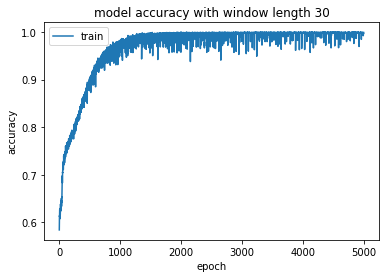

In [137]:
plt.plot(train_accs)
plt.title('model accuracy with window length 30')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

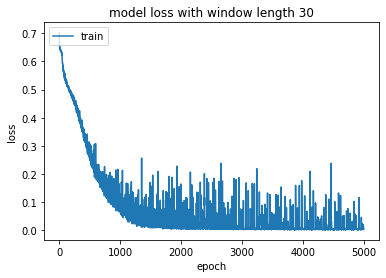

In [138]:
plt.plot(train_losses)
plt.title('model loss with window length 30')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [139]:
third_model.reset_states()
test_results = calc_pos_neg_rate(third_model.evaluate(x=test_generator, verbose=0))

In [140]:
third_model.reset_states()
train_results = calc_pos_neg_rate(third_model.evaluate(x=train_generator, verbose=0))

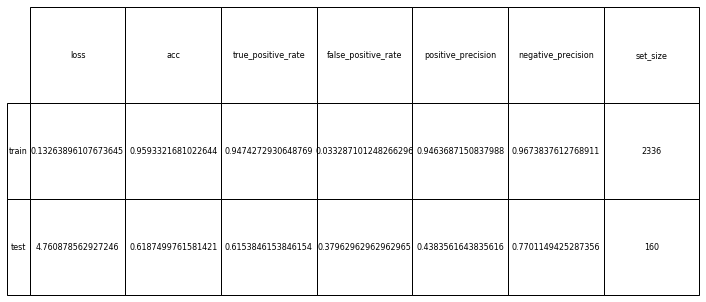

In [141]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Let's save this model for further use.

In [143]:
third_model.save(join(COLAB_DIR,'model_stateful_30.h5'))

## **Transfer Learning**

In this section, we load the pre-trained model and then do partial tuning with training it on the stock with second max trading days. Then, we test it to get accuracy of the model

In [ ]:
stock_with_second_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[1]

In [ ]:
train_start = pandas.to_datetime('20100101', format='%Y%m%d', errors='ignore')
train_end = pandas.to_datetime('20160719', format='%Y%m%d', errors='ignore')
test_start = pandas.to_datetime('20170101', format='%Y%m%d', errors='ignore')
test_end = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')

Next, we load the pretrained model

In [ ]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_second_max_trading_days, train_start, train_end, test_start, test_end)

In [ ]:
from keras.models import load_model


layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
base_model = build_model(train_generator.dim, optimizer, layers=layers, metrics=metrics)
base_model.load_weights(join(COLAB_DIR,'model_stateful.h5'))
base_model.summary()

In [ ]:
train_accs, train_losses = fit(base_model, epochs, train_generator)

In [ ]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10 with transfer learning applied')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
plt.plot(train_losses)
plt.title('model loss with window length 10 with transfer learning applied')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
results = calc_neg_pos_rate(base_model.evaluate(x=test_generator))
print('test:', results)

In [ ]:
results = calc_neg_pos_rate(base_model.evaluate(x=train_generator))
print('train:', results)